# Project Goal
- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [304]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import ensemble
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Histogram of Oriented Gradients (HOG)

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    features = []
    for img in imgs:
        img_features = []
    #2) Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else:
            feature_image = img[:,:,::-1]
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
        features.append(np.concatenate(img_features))
    #9) Return concatenated array of features
    return features

## Train a classifier

In [289]:
# Load data
vehicle_path = os.path.expanduser("~/Downloads/vehicles/")
nonvehicle_path = os.path.expanduser("~/Downloads/non-vehicles/")
train_vehicles = []
train_nonvehicles = []
test_vehicles = []
test_nonvehicles = []
counter = 0
for vehicle_file in glob.glob(vehicle_path+'KITTI_extracted/*.png'):
    train_vehicles.append(cv2.imread(vehicle_file))

# subsample the following folders
vehicle_subsample_folders = ['GTI_Far','GTI_Left','GTI_MiddleClose','GTI_Right']
for folder in vehicle_subsample_folders:
    counter = 0
    for vehicle in glob.glob(vehicle_path+folder+'/*.png'):
        if counter < 10:
            counter + 1
            test_vehicles.append(cv2.imread(vehicle))
        else:
            counter = 0
nonvehicle_subsample_folders = ['Extras','GTI']
for folder in nonvehicle_subsample_folders:
    counter = 0
    for nonvehicle in glob.glob(nonvehicle_path+folder+'/*.png'):
        if counter < 3:
            counter + 1
            if folder == 'GTI':
                test_nonvehicles.append(cv2.imread(nonvehicle))
            else:
                train_nonvehicles.append(cv2.imread(nonvehicle))
        else:
            counter = 0

In [290]:
print(len(train_vehicles))
print(len(train_nonvehicles))
print(len(test_vehicles))
print(len(test_nonvehicles))

5966
5068
2826
3900


In [325]:
# Balance
train_vehicles = train_vehicles[:len(test_vehicles)]
test_nonvehicles = test_nonvehicles[:len(test_vehicles)]
# extract features
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, 720] # Min and max in y to search in slide_window()
train_car_features = extract_features(train_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
train_notcar_features = extract_features(train_nonvehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
test_car_features = extract_features(test_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
test_notcar_features = extract_features(test_nonvehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X_train = np.vstack((train_car_features, train_notcar_features)).astype(np.float64)
X_test = np.vstack((test_car_features, test_notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
train_scaled_X = X_scaler.transform(X_train)
test_scaled_X = X_scaler.transform(X_test)
# create labels
y_train = np.hstack((np.ones(len(train_car_features)), 
              np.zeros(len(train_notcar_features))))
y_test = np.hstack((np.ones(len(test_car_features)), 
              np.zeros(len(test_notcar_features))))
# shuffle
#rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [371]:
xOut = open('X_scaler.pkl','wb')
pickle.dump(X_scaler, xOut)
xOut.close()

In [334]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(train_scaled_X, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(test_scaled_X, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

7.38 Seconds to train SVC...
Test Accuracy of SVC =  0.837


In [372]:
import pickle
# save the classifier
svcOut = open('svc.pkl', 'wb')
pickle.dump(svc, svcOut)
svcOut.close() 

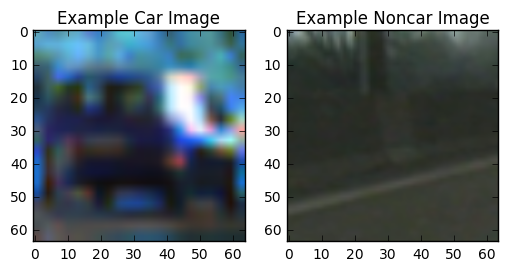

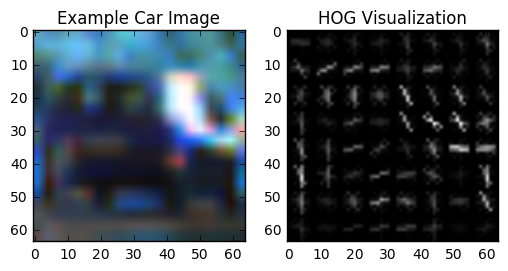

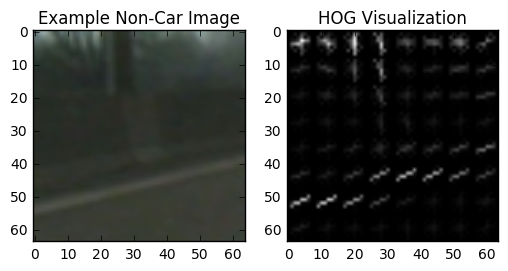

In [10]:
# HOG example
ind = np.random.randint(0, len(vehicles))
car = vehicles[ind]
noncar = nonvehicles[ind]
fig = plt.figure()
plt.subplot(121)
plt.imshow(car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(noncar, cmap='gray')
plt.title('Example Noncar Image')
plt.savefig('output_images/car_noncar.jpg')
gray = cv2.cvtColor(car, cv2.COLOR_BGR2GRAY)
gray_noncar = cv2.cvtColor(noncar, cv2.COLOR_BGR2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features, hog_image_noncar = get_hog_features(gray_noncar, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the example
fig = plt.figure()
plt.subplot(121)
plt.imshow(car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.savefig('output_images/hog_example.jpg')
fig = plt.figure()
plt.subplot(121)
plt.imshow(noncar, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(122)
plt.imshow(hog_image_noncar, cmap='gray')
plt.title('HOG Visualization')
plt.savefig('output_images/hog_noncar_example.jpg')

## Sliding Window Search

In [331]:
# implement sliding window on test images

img = cv2.imread('test_images/test1.jpg')

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255 # only for jpeg
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [195]:
# heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bboxes.append(bbox)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return bboxes, img

In [110]:
import pickle
# load it again
svcIn = open('svc.pkl', 'rb')
svc_loaded = pickle.load(svcIn)
X_scalerIn = open('X_scaler.pkl','rb')
X_scaler = pickle.load(X_scalerIn)

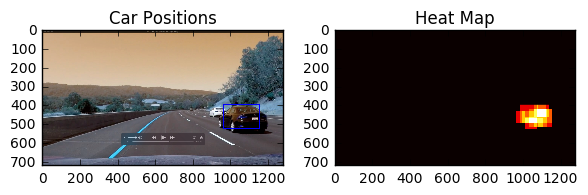

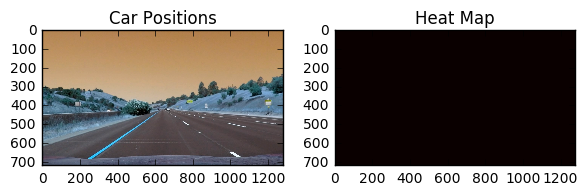

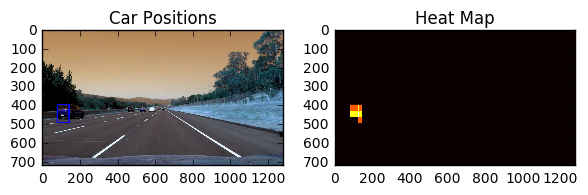

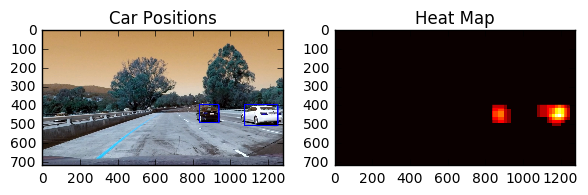

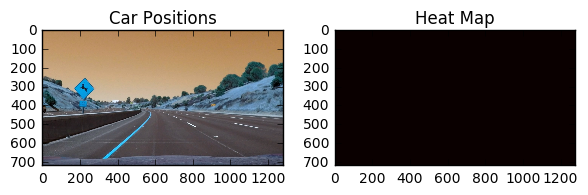

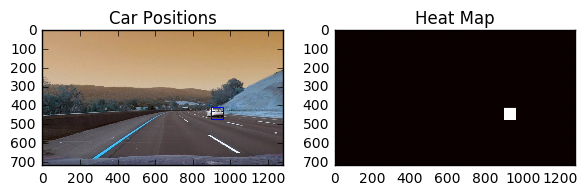

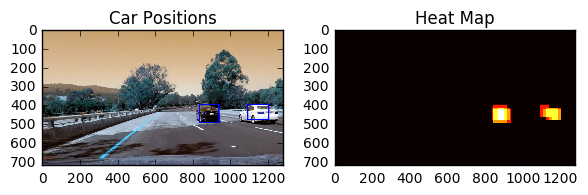

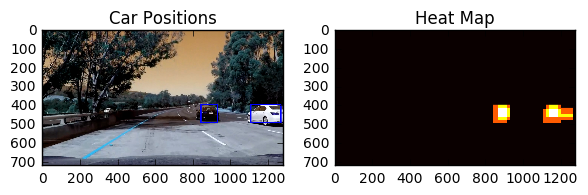

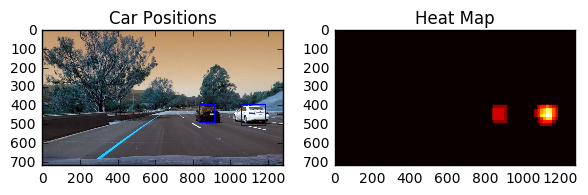

In [336]:
orient = 7  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

ystart = [400,400]
ystop = [656,550]
scale = [1.5,1.]
for img in glob.glob('test_images/*.jpg'):
    img = cv2.imread(img)
    box_list = []
    for i in range(len(ystart)):
        result = find_cars(img, ystart[i], ystop[i], scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list.extend(result)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    box, draw_img = draw_labeled_bboxes(np.copy(img), labels)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.savefig('output_images/heatmap.jpg')

## Video Implementation

In [217]:
# objects defined as 'vehicle' will be where multiple overlapping detections exist in heatmap
class Vehicle():
    def __init__(self):
        self.detected = False # was the vehicle detected in the last frame?
        self.detected_list = []
        self.n_detections = 0 # number of times this vehicle has been detected
        self.n_nondetections = 0 # number of consecutive times this car has not been detected
        self.xpixels = None # pixel x values of last detection
        self.ypixels = None # pixel y values of last detection
        self.recent_xfitted = [] # x position of the last n fits of bounding box
        self.bestx = None # average x position of the last n fits
        self.recent_yfitted = [] # y position of the last n fits of the bounding box
        self.besty = None
        self.recent_wfitted = []
        self.bestw = None # average width of the last n fits
        self.recent_hfitted = []
        self.besth = None

In [365]:
# implemented multi-window search AND heatmap over N frames
# in order to reduce false positives and combine overlapping boxes
orient = 7  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

ystart = [400,400,400]
ystop = [656,550,500]
scale = [1.5,1.,0.5]
car_list = []
def process_image(image):
    boxes_from_frame = []
    for i in range(len(ystart)):
        result = find_cars(image, ystart[i], ystop[i], scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        boxes_from_frame.extend(result)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,boxes_from_frame)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    boxes, draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    print(boxes)
    
    # group adjacent rectangles together
#     rect_list = [(int(x1),int(y1),int(x2-x1),int(y2-y1)) for ((x1,y1),(x2,y2)) in boxes]
#     rects,weights = cv2.groupRectangles(rect_list,1,eps=2)
#     rects = list(rects)
#     print(boxes)
#     print(rects)
#     if len(rects) > 0:
#         boxes = [rect.tolist() for rect in rects]
#         boxes = [((x,y),(x+w,y+h)) for [x,y,w,h] in boxes]
    
    # if any of the boxes found overlapping with detected vehicles
    for car in car_list:
        car.detected = False
    for box in boxes:
        detected = False
        for car in car_list:
            car_corners = ((car.bestx,car.besty),(car.bestx+car.bestw,car.besty+car.besth))
            if box[0][0] < car_corners[0][0]:
                left = box
                right = car_corners
            else:
                left = car_corners
                right = box
            if box[0][1] < car_corners[0][1]:
                top = box
                bottom = car_corners
            else:
                top = car_corners
                bottom = car_corners
            # if overlap
            if (right[0][0] - left[1][0] <= 0) and (bottom[0][1] - top[1][1] <= 0):
                # update
                car.detected = True
                print('detected!')
                car.n_detections += 1
                x = box[0][0]
                y = box[0][1]
                w = box[1][0] - box[0][0]
                h = box[1][1] - box[0][1]
                car.xpixels = [x,x+w]
                car.ypixels = [y,y+h]
                car.recent_xfitted.append(x)
                car.recent_yfitted.append(y)
                car.recent_wfitted.append(w)
                car.recent_hfitted.append(h)
                car.bestx = int(np.average(car.recent_xfitted[-5:]))
                car.besty = int(np.average(car.recent_yfitted[-5:]))
                car.bestw = int(np.average(car.recent_wfitted[-5:]))
                car.besth = int(np.average(car.recent_hfitted[-5:]))
                detected = True
                break # if detected exit from car_list
        # if box not found in car_list => create new car
        if detected == False:
            new_x = box[0][0]
            new_y = box[0][1]
            new_w = box[1][0] - box[0][0]
            new_h = box[1][1] - box[0][1]
            new_car = Vehicle()
            print('new_car!')
            new_car.detected = True
            new_car.n_detections += 1
            new_car.xpixels = [new_x,new_x+new_w]
            new_car.ypixels = [new_y,new_y+new_h]
            new_car.recent_xfitted.append(new_x)
            new_car.recent_yfitted.append(new_y)
            new_car.recent_wfitted.append(new_w)
            new_car.recent_hfitted.append(new_h)
            new_car.bestx = int(np.average(new_car.recent_xfitted[-5:]))
            new_car.besty = int(np.average(new_car.recent_yfitted[-5:]))
            new_car.bestw = int(np.average(new_car.recent_wfitted[-5:]))
            new_car.besth = int(np.average(new_car.recent_hfitted[-5:]))
            car_list.append(new_car)
    # remove false positives
    for car in car_list:
        if car.detected == False:
            car.n_nondetections += 1
        car.detected_list.append(car.detected)
        negative_detections = [detection for detection in car.detected_list[-10:] if detection == False]
        if len(negative_detections) > 5:
            car_list.remove(car) # if not detected 5 times in last 10 frames, delete
    # draw cars
    for car in car_list:
        positive_detections = [detection for detection in car.detected_list[-10:] if detection == True]
        if len(positive_detections) > 5:
            print((car.bestx,car.besty), (car.bestx+car.bestw,car.besty+car.besth))
            # if found 5 times in last 10 frames, draw box
            draw_img = cv2.rectangle(image, (car.bestx,car.besty), (car.bestx+car.bestw,car.besty+car.besth), (0,0,255), 6)
    
    return draw_img

In [368]:
detect_cars = 'test_video_out.mp4'
clip = VideoFileClip("test_video.mp4", audio=False)
clip_detection = clip.fl_image(process_image)
%time clip_detection.write_videofile(detect_cars, audio=False)

[((1016, 400), (1151, 495)), ((840, 432), (887, 463)), ((432, 520), (503, 591))]
detected!
new_car!
new_car!
(1033, 438) (1168, 552)
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4















  0%|          | 0/39 [00:00<?, ?it/s]












  3%|▎         | 1/39 [00:03<02:14,  3.53s/it]

[((1008, 400), (1215, 567)), ((840, 432), (887, 463)), ((432, 520), (503, 591))]
detected!
detected!
detected!
(1028, 428) (1175, 556)















  5%|▌         | 2/39 [00:07<02:14,  3.64s/it]

[((1016, 400), (1167, 495)), ((840, 424), (911, 495)), ((432, 520), (503, 615))]
detected!
detected!
detected!
(1025, 419) (1172, 538)















  8%|▊         | 3/39 [00:11<02:12,  3.69s/it]

[((1040, 400), (1167, 511)), ((840, 424), (911, 495)), ((432, 520), (527, 591))]
detected!
detected!
detected!
(1027, 409) (1173, 531)















 10%|█         | 4/39 [00:15<02:10,  3.73s/it]

[((1024, 400), (1215, 495)), ((840, 424), (911, 495))]
detected!
detected!
(1020, 400) (1182, 512)















 13%|█▎        | 5/39 [00:18<02:05,  3.70s/it]

[((1024, 416), (1151, 495)), ((840, 424), (911, 495)), ((1168, 424), (1223, 463))]
detected!
detected!
detected!
(1054, 408) (1184, 491)















 15%|█▌        | 6/39 [00:22<02:04,  3.78s/it]

[((1024, 408), (1223, 511)), ((840, 432), (895, 495))]
detected!
detected!
(1056, 409) (1195, 494)















 18%|█▊        | 7/39 [00:26<02:05,  3.91s/it]

[((1024, 416), (1207, 511)), ((848, 432), (879, 463))]
detected!
detected!
(1052, 412) (1203, 494)
(841, 427) (900, 488)















 21%|██        | 8/39 [00:31<02:06,  4.09s/it]

[((1024, 400), (1215, 511)), ((840, 432), (895, 495))]
detected!
detected!
(1052, 412) (1203, 497)
(841, 428) (897, 487)















 23%|██▎       | 9/39 [00:35<02:01,  4.04s/it]

[((1024, 416), (1207, 479)), ((848, 432), (879, 463))]
detected!
detected!
(1052, 412) (1214, 494)
(843, 430) (891, 481)















 26%|██▌       | 10/39 [00:39<01:54,  3.96s/it]

[((1032, 400), (1215, 511)), ((848, 432), (879, 463))]
detected!
detected!
(1025, 408) (1212, 504)
(844, 432) (884, 475)















 28%|██▊       | 11/39 [00:42<01:50,  3.94s/it]

[((1032, 400), (1207, 495)), ((848, 432), (879, 463))]
detected!
detected!
(1027, 406) (1210, 501)
(846, 432) (881, 469)















 31%|███       | 12/39 [00:46<01:43,  3.85s/it]

[((1032, 400), (1207, 511)), ((840, 424), (911, 495))]
detected!
detected!
(1028, 403) (1209, 501)
(844, 430) (887, 475)















 33%|███▎      | 13/39 [00:49<01:35,  3.68s/it]

[((1032, 400), (1199, 511)), ((840, 432), (895, 495))]
detected!
detected!
(1030, 403) (1206, 501)
(844, 430) (887, 475)















 36%|███▌      | 14/39 [00:53<01:29,  3.57s/it]

[((1040, 400), (1215, 511)), ((840, 432), (895, 495))]
detected!
detected!
(1033, 400) (1208, 507)
(843, 430) (891, 481)















 38%|███▊      | 15/39 [00:56<01:24,  3.53s/it]

[((1032, 400), (1231, 511)), ((848, 432), (879, 463))]
detected!
detected!
(1033, 400) (1211, 507)
(843, 430) (891, 481)















 41%|████      | 16/39 [01:00<01:20,  3.52s/it]

[((1048, 400), (1239, 511)), ((848, 432), (879, 463))]
detected!
detected!
(1036, 400) (1217, 511)
(843, 430) (891, 481)















 44%|████▎     | 17/39 [01:03<01:15,  3.45s/it]

[((1040, 400), (1223, 511)), ((1224, 400), (1263, 439)), ((848, 432), (879, 463))]
detected!
new_car!
detected!
(1038, 400) (1221, 511)
(844, 432) (884, 475)















 46%|████▌     | 18/39 [01:07<01:13,  3.50s/it]

[((1040, 400), (1223, 519)), ((848, 432), (879, 471)), ((904, 432), (935, 463))]
detected!
detected!
new_car!
(1040, 400) (1226, 512)
(846, 432) (881, 471)















 49%|████▊     | 19/39 [01:10<01:11,  3.58s/it]

[((1048, 400), (1231, 519)), ((848, 432), (879, 471))]
detected!
detected!
(1041, 400) (1228, 514)
(848, 432) (879, 466)















 51%|█████▏    | 20/39 [01:14<01:07,  3.56s/it]

[((1040, 400), (1215, 511)), ((848, 432), (879, 471))]
detected!
detected!
(1043, 400) (1226, 514)
(848, 432) (879, 467)















 54%|█████▍    | 21/39 [01:17<01:03,  3.52s/it]

[((1048, 400), (1231, 519)), ((848, 432), (879, 471)), ((904, 432), (935, 463))]
detected!
detected!
detected!
(1043, 400) (1224, 515)
(848, 432) (879, 469)















 56%|█████▋    | 22/39 [01:21<01:00,  3.57s/it]

[((1048, 400), (1231, 519)), ((848, 432), (879, 463))]
detected!
detected!
(1044, 400) (1225, 517)
(848, 432) (879, 469)















 59%|█████▉    | 23/39 [01:25<00:58,  3.68s/it]

[((1048, 400), (1239, 519)), ((848, 432), (879, 463))]
detected!
detected!
(1046, 400) (1229, 517)
(848, 432) (879, 467)















 62%|██████▏   | 24/39 [01:29<00:56,  3.77s/it]

[((1048, 400), (1239, 511)), ((840, 432), (895, 495))]
detected!
detected!
(1046, 400) (1230, 515)
(846, 432) (881, 472)















 64%|██████▍   | 25/39 [01:33<00:53,  3.84s/it]

[((1048, 400), (1239, 511)), ((840, 424), (927, 495))]
detected!
detected!
(1048, 400) (1235, 515)
(844, 430) (891, 477)















 67%|██████▋   | 26/39 [01:37<00:49,  3.82s/it]

[((1048, 400), (1239, 511)), ((840, 424), (927, 495))]
detected!
detected!
(1048, 400) (1237, 514)
(843, 428) (901, 481)















 69%|██████▉   | 27/39 [01:40<00:45,  3.78s/it]

[((1056, 400), (1247, 511)), ((840, 424), (927, 495))]
detected!
detected!
(1049, 400) (1240, 512)
(841, 427) (910, 488)















 72%|███████▏  | 28/39 [01:44<00:40,  3.73s/it]

[((1056, 400), (1231, 511)), ((840, 416), (927, 495))]
detected!
detected!
(1051, 400) (1238, 511)
(840, 424) (920, 495)















 74%|███████▍  | 29/39 [01:47<00:36,  3.60s/it]

[((1048, 400), (1247, 519)), ((832, 424), (911, 495))]
detected!
detected!
(1051, 400) (1240, 512)
(838, 422) (923, 494)















 77%|███████▋  | 30/39 [01:51<00:32,  3.59s/it]

[((1056, 400), (1247, 519)), ((832, 416), (911, 495))]
detected!
detected!
(1052, 400) (1241, 514)
(836, 420) (919, 494)















 79%|███████▉  | 31/39 [01:55<00:29,  3.65s/it]

[((1056, 400), (1231, 519)), ((840, 424), (927, 495))]
detected!
detected!
(1054, 400) (1240, 515)
(836, 420) (919, 494)















 82%|████████▏ | 32/39 [01:58<00:25,  3.61s/it]

[((1056, 400), (1231, 519)), ((832, 416), (927, 495))]
detected!
detected!
(1054, 400) (1237, 517)
(835, 419) (920, 494)















 85%|████████▍ | 33/39 [02:02<00:22,  3.74s/it]

[((1056, 400), (1247, 519)), ((840, 416), (911, 495))]
detected!
detected!
(1054, 400) (1240, 519)
(835, 419) (917, 494)















 87%|████████▋ | 34/39 [02:06<00:18,  3.79s/it]

[((1056, 400), (1231, 519)), ((840, 416), (927, 495))]
detected!
detected!
(1056, 400) (1237, 519)
(836, 417) (919, 494)















 90%|████████▉ | 35/39 [02:10<00:14,  3.73s/it]

[((1064, 400), (1247, 543)), ((840, 416), (927, 495))]
detected!
detected!
(1057, 400) (1236, 523)
(838, 417) (923, 494)















 92%|█████████▏| 36/39 [02:13<00:11,  3.73s/it]

[((1064, 400), (1247, 543)), ((840, 416), (927, 495))]
detected!
detected!
(1059, 400) (1240, 528)
(838, 416) (923, 495)















 95%|█████████▍| 37/39 [02:17<00:07,  3.79s/it]

[((1064, 400), (1247, 519)), ((832, 416), (911, 495))]
detected!
detected!
(1060, 400) (1243, 528)
(838, 416) (920, 495)















 97%|█████████▋| 38/39 [02:21<00:03,  3.71s/it]

[((1064, 400), (1247, 543)), ((832, 416), (927, 495))]
detected!
detected!
(1062, 400) (1243, 533)
(836, 416) (923, 495)


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 2min 15s, sys: 4.09 s, total: 2min 19s
Wall time: 2min 23s


In [370]:
car_list = []
detect_cars = 'detect_cars.mp4'
clip = VideoFileClip("project_video.mp4", audio=False)
clip_detection = clip.fl_image(process_image)
%time clip_detection.write_videofile(detect_cars, audio=False)

[]
[MoviePy] >>>> Building video detect_cars.mp4
[MoviePy] Writing video detect_cars.mp4




























  0%|          | 0/1261 [00:00<?, ?it/s]













  0%|          | 1/1261 [00:03<1:11:28,  3.40s/it]

[]
















  0%|          | 2/1261 [00:06<1:11:11,  3.39s/it]

[]
















  0%|          | 3/1261 [00:10<1:10:20,  3.36s/it]

[((552, 432), (575, 455))]
new_car!
















  0%|          | 4/1261 [00:13<1:09:30,  3.32s/it]

[]
















  0%|          | 5/1261 [00:16<1:09:10,  3.30s/it]

[]
















  0%|          | 6/1261 [00:19<1:08:34,  3.28s/it]

[]
















  1%|          | 7/1261 [00:22<1:08:13,  3.26s/it]

[]
















  1%|          | 8/1261 [00:26<1:08:29,  3.28s/it]

[]
















  1%|          | 9/1261 [00:29<1:08:52,  3.30s/it]

[((552, 432), (591, 487))]
detected!
















  1%|          | 10/1261 [00:32<1:08:17,  3.28s/it]

[((560, 440), (583, 463))]
detected!
















  1%|          | 11/1261 [00:36<1:08:08,  3.27s/it]

[((560, 448), (583, 463))]
detected!
















  1%|          | 12/1261 [00:39<1:07:51,  3.26s/it]

[]
















  1%|          | 13/1261 [00:42<1:07:35,  3.25s/it]

[]
















  1%|          | 14/1261 [00:45<1:07:46,  3.26s/it]

[]
















  1%|          | 15/1261 [00:49<1:07:17,  3.24s/it]

[]
















  1%|▏         | 16/1261 [00:52<1:07:08,  3.24s/it]

[]
















  1%|▏         | 17/1261 [00:55<1:06:59,  3.23s/it]

[]
















  1%|▏         | 18/1261 [00:59<1:11:00,  3.43s/it]

[((544, 448), (567, 471))]
new_car!
















  2%|▏         | 19/1261 [01:03<1:14:17,  3.59s/it]

[]
















  2%|▏         | 20/1261 [01:07<1:15:39,  3.66s/it]

[]
















  2%|▏         | 21/1261 [01:10<1:15:31,  3.65s/it]

[]
















  2%|▏         | 22/1261 [01:14<1:16:33,  3.71s/it]

[]
















  2%|▏         | 23/1261 [01:18<1:16:14,  3.70s/it]

[]
















  2%|▏         | 24/1261 [01:21<1:14:43,  3.62s/it]

[((544, 440), (567, 463))]
detected!
















  2%|▏         | 25/1261 [01:25<1:16:59,  3.74s/it]

[((544, 440), (567, 471))]
detected!
















  2%|▏         | 26/1261 [01:29<1:16:59,  3.74s/it]

[((560, 448), (567, 463))]
detected!
















  2%|▏         | 27/1261 [01:33<1:15:32,  3.67s/it]

[((544, 440), (567, 471))]
detected!
















  2%|▏         | 28/1261 [01:37<1:17:43,  3.78s/it]

[((544, 440), (567, 463))]
detected!
















  2%|▏         | 29/1261 [01:41<1:18:40,  3.83s/it]

[((560, 448), (567, 463))]
detected!
(550, 443) (566, 466)
















  2%|▏         | 30/1261 [01:44<1:17:06,  3.76s/it]

[((560, 448), (567, 463))]
detected!
(553, 444) (566, 463)
















  2%|▏         | 31/1261 [01:48<1:17:40,  3.79s/it]

[((536, 440), (575, 471))]
detected!
(548, 443) (567, 466)
















  3%|▎         | 32/1261 [01:51<1:14:23,  3.63s/it]

[((536, 440), (567, 471))]
detected!
(547, 443) (568, 466)
















  3%|▎         | 33/1261 [01:55<1:16:49,  3.75s/it]

[((544, 440), (567, 471))]
detected!
(547, 443) (568, 467)
















  3%|▎         | 34/1261 [01:59<1:18:33,  3.84s/it]

[((536, 440), (575, 471))]
detected!
(542, 441) (569, 468)
















  3%|▎         | 35/1261 [02:03<1:18:23,  3.84s/it]

[]
(542, 441) (569, 468)
















  3%|▎         | 36/1261 [02:07<1:18:22,  3.84s/it]

[]
(542, 441) (569, 468)
















  3%|▎         | 37/1261 [02:11<1:17:46,  3.81s/it]

[]
(542, 441) (569, 468)
















  3%|▎         | 38/1261 [02:15<1:17:22,  3.80s/it]

[((544, 448), (591, 487))]
detected!
(539, 441) (574, 473)
















  3%|▎         | 39/1261 [02:18<1:17:29,  3.80s/it]

[((544, 448), (591, 487))]
detected!
(540, 443) (577, 477)
















  3%|▎         | 40/1261 [02:22<1:14:16,  3.65s/it]

[]
(540, 443) (577, 477)
















  3%|▎         | 41/1261 [02:25<1:12:13,  3.55s/it]

[]
















  3%|▎         | 42/1261 [02:28<1:11:14,  3.51s/it]

[]
















  3%|▎         | 43/1261 [02:32<1:09:40,  3.43s/it]

[]
















  3%|▎         | 44/1261 [02:35<1:08:41,  3.39s/it]

[]
















  4%|▎         | 45/1261 [02:38<1:08:05,  3.36s/it]

[]
















  4%|▎         | 46/1261 [02:41<1:07:07,  3.31s/it]

[]
















  4%|▎         | 47/1261 [02:45<1:06:36,  3.29s/it]

[]
















  4%|▍         | 48/1261 [02:48<1:06:30,  3.29s/it]

[]
















  4%|▍         | 49/1261 [02:51<1:06:14,  3.28s/it]

[((544, 440), (567, 471))]
new_car!
















  4%|▍         | 50/1261 [02:54<1:06:00,  3.27s/it]

[]
















  4%|▍         | 51/1261 [02:58<1:06:38,  3.30s/it]

[]
















  4%|▍         | 52/1261 [03:01<1:06:16,  3.29s/it]

[]
















  4%|▍         | 53/1261 [03:05<1:08:06,  3.38s/it]

[]
















  4%|▍         | 54/1261 [03:08<1:08:07,  3.39s/it]

[]
















  4%|▍         | 55/1261 [03:11<1:07:15,  3.35s/it]

[]
















  4%|▍         | 56/1261 [03:15<1:06:25,  3.31s/it]

[]
















  5%|▍         | 57/1261 [03:18<1:05:59,  3.29s/it]

[]
















  5%|▍         | 58/1261 [03:21<1:05:53,  3.29s/it]

[]
















  5%|▍         | 59/1261 [03:24<1:05:42,  3.28s/it]

[]
















  5%|▍         | 60/1261 [03:28<1:05:39,  3.28s/it]

[]
















  5%|▍         | 61/1261 [03:31<1:05:20,  3.27s/it]

[]
















  5%|▍         | 62/1261 [03:34<1:05:15,  3.27s/it]

[]
















  5%|▍         | 63/1261 [03:37<1:05:11,  3.27s/it]

[]
















  5%|▌         | 64/1261 [03:41<1:05:05,  3.26s/it]

[]
















  5%|▌         | 65/1261 [03:44<1:04:53,  3.26s/it]

[]
















  5%|▌         | 66/1261 [03:47<1:04:54,  3.26s/it]

[]
















  5%|▌         | 67/1261 [03:50<1:04:50,  3.26s/it]

[]
















  5%|▌         | 68/1261 [03:55<1:13:50,  3.71s/it]

[]
















  5%|▌         | 69/1261 [04:00<1:17:54,  3.92s/it]

[]
















  6%|▌         | 70/1261 [04:04<1:22:07,  4.14s/it]

[]
















  6%|▌         | 71/1261 [04:08<1:21:39,  4.12s/it]

[]
















  6%|▌         | 72/1261 [04:12<1:21:37,  4.12s/it]

[]
















  6%|▌         | 73/1261 [04:16<1:19:18,  4.01s/it]

[]
















  6%|▌         | 74/1261 [04:19<1:15:01,  3.79s/it]

[]
















  6%|▌         | 75/1261 [04:23<1:12:17,  3.66s/it]

[]
















  6%|▌         | 76/1261 [04:26<1:09:37,  3.52s/it]

[]
















  6%|▌         | 77/1261 [04:30<1:09:32,  3.52s/it]

[]
















  6%|▌         | 78/1261 [04:33<1:08:04,  3.45s/it]

[]
















  6%|▋         | 79/1261 [04:36<1:08:21,  3.47s/it]

[]
















  6%|▋         | 80/1261 [04:40<1:08:37,  3.49s/it]

[]
















  6%|▋         | 81/1261 [04:43<1:07:57,  3.46s/it]

[]
















  7%|▋         | 82/1261 [04:47<1:06:59,  3.41s/it]

[]
















  7%|▋         | 83/1261 [04:50<1:08:38,  3.50s/it]

[]
















  7%|▋         | 84/1261 [04:54<1:09:22,  3.54s/it]

[]
















  7%|▋         | 85/1261 [04:58<1:10:12,  3.58s/it]

[]
















  7%|▋         | 86/1261 [05:01<1:10:25,  3.60s/it]

[]
















  7%|▋         | 87/1261 [05:05<1:10:27,  3.60s/it]

[]
















  7%|▋         | 88/1261 [05:09<1:11:23,  3.65s/it]

[]
















  7%|▋         | 89/1261 [05:12<1:12:16,  3.70s/it]

[]
















  7%|▋         | 90/1261 [05:16<1:09:29,  3.56s/it]

[]
















  7%|▋         | 91/1261 [05:19<1:07:43,  3.47s/it]

[]
















  7%|▋         | 92/1261 [05:22<1:06:25,  3.41s/it]

[((560, 448), (591, 487))]
new_car!
















  7%|▋         | 93/1261 [05:25<1:05:29,  3.36s/it]

[((560, 456), (591, 479))]
detected!
















  7%|▋         | 94/1261 [05:29<1:05:27,  3.37s/it]

[]
















  8%|▊         | 95/1261 [05:32<1:04:54,  3.34s/it]

[]
















  8%|▊         | 96/1261 [05:35<1:04:10,  3.31s/it]

[]
















  8%|▊         | 97/1261 [05:39<1:03:51,  3.29s/it]

[]
















  8%|▊         | 98/1261 [05:42<1:03:42,  3.29s/it]

[]
















  8%|▊         | 99/1261 [05:45<1:03:20,  3.27s/it]

[]
















  8%|▊         | 100/1261 [05:48<1:03:11,  3.27s/it]

[]
















  8%|▊         | 101/1261 [05:52<1:03:17,  3.27s/it]

[]
















  8%|▊         | 102/1261 [05:55<1:03:26,  3.28s/it]

[((560, 456), (591, 479))]
new_car!
















  8%|▊         | 103/1261 [05:58<1:03:14,  3.28s/it]

[]
















  8%|▊         | 104/1261 [06:02<1:04:02,  3.32s/it]

[]
















  8%|▊         | 105/1261 [06:06<1:08:50,  3.57s/it]

[]
















  8%|▊         | 106/1261 [06:09<1:09:16,  3.60s/it]

[]
















  8%|▊         | 107/1261 [06:13<1:08:35,  3.57s/it]

[]
















  9%|▊         | 108/1261 [06:16<1:08:40,  3.57s/it]

[]
















  9%|▊         | 109/1261 [06:20<1:07:52,  3.53s/it]

[]
















  9%|▊         | 110/1261 [06:24<1:08:24,  3.57s/it]

[]
















  9%|▉         | 111/1261 [06:27<1:07:22,  3.51s/it]

[]
















  9%|▉         | 112/1261 [06:31<1:07:49,  3.54s/it]

[]
















  9%|▉         | 113/1261 [06:34<1:06:03,  3.45s/it]

[]
















  9%|▉         | 114/1261 [06:37<1:05:02,  3.40s/it]

[((560, 456), (575, 463))]
new_car!
















  9%|▉         | 115/1261 [06:40<1:04:10,  3.36s/it]

[]
















  9%|▉         | 116/1261 [06:44<1:03:09,  3.31s/it]

[]
















  9%|▉         | 117/1261 [06:47<1:02:35,  3.28s/it]

[]
















  9%|▉         | 118/1261 [06:50<1:02:25,  3.28s/it]

[]
















  9%|▉         | 119/1261 [06:53<1:01:58,  3.26s/it]

[]
















 10%|▉         | 120/1261 [06:56<1:01:42,  3.25s/it]

[]
















 10%|▉         | 121/1261 [07:00<1:01:22,  3.23s/it]

[]
















 10%|▉         | 122/1261 [07:03<1:02:42,  3.30s/it]

[]
















 10%|▉         | 123/1261 [07:07<1:07:26,  3.56s/it]

[]
















 10%|▉         | 124/1261 [07:12<1:12:14,  3.81s/it]

[]
















 10%|▉         | 125/1261 [07:16<1:14:56,  3.96s/it]

[((560, 448), (575, 463))]
new_car!
















 10%|▉         | 126/1261 [07:20<1:14:53,  3.96s/it]

[((544, 440), (567, 463))]
detected!
















 10%|█         | 127/1261 [07:24<1:15:29,  3.99s/it]

[((560, 464), (567, 471))]
detected!
















 10%|█         | 128/1261 [07:28<1:14:07,  3.93s/it]

[((560, 448), (591, 479))]
detected!
















 10%|█         | 129/1261 [07:31<1:12:29,  3.84s/it]

[((560, 448), (567, 471))]
detected!
















 10%|█         | 130/1261 [07:35<1:10:21,  3.73s/it]

[((560, 448), (591, 479))]
detected!
(556, 449) (575, 472)
















 10%|█         | 131/1261 [07:38<1:08:57,  3.66s/it]

[]
(556, 449) (575, 472)
















 10%|█         | 132/1261 [07:42<1:09:01,  3.67s/it]

[((152, 416), (183, 455))]
new_car!
(556, 449) (575, 472)
















 11%|█         | 133/1261 [07:46<1:11:05,  3.78s/it]

[((136, 424), (167, 447)), ((1232, 448), (1263, 463))]
detected!
new_car!
(556, 449) (575, 472)
















 11%|█         | 134/1261 [07:50<1:11:47,  3.82s/it]

[]
(556, 449) (575, 472)
















 11%|█         | 135/1261 [07:54<1:14:25,  3.97s/it]

[]
















 11%|█         | 136/1261 [08:00<1:23:38,  4.46s/it]

[((72, 424), (95, 455))]
new_car!
















 11%|█         | 137/1261 [08:04<1:23:54,  4.48s/it]

[((48, 424), (79, 455))]
detected!
















 11%|█         | 138/1261 [08:08<1:19:29,  4.25s/it]

[((16, 424), (39, 455))]
new_car!
















 11%|█         | 139/1261 [08:12<1:16:49,  4.11s/it]

[((1240, 448), (1247, 471))]
detected!
















 11%|█         | 140/1261 [08:16<1:15:39,  4.05s/it]

[((1240, 448), (1271, 463))]
detected!
















 11%|█         | 141/1261 [08:20<1:14:46,  4.01s/it]

[((1232, 440), (1263, 471))]
detected!
















 11%|█▏        | 142/1261 [08:24<1:16:44,  4.12s/it]

[((1240, 456), (1247, 471))]
detected!
















 11%|█▏        | 143/1261 [08:28<1:16:48,  4.12s/it]

[((1240, 448), (1263, 471))]
detected!
















 11%|█▏        | 144/1261 [08:32<1:15:57,  4.08s/it]

[((1224, 440), (1263, 471))]
detected!
















 11%|█▏        | 145/1261 [08:37<1:17:29,  4.17s/it]

[((1224, 440), (1263, 471))]
detected!
(1232, 444) (1259, 470)
















 12%|█▏        | 146/1261 [08:41<1:18:54,  4.25s/it]

[((1216, 440), (1263, 479))]
detected!
(1228, 444) (1259, 471)
















 12%|█▏        | 147/1261 [08:44<1:14:04,  3.99s/it]

[((1200, 440), (1263, 471))]
detected!
(1220, 441) (1262, 472)
















 12%|█▏        | 148/1261 [08:48<1:12:02,  3.88s/it]

[((1216, 440), (1263, 471))]
detected!
(1216, 440) (1263, 472)
















 12%|█▏        | 149/1261 [08:52<1:11:59,  3.88s/it]

[((1216, 440), (1263, 471))]
detected!
(1214, 440) (1262, 472)
















 12%|█▏        | 150/1261 [08:55<1:09:12,  3.74s/it]

[((1208, 440), (1255, 471))]
detected!
(1211, 440) (1261, 472)
















 12%|█▏        | 151/1261 [08:59<1:06:35,  3.60s/it]

[((1200, 432), (1255, 479))]
detected!
(1208, 438) (1259, 472)
















 12%|█▏        | 152/1261 [09:02<1:04:43,  3.50s/it]

[((1184, 432), (1247, 479)), ((560, 448), (591, 479))]
detected!
new_car!
(1204, 436) (1255, 473)
















 12%|█▏        | 153/1261 [09:05<1:03:13,  3.42s/it]

[((1200, 432), (1271, 479))]
detected!
(1201, 435) (1257, 475)
















 12%|█▏        | 154/1261 [09:08<1:02:12,  3.37s/it]

[((1200, 432), (1271, 479))]
detected!
(1198, 433) (1259, 476)
















 12%|█▏        | 155/1261 [09:12<1:01:29,  3.34s/it]

[((1200, 432), (1271, 479))]
detected!
(1196, 432) (1262, 479)
















 12%|█▏        | 156/1261 [09:15<1:00:41,  3.30s/it]

[((1184, 432), (1271, 487))]
detected!
(1193, 432) (1265, 480)
















 12%|█▏        | 157/1261 [09:18<1:00:08,  3.27s/it]

[((1192, 432), (1271, 479))]
detected!
(1195, 432) (1270, 480)
















 13%|█▎        | 158/1261 [09:21<59:59,  3.26s/it]  

[((1184, 440), (1263, 479))]
detected!
(1192, 433) (1269, 480)
















 13%|█▎        | 159/1261 [09:25<59:42,  3.25s/it]

[((1168, 432), (1263, 479))]
detected!
(1185, 433) (1267, 480)
















 13%|█▎        | 160/1261 [09:28<59:29,  3.24s/it]

[((1184, 432), (1263, 495))]
detected!
(1182, 433) (1265, 483)
















 13%|█▎        | 161/1261 [09:31<59:34,  3.25s/it]

[((1176, 432), (1263, 495))]
detected!
(1180, 433) (1263, 484)
















 13%|█▎        | 162/1261 [09:34<59:19,  3.24s/it]

[((1176, 424), (1263, 495))]
detected!
(1177, 432) (1262, 488)
















 13%|█▎        | 163/1261 [09:38<59:21,  3.24s/it]

[((1176, 424), (1255, 479))]
detected!
(1176, 428) (1261, 487)
















 13%|█▎        | 164/1261 [09:41<59:08,  3.23s/it]

[((1168, 432), (1247, 495))]
detected!
(1176, 428) (1258, 491)
















 13%|█▎        | 165/1261 [09:44<59:00,  3.23s/it]

[((1152, 432), (1247, 495))]
detected!
(1169, 428) (1254, 491)
















 13%|█▎        | 166/1261 [09:47<59:04,  3.24s/it]

[((1152, 432), (1247, 495))]
detected!
(1164, 428) (1251, 491)
















 13%|█▎        | 167/1261 [09:50<59:10,  3.25s/it]

[((1152, 432), (1247, 495))]
detected!
(1160, 430) (1248, 491)
















 13%|█▎        | 168/1261 [09:54<59:01,  3.24s/it]

[((1152, 424), (1247, 479))]
detected!
(1155, 430) (1246, 491)
















 13%|█▎        | 169/1261 [09:57<58:51,  3.23s/it]

[((1152, 424), (1247, 495))]
detected!
(1152, 428) (1247, 491)
















 13%|█▎        | 170/1261 [10:00<58:56,  3.24s/it]

[((1152, 424), (1231, 495))]
detected!
(1152, 427) (1243, 491)
















 14%|█▎        | 171/1261 [10:03<59:02,  3.25s/it]

[((1152, 424), (1231, 495))]
detected!
(1152, 425) (1240, 491)
















 14%|█▎        | 172/1261 [10:08<1:04:00,  3.53s/it]

[((1136, 408), (1231, 495))]
detected!
(1148, 420) (1236, 491)
















 14%|█▎        | 173/1261 [10:11<1:04:34,  3.56s/it]

[((1136, 400), (1247, 495))]
detected!
(1145, 416) (1236, 495)
















 14%|█▍        | 174/1261 [10:15<1:04:23,  3.55s/it]

[((1144, 408), (1247, 495))]
detected!
(1144, 412) (1237, 494)
















 14%|█▍        | 175/1261 [10:18<1:04:54,  3.59s/it]

[((1128, 400), (1247, 519))]
detected!
(1139, 408) (1240, 499)
















 14%|█▍        | 176/1261 [10:22<1:04:20,  3.56s/it]

[((1128, 424), (1223, 519)), ((1240, 440), (1247, 479))]
detected!
new_car!
(1134, 408) (1238, 504)
















 14%|█▍        | 177/1261 [10:25<1:03:20,  3.51s/it]

[((1128, 424), (1223, 519)), ((1240, 448), (1271, 479))]
detected!
detected!
(1132, 411) (1236, 509)
















 14%|█▍        | 178/1261 [10:29<1:03:58,  3.54s/it]

[((1128, 424), (1215, 495)), ((1240, 448), (1271, 471))]
detected!
detected!
(1131, 416) (1230, 509)
















 14%|█▍        | 179/1261 [10:33<1:04:50,  3.60s/it]

[((1120, 424), (1215, 495)), ((552, 456), (583, 487)), ((1240, 456), (1263, 471))]
detected!
new_car!
detected!
(1126, 419) (1224, 509)
















 14%|█▍        | 180/1261 [10:36<1:04:56,  3.60s/it]

[((1128, 424), (1207, 495)), ((1240, 448), (1263, 479))]
detected!
detected!
(1126, 424) (1216, 504)
















 14%|█▍        | 181/1261 [10:40<1:03:58,  3.55s/it]

[((1120, 424), (1215, 519)), ((1232, 448), (1263, 487))]
detected!
detected!
(1124, 424) (1214, 504)
(1238, 449) (1265, 476)
















 14%|█▍        | 182/1261 [10:43<1:03:51,  3.55s/it]

[((1128, 416), (1271, 519))]
detected!
(1124, 422) (1223, 504)
(1238, 449) (1265, 476)
















 15%|█▍        | 183/1261 [10:47<1:03:18,  3.52s/it]

[((1128, 416), (1215, 511)), ((1224, 448), (1263, 487))]
detected!
detected!
(1124, 420) (1223, 507)
(1235, 449) (1264, 478)
















 15%|█▍        | 184/1261 [10:50<1:03:12,  3.52s/it]

[((1128, 424), (1199, 495)), ((1224, 440), (1271, 479))]
detected!
detected!
(1126, 420) (1221, 507)
(1232, 448) (1264, 480)
















 15%|█▍        | 185/1261 [10:54<1:03:10,  3.52s/it]

[((1128, 408), (1271, 511))]
detected!
(1126, 417) (1233, 510)
(1232, 448) (1264, 480)
















 15%|█▍        | 186/1261 [10:57<1:03:39,  3.55s/it]

[((1120, 424), (1207, 511)), ((1216, 440), (1271, 487))]
detected!
detected!
(1144, 422) (1232, 502)
(1232, 448) (1264, 480)
















 15%|█▍        | 187/1261 [11:01<1:03:42,  3.56s/it]

[((1120, 400), (1271, 495))]
detected!
(1142, 419) (1243, 499)
(1232, 448) (1264, 480)
















 15%|█▍        | 188/1261 [11:05<1:03:31,  3.55s/it]

[((1112, 408), (1207, 495)), ((1216, 440), (1271, 487))]
detected!
detected!
(1156, 422) (1244, 494)
















 15%|█▍        | 189/1261 [11:08<1:03:47,  3.57s/it]

[((1112, 408), (1199, 495)), ((1216, 432), (1271, 487)), ((536, 448), (559, 471))]
detected!
detected!
new_car!
(1155, 417) (1243, 491)
















 15%|█▌        | 190/1261 [11:12<1:04:18,  3.60s/it]

[((1104, 408), (1199, 495)), ((1216, 440), (1271, 487))]
detected!
detected!
(1172, 425) (1241, 489)
















 15%|█▌        | 191/1261 [11:15<1:04:26,  3.61s/it]

[((1104, 416), (1199, 495)), ((1208, 432), (1271, 487)), ((536, 440), (591, 487))]
detected!
detected!
detected!
(1169, 425) (1241, 489)
















 15%|█▌        | 192/1261 [11:19<1:04:03,  3.60s/it]

[((1104, 408), (1199, 495)), ((1216, 432), (1271, 479)), ((544, 448), (591, 479))]
detected!
detected!
detected!
(1169, 425) (1241, 488)
















 15%|█▌        | 193/1261 [11:23<1:03:32,  3.57s/it]

[((1104, 400), (1199, 495)), ((1200, 424), (1271, 487)), ((536, 448), (591, 479))]
detected!
detected!
detected!
(1166, 419) (1241, 488)
















 15%|█▌        | 194/1261 [11:26<1:03:53,  3.59s/it]

[((1200, 416), (1271, 487)), ((1104, 424), (1191, 495)), ((536, 448), (591, 479))]
detected!
detected!
detected!
(1164, 419) (1239, 488)
















 15%|█▌        | 195/1261 [11:30<1:03:59,  3.60s/it]

[((1104, 408), (1191, 495)), ((1200, 424), (1271, 487))]
detected!
detected!
(1161, 419) (1238, 490)
















 16%|█▌        | 196/1261 [11:33<1:04:18,  3.62s/it]

[((1104, 400), (1191, 495)), ((1200, 424), (1263, 495)), ((560, 448), (567, 463))]
detected!
detected!
detected!
(1142, 416) (1221, 493)
















 16%|█▌        | 197/1261 [11:37<1:03:10,  3.56s/it]

[((1096, 400), (1263, 495)), ((552, 448), (583, 479))]
detected!
detected!
(1140, 411) (1235, 493)
(545, 448) (584, 475)
















 16%|█▌        | 198/1261 [11:40<1:03:07,  3.56s/it]

[((1104, 424), (1183, 479)), ((1200, 424), (1263, 487)), ((560, 440), (591, 471))]
detected!
detected!
detected!
(1140, 414) (1231, 489)
(548, 446) (583, 473)
















 16%|█▌        | 199/1261 [11:44<1:03:16,  3.58s/it]

[((1184, 416), (1263, 487)), ((1104, 424), (1175, 471))]
detected!
detected!
(1137, 417) (1228, 483)
(548, 446) (583, 473)
















 16%|█▌        | 200/1261 [11:47<1:02:13,  3.52s/it]

[((1104, 424), (1175, 479)), ((1200, 424), (1263, 487))]
detected!
detected!
(1158, 422) (1227, 481)
(548, 446) (583, 473)
















 16%|█▌        | 201/1261 [11:51<1:00:43,  3.44s/it]

[((1104, 424), (1175, 479)), ((1200, 424), (1263, 495))]
detected!
detected!
(1142, 424) (1209, 482)
(548, 446) (583, 473)
















 16%|█▌        | 202/1261 [11:54<1:00:46,  3.44s/it]

[((1096, 400), (1263, 495))]
detected!
(1140, 419) (1227, 486)
















 16%|█▌        | 203/1261 [11:58<1:02:01,  3.52s/it]

[((1096, 416), (1263, 495))]
detected!
(1139, 417) (1245, 489)
















 16%|█▌        | 204/1261 [12:01<1:02:41,  3.56s/it]

[((1096, 408), (1183, 479)), ((1192, 416), (1263, 487))]
detected!
detected!
(1136, 412) (1247, 489)
















 16%|█▋        | 205/1261 [12:05<1:01:45,  3.51s/it]

[((1088, 400), (1183, 495)), ((1192, 416), (1263, 487))]
detected!
detected!
(1132, 411) (1230, 488)
















 16%|█▋        | 206/1261 [12:08<1:01:33,  3.50s/it]

[((1088, 416), (1263, 495))]
detected!
(1131, 411) (1230, 488)
















 16%|█▋        | 207/1261 [12:12<1:02:14,  3.54s/it]

[((1088, 400), (1175, 495)), ((1184, 416), (1263, 487))]
detected!
detected!
(1128, 409) (1229, 491)
















 16%|█▋        | 208/1261 [12:15<1:01:21,  3.50s/it]

[((1088, 400), (1263, 495))]
detected!
(1128, 409) (1245, 491)
















 17%|█▋        | 209/1261 [12:19<1:01:15,  3.49s/it]

[((1088, 400), (1175, 495)), ((1184, 416), (1255, 495))]
detected!
detected!
(1126, 406) (1225, 493)
















 17%|█▋        | 210/1261 [12:22<1:01:33,  3.51s/it]

[((1184, 416), (1255, 487)), ((1088, 424), (1175, 495))]
detected!
detected!
(1126, 411) (1224, 493)
















 17%|█▋        | 211/1261 [12:26<1:00:54,  3.48s/it]

[((1088, 400), (1255, 495))]
detected!
(1126, 411) (1222, 493)
















 17%|█▋        | 212/1261 [12:29<1:01:15,  3.50s/it]

[((1088, 416), (1175, 495)), ((1184, 416), (1255, 487)), ((560, 448), (591, 487))]
detected!
detected!
new_car!
(1126, 414) (1222, 491)
















 17%|█▋        | 213/1261 [12:33<1:00:54,  3.49s/it]

[((1088, 416), (1175, 495)), ((1184, 416), (1255, 487))]
detected!
detected!
(1126, 412) (1222, 491)
















 17%|█▋        | 214/1261 [12:36<1:00:12,  3.45s/it]

[((1088, 416), (1247, 495))]
detected!
(1126, 416) (1221, 491)
















 17%|█▋        | 215/1261 [12:40<59:45,  3.43s/it]  

[((1184, 416), (1247, 479)), ((1088, 424), (1175, 511))]
detected!
detected!
(1126, 417) (1219, 492)
















 17%|█▋        | 216/1261 [12:43<1:00:10,  3.45s/it]

[((1080, 416), (1167, 495)), ((1176, 416), (1247, 487))]
detected!
detected!
(1123, 417) (1216, 492)
















 17%|█▋        | 217/1261 [12:47<1:00:15,  3.46s/it]

[((1080, 416), (1167, 511)), ((1168, 416), (1247, 487))]
detected!
detected!
(1118, 417) (1200, 497)
















 17%|█▋        | 218/1261 [12:50<1:00:18,  3.47s/it]

[((1080, 408), (1247, 487))]
detected!
(1116, 414) (1214, 493)
















 17%|█▋        | 219/1261 [12:54<1:00:28,  3.48s/it]

[((1080, 408), (1247, 495))]
detected!
(1116, 412) (1230, 492)
















 17%|█▋        | 220/1261 [12:57<1:00:03,  3.46s/it]

[((1072, 400), (1247, 495))]
detected!
(1096, 409) (1231, 494)
















 18%|█▊        | 221/1261 [13:02<1:06:19,  3.83s/it]

[((1072, 400), (1247, 495)), ((552, 456), (575, 487))]
detected!
new_car!
(1094, 406) (1246, 491)
















 18%|█▊        | 222/1261 [13:06<1:11:26,  4.13s/it]

[((1072, 400), (1247, 495))]
detected!
(1075, 403) (1246, 493)
















 18%|█▊        | 223/1261 [13:10<1:09:06,  3.99s/it]

[((1168, 416), (1247, 495)), ((1080, 424), (1159, 495))]
detected!
detected!
(1092, 408) (1228, 495)
















 18%|█▊        | 224/1261 [13:14<1:06:58,  3.87s/it]

[((1072, 400), (1247, 495))]
detected!
(1092, 408) (1228, 495)
















 18%|█▊        | 225/1261 [13:17<1:04:53,  3.76s/it]

[((1072, 400), (1247, 495))]
detected!
(1092, 408) (1228, 495)
















 18%|█▊        | 226/1261 [13:21<1:06:47,  3.87s/it]

[((1072, 400), (1247, 495))]
detected!
(1092, 408) (1228, 495)
















 18%|█▊        | 227/1261 [13:25<1:07:34,  3.92s/it]

[((1072, 400), (1247, 511))]
detected!
(1073, 404) (1228, 497)
















 18%|█▊        | 228/1261 [13:29<1:06:47,  3.88s/it]

[((1072, 400), (1247, 495))]
detected!
(1072, 400) (1247, 498)
















 18%|█▊        | 229/1261 [13:33<1:06:48,  3.88s/it]

[((1072, 408), (1247, 495))]
detected!
(1072, 401) (1247, 497)
















 18%|█▊        | 230/1261 [13:37<1:05:03,  3.79s/it]

[((1072, 400), (1247, 495)), ((552, 456), (575, 471))]
detected!
new_car!
(1072, 401) (1247, 497)
















 18%|█▊        | 231/1261 [13:40<1:02:56,  3.67s/it]

[((1072, 416), (1247, 495))]
detected!
(1072, 404) (1247, 497)
















 18%|█▊        | 232/1261 [13:43<1:01:30,  3.59s/it]

[((1072, 400), (1247, 495))]
detected!
(1072, 404) (1247, 494)
















 18%|█▊        | 233/1261 [13:47<1:00:36,  3.54s/it]

[((1072, 400), (1247, 495))]
detected!
(1072, 404) (1247, 494)
















 19%|█▊        | 234/1261 [13:50<1:00:12,  3.52s/it]

[((1072, 400), (1247, 495))]
detected!
(1072, 403) (1247, 494)
















 19%|█▊        | 235/1261 [13:54<59:59,  3.51s/it]  

[((1072, 408), (1231, 487))]
detected!
(1072, 404) (1243, 492)
















 19%|█▊        | 236/1261 [13:57<59:32,  3.49s/it]

[((1064, 416), (1143, 479)), ((1152, 416), (1231, 495))]
detected!
detected!
(1086, 408) (1219, 490)
















 19%|█▉        | 237/1261 [14:01<59:20,  3.48s/it]

[((1064, 416), (1223, 511))]
detected!
(1084, 411) (1214, 493)
















 19%|█▉        | 238/1261 [14:04<58:54,  3.45s/it]

[((1152, 400), (1231, 511)), ((1064, 424), (1143, 479))]
detected!
detected!
(1099, 414) (1194, 494)
















 19%|█▉        | 239/1261 [14:08<58:35,  3.44s/it]

[((1056, 408), (1143, 479)), ((1152, 416), (1215, 487))]
detected!
detected!
(1097, 412) (1190, 492)
















 19%|█▉        | 240/1261 [14:11<58:22,  3.43s/it]

[((1056, 416), (1143, 479)), ((1152, 416), (1215, 487))]
detected!
detected!
(1096, 416) (1171, 482)
















 19%|█▉        | 241/1261 [14:14<58:20,  3.43s/it]

[((1056, 400), (1215, 495))]
detected!
(1094, 411) (1185, 485)
















 19%|█▉        | 242/1261 [14:18<58:21,  3.44s/it]

[((1064, 416), (1215, 487))]
detected!
(1096, 412) (1200, 486)
















 19%|█▉        | 243/1261 [14:21<58:10,  3.43s/it]

[((80, 416), (143, 463)), ((1056, 416), (1223, 495))]
new_car!
detected!
(1076, 412) (1201, 487)
















 19%|█▉        | 244/1261 [14:25<58:27,  3.45s/it]

[((1056, 416), (1215, 495))]
detected!
(1076, 412) (1215, 491)
















 19%|█▉        | 245/1261 [14:28<58:55,  3.48s/it]

[((1056, 408), (1215, 495))]
detected!
(1057, 411) (1216, 493)
















 20%|█▉        | 246/1261 [14:32<58:57,  3.48s/it]

[((1056, 400), (1215, 495))]
detected!
(1057, 411) (1216, 493)
















 20%|█▉        | 247/1261 [14:35<58:33,  3.46s/it]

[((1056, 400), (1215, 495))]
detected!
(1056, 408) (1216, 495)
















 20%|█▉        | 248/1261 [14:39<58:45,  3.48s/it]

[((1056, 400), (1215, 495))]
detected!
(1056, 404) (1215, 494)
















 20%|█▉        | 249/1261 [14:42<58:32,  3.47s/it]

[((1056, 400), (1215, 495))]
detected!
(1056, 401) (1215, 494)
















 20%|█▉        | 250/1261 [14:46<58:09,  3.45s/it]

[((1056, 400), (1223, 495))]
detected!
(1056, 400) (1216, 495)
















 20%|█▉        | 251/1261 [14:49<58:07,  3.45s/it]

[((1056, 416), (1215, 495))]
detected!
(1056, 403) (1216, 494)
















 20%|█▉        | 252/1261 [14:52<57:56,  3.45s/it]

[((1056, 416), (1199, 487))]
detected!
(1056, 406) (1213, 493)
















 20%|██        | 253/1261 [14:56<57:42,  3.44s/it]

[((1056, 416), (1223, 519)), ((1240, 448), (1247, 463))]
detected!
new_car!
(1056, 409) (1215, 497)
















 20%|██        | 254/1261 [14:59<57:38,  3.43s/it]

[((1048, 424), (1127, 479)), ((1128, 424), (1199, 519))]
detected!
detected!
(1068, 419) (1191, 499)
















 20%|██        | 255/1261 [15:03<57:46,  3.45s/it]

[((1048, 400), (1199, 487))]
detected!
(1067, 416) (1189, 498)
















 20%|██        | 256/1261 [15:06<57:22,  3.43s/it]

[((1056, 416), (1199, 519))]
detected!
(1067, 416) (1189, 504)
















 20%|██        | 257/1261 [15:10<58:03,  3.47s/it]

[((1048, 408), (1215, 519))]
detected!
(1065, 414) (1187, 504)
















 20%|██        | 258/1261 [15:14<1:02:46,  3.75s/it]

[((1056, 400), (1223, 519)), ((560, 448), (567, 463))]
detected!
new_car!
(1067, 409) (1206, 512)
















 21%|██        | 259/1261 [15:18<1:02:07,  3.72s/it]

[((1048, 416), (1215, 519))]
detected!
(1051, 408) (1210, 512)
















 21%|██        | 260/1261 [15:21<1:01:07,  3.66s/it]

[((1040, 416), (1199, 519))]
detected!
(1049, 411) (1209, 518)
















 21%|██        | 261/1261 [15:25<1:01:02,  3.66s/it]

[((1040, 400), (1223, 519))]
detected!
(1046, 408) (1214, 519)
















 21%|██        | 262/1261 [15:29<1:00:28,  3.63s/it]

[((1040, 416), (1199, 519))]
detected!
(1044, 409) (1211, 518)
















 21%|██        | 263/1261 [15:32<1:00:56,  3.66s/it]

[((1040, 400), (1223, 519))]
detected!
(1041, 409) (1211, 518)
















 21%|██        | 264/1261 [15:36<1:00:44,  3.66s/it]

[((1040, 416), (1199, 511))]
detected!
(1040, 409) (1208, 516)
















 21%|██        | 265/1261 [15:39<59:58,  3.61s/it]  

[((1040, 416), (1199, 519))]
detected!
(1040, 409) (1208, 516)
















 21%|██        | 266/1261 [15:43<59:58,  3.62s/it]

[((1040, 416), (1199, 487))]
detected!
(1040, 412) (1203, 510)
















 21%|██        | 267/1261 [15:47<59:55,  3.62s/it]

[((1040, 400), (1199, 511))]
detected!
(1040, 409) (1203, 508)
















 21%|██▏       | 268/1261 [15:50<59:09,  3.57s/it]

[((1040, 400), (1199, 479))]
detected!
(1040, 409) (1199, 500)
















 21%|██▏       | 269/1261 [15:54<59:21,  3.59s/it]

[((1040, 400), (1199, 495))]
detected!
(1040, 406) (1199, 497)
















 21%|██▏       | 270/1261 [15:57<59:16,  3.59s/it]

[((1040, 416), (1183, 487))]
detected!
(1040, 406) (1195, 491)
















 21%|██▏       | 271/1261 [16:01<58:35,  3.55s/it]

[((1120, 416), (1199, 511)), ((1040, 424), (1111, 511)), ((1224, 448), (1255, 463))]
detected!
detected!
new_car!
(1056, 411) (1178, 496)
















 22%|██▏       | 272/1261 [16:04<57:49,  3.51s/it]

[((1040, 416), (1199, 511))]
detected!
(1056, 414) (1178, 502)
















 22%|██▏       | 273/1261 [16:08<57:20,  3.48s/it]

[((1040, 408), (1199, 519))]
detected!
(1056, 416) (1178, 507)
















 22%|██▏       | 274/1261 [16:11<57:35,  3.50s/it]

[((1040, 400), (1223, 519))]
detected!
(1056, 412) (1186, 513)
















 22%|██▏       | 275/1261 [16:15<58:05,  3.53s/it]

[((1040, 400), (1223, 519))]
detected!
(1040, 409) (1191, 515)
















 22%|██▏       | 276/1261 [16:18<57:41,  3.51s/it]

[((1032, 400), (1247, 519))]
detected!
(1038, 404) (1217, 516)
















 22%|██▏       | 277/1261 [16:22<57:49,  3.53s/it]

[((1032, 400), (1247, 519))]
detected!
(1036, 401) (1227, 518)
















 22%|██▏       | 278/1261 [16:25<57:56,  3.54s/it]

[((1032, 400), (1247, 519))]
detected!
(1035, 400) (1237, 519)
















 22%|██▏       | 279/1261 [16:29<58:11,  3.56s/it]

[((1040, 400), (1263, 519))]
detected!
(1035, 400) (1245, 519)
















 22%|██▏       | 280/1261 [16:33<58:27,  3.58s/it]

[((1032, 400), (1223, 519)), ((1240, 424), (1247, 431))]
detected!
detected!
(1075, 404) (1245, 500)
















 22%|██▏       | 281/1261 [16:36<57:44,  3.54s/it]

[((1024, 400), (1199, 519))]
detected!
(1073, 404) (1235, 500)
















 22%|██▏       | 282/1261 [16:40<57:22,  3.52s/it]

[((1024, 416), (1183, 519))]
detected!
(1072, 408) (1223, 501)
















 22%|██▏       | 283/1261 [16:43<57:29,  3.53s/it]

[((1024, 416), (1183, 519))]
detected!
(1068, 411) (1206, 501)
















 23%|██▎       | 284/1261 [16:47<57:46,  3.55s/it]

[((1024, 416), (1183, 519))]
detected!
(1067, 414) (1198, 501)
















 23%|██▎       | 285/1261 [16:50<58:04,  3.57s/it]

[((1024, 416), (1167, 495))]
detected!
(1024, 412) (1183, 513)
















 23%|██▎       | 286/1261 [16:54<57:36,  3.55s/it]

[((1024, 416), (1183, 519))]
detected!
(1024, 416) (1179, 514)
















 23%|██▎       | 287/1261 [16:57<57:21,  3.53s/it]

[((1024, 400), (1183, 519))]
detected!
(1024, 412) (1179, 513)
















 23%|██▎       | 288/1261 [17:01<56:53,  3.51s/it]

[((1024, 408), (1175, 519))]
detected!
(1024, 411) (1178, 514)
















 23%|██▎       | 289/1261 [17:04<56:13,  3.47s/it]

[((1024, 416), (1175, 519))]
detected!
(1024, 411) (1176, 514)
















 23%|██▎       | 290/1261 [17:08<56:13,  3.47s/it]

[((1024, 408), (1175, 519))]
detected!
(1024, 409) (1178, 518)
















 23%|██▎       | 291/1261 [17:11<56:59,  3.52s/it]

[((1024, 416), (1159, 495))]
detected!
(1024, 409) (1173, 513)
















 23%|██▎       | 292/1261 [17:15<57:56,  3.59s/it]

[((1024, 400), (1175, 495))]
detected!
(1024, 409) (1171, 508)
















 23%|██▎       | 293/1261 [17:19<58:00,  3.60s/it]

[((1024, 400), (1199, 519))]
detected!
(1024, 408) (1176, 509)
















 23%|██▎       | 294/1261 [17:22<56:57,  3.53s/it]

[((1024, 400), (1199, 519))]
detected!
(1024, 404) (1181, 508)
















 23%|██▎       | 295/1261 [17:25<56:36,  3.52s/it]

[((1024, 400), (1199, 519))]
detected!
(1024, 403) (1186, 509)
















 23%|██▎       | 296/1261 [17:29<55:56,  3.48s/it]

[((1024, 400), (1199, 519))]
detected!
(1024, 400) (1194, 514)
















 24%|██▎       | 297/1261 [17:32<55:44,  3.47s/it]

[((1024, 400), (1223, 519))]
detected!
(1024, 400) (1203, 519)
















 24%|██▎       | 298/1261 [17:36<56:05,  3.50s/it]

[((1024, 400), (1199, 519))]
detected!
(1024, 400) (1203, 519)
















 24%|██▎       | 299/1261 [17:39<55:36,  3.47s/it]

[((1024, 400), (1199, 519)), ((1216, 448), (1223, 479))]
detected!
new_car!
(1024, 400) (1203, 519)
















 24%|██▍       | 300/1261 [17:43<55:27,  3.46s/it]

[((1032, 400), (1239, 519))]
detected!
(1025, 400) (1211, 519)
















 24%|██▍       | 301/1261 [17:46<55:14,  3.45s/it]

[((1032, 400), (1199, 519))]
detected!
(1027, 400) (1211, 519)
















 24%|██▍       | 302/1261 [17:50<55:17,  3.46s/it]

[((1016, 400), (1175, 519))]
detected!
(1025, 400) (1201, 519)
















 24%|██▍       | 303/1261 [17:53<55:09,  3.45s/it]

[((1016, 416), (1199, 519))]
detected!
(1024, 403) (1202, 518)
















 24%|██▍       | 304/1261 [17:57<55:44,  3.49s/it]

[((1024, 416), (1151, 511))]
detected!
(1024, 406) (1192, 517)
















 24%|██▍       | 305/1261 [18:00<55:20,  3.47s/it]

[((1080, 400), (1183, 519)), ((1032, 432), (1071, 463))]
detected!
detected!
(1033, 412) (1155, 505)
















 24%|██▍       | 306/1261 [18:04<55:16,  3.47s/it]

[((1016, 416), (1175, 519))]
detected!
(1033, 416) (1155, 506)
















 24%|██▍       | 307/1261 [18:07<56:15,  3.54s/it]

[((1016, 408), (1175, 519))]
detected!
(1033, 414) (1150, 505)
















 24%|██▍       | 308/1261 [18:11<55:53,  3.52s/it]

[((1016, 424), (1175, 519))]
detected!
(1032, 416) (1155, 507)
















 25%|██▍       | 309/1261 [18:14<55:09,  3.48s/it]

[((1016, 424), (1175, 519))]
detected!
(1019, 420) (1154, 507)
















 25%|██▍       | 310/1261 [18:17<54:43,  3.45s/it]

[((1088, 424), (1151, 519)), ((1016, 432), (1071, 471))]
detected!
detected!
(1030, 422) (1149, 509)
















 25%|██▍       | 311/1261 [18:21<54:49,  3.46s/it]

[((1008, 400), (1199, 519))]
detected!
(1028, 420) (1153, 508)
















 25%|██▍       | 312/1261 [18:25<55:22,  3.50s/it]

[((1016, 408), (1151, 519))]
detected!
(1028, 417) (1148, 508)
















 25%|██▍       | 313/1261 [18:28<55:37,  3.52s/it]

[((1016, 408), (1199, 519))]
detected!
(1028, 414) (1153, 509)
















 25%|██▍       | 314/1261 [18:32<56:05,  3.55s/it]

[((1024, 408), (1151, 519))]
detected!
(1016, 411) (1154, 509)
















 25%|██▍       | 315/1261 [18:35<55:28,  3.52s/it]

[((1040, 408), (1151, 519))]
detected!
(1020, 406) (1169, 518)
















 25%|██▌       | 316/1261 [18:39<54:51,  3.48s/it]

[((1024, 416), (1151, 479))]
detected!
(1024, 409) (1160, 510)
















 25%|██▌       | 317/1261 [18:42<54:25,  3.46s/it]

[((1032, 400), (1175, 519))]
detected!
(1027, 408) (1165, 511)
















 25%|██▌       | 318/1261 [18:46<55:32,  3.53s/it]

[((1024, 400), (1175, 519))]
detected!
(1028, 406) (1159, 510)
















 25%|██▌       | 319/1261 [18:50<59:53,  3.81s/it]

[((1032, 400), (1175, 495))]
detected!
(1030, 404) (1165, 505)
















 25%|██▌       | 320/1261 [18:54<1:00:57,  3.89s/it]

[((1032, 400), (1175, 519)), ((1192, 456), (1199, 487))]
detected!
new_car!
(1028, 403) (1169, 506)
















 25%|██▌       | 321/1261 [18:58<1:01:30,  3.93s/it]

[((1032, 400), (1199, 519))]
detected!
(1030, 400) (1179, 514)
















 26%|██▌       | 322/1261 [19:02<1:00:06,  3.84s/it]

[((1032, 400), (1199, 519))]
detected!
(1030, 400) (1184, 514)
















 26%|██▌       | 323/1261 [19:06<1:00:14,  3.85s/it]

[((1024, 400), (1199, 519))]
detected!
(1030, 400) (1189, 514)
















 26%|██▌       | 324/1261 [19:10<1:00:18,  3.86s/it]

[((1040, 400), (1175, 519))]
detected!
(1032, 400) (1189, 519)
















 26%|██▌       | 325/1261 [19:13<1:00:04,  3.85s/it]

[((1024, 400), (1175, 519))]
detected!
(1030, 400) (1189, 519)
















 26%|██▌       | 326/1261 [19:17<59:44,  3.83s/it]  

[((1024, 400), (1199, 519))]
detected!
(1028, 400) (1188, 519)
















 26%|██▌       | 327/1261 [19:21<59:11,  3.80s/it]

[((1024, 400), (1199, 511))]
detected!
(1027, 400) (1189, 517)
















 26%|██▌       | 328/1261 [19:25<59:34,  3.83s/it]

[((1016, 400), (1231, 519))]
detected!
(1025, 400) (1195, 517)
















 26%|██▌       | 329/1261 [19:29<1:00:29,  3.89s/it]

[((1016, 400), (1207, 511))]
detected!
(1020, 400) (1201, 515)
















 26%|██▌       | 330/1261 [19:33<59:09,  3.81s/it]  

[((1008, 400), (1151, 511)), ((1184, 448), (1215, 479))]
detected!
detected!
(1049, 409) (1200, 505)
















 26%|██▌       | 331/1261 [19:36<58:49,  3.80s/it]

[((1008, 400), (1151, 495)), ((1168, 424), (1231, 495))]
detected!
detected!
(1076, 414) (1190, 497)
















 26%|██▋       | 332/1261 [19:40<57:56,  3.74s/it]

[((1008, 400), (1151, 511))]
detected!
(1075, 414) (1179, 497)
















 26%|██▋       | 333/1261 [19:43<56:38,  3.66s/it]

[((1008, 400), (1135, 495)), ((1168, 424), (1175, 479))]
detected!
detected!
(1072, 409) (1168, 494)
















 26%|██▋       | 334/1261 [19:47<55:26,  3.59s/it]

[((1008, 416), (1231, 511))]
detected!
(1072, 412) (1184, 497)
















 27%|██▋       | 335/1261 [19:51<56:58,  3.69s/it]

[((1008, 400), (1231, 495))]
detected!
(1040, 408) (1184, 498)
















 27%|██▋       | 336/1261 [19:55<57:15,  3.71s/it]

[((1008, 400), (1247, 495))]
detected!
(1040, 408) (1203, 495)
















 27%|██▋       | 337/1261 [19:58<56:50,  3.69s/it]

[((1008, 400), (1247, 495))]
detected!
(1040, 408) (1226, 495)
















 27%|██▋       | 338/1261 [20:02<57:05,  3.71s/it]

[((1024, 400), (1135, 495)), ((1152, 416), (1183, 495)), ((1016, 448), (1047, 479))]
detected!
detected!
detected!
(1041, 412) (1171, 491)
















 27%|██▋       | 339/1261 [20:06<58:33,  3.81s/it]

[((1008, 400), (1151, 519))]
detected!
(1041, 412) (1152, 495)
















 27%|██▋       | 340/1261 [20:10<59:21,  3.87s/it]

[((1016, 416), (1119, 495)), ((1144, 448), (1175, 479))]
detected!
new_car!
(1043, 416) (1126, 496)
















 27%|██▋       | 341/1261 [20:14<59:59,  3.91s/it]

[((1056, 400), (1175, 495)), ((1024, 432), (1047, 439)), ((1016, 448), (1039, 463))]
detected!
new_car!
detected!
(1049, 416) (1134, 496)
















 27%|██▋       | 342/1261 [20:18<59:04,  3.86s/it]

[((1016, 400), (1215, 519))]
detected!
(1022, 412) (1141, 500)
















 27%|██▋       | 343/1261 [20:22<59:18,  3.88s/it]

[((1000, 400), (1175, 495))]
detected!
(1019, 403) (1166, 504)
















 27%|██▋       | 344/1261 [20:26<1:00:03,  3.93s/it]

[((1008, 400), (1231, 495))]
detected!
(1019, 403) (1182, 499)
















 27%|██▋       | 345/1261 [20:30<1:01:12,  4.01s/it]

[((1008, 400), (1223, 495))]
detected!
(1017, 400) (1203, 499)
















 27%|██▋       | 346/1261 [20:34<1:00:09,  3.94s/it]

[((1136, 400), (1223, 479)), ((1008, 424), (1103, 487))]
detected!
detected!
(1032, 404) (1191, 489)
















 28%|██▊       | 347/1261 [20:37<59:00,  3.87s/it]  

[((1136, 400), (1215, 479)), ((1032, 424), (1047, 439)), ((1056, 424), (1095, 463)), ((1008, 448), (1031, 471))]
detected!
new_car!
detected!
detected!
(1068, 409) (1171, 480)
















 28%|██▊       | 348/1261 [20:41<57:26,  3.78s/it]

[((1000, 424), (1095, 463))]
detected!
(1067, 414) (1146, 473)
















 28%|██▊       | 349/1261 [20:44<56:10,  3.70s/it]

[((992, 424), (1095, 495))]
detected!
(1038, 419) (1120, 477)
















 28%|██▊       | 350/1261 [20:48<55:04,  3.63s/it]

[((992, 400), (1127, 495))]
detected!
(1035, 414) (1125, 478)
















 28%|██▊       | 351/1261 [20:51<54:06,  3.57s/it]

[((1000, 424), (1039, 463)), ((1056, 424), (1119, 463))]
detected!
detected!
(1008, 419) (1095, 475)
















 28%|██▊       | 352/1261 [20:55<53:30,  3.53s/it]

[((1000, 424), (1095, 471))]
detected!
(1008, 419) (1095, 477)
















 28%|██▊       | 353/1261 [20:58<53:11,  3.51s/it]

[((992, 408), (1087, 471))]
detected!
(1008, 416) (1093, 472)
















 28%|██▊       | 354/1261 [21:02<52:50,  3.50s/it]

[((992, 400), (1127, 495))]
detected!
(1008, 416) (1093, 472)
















 28%|██▊       | 355/1261 [21:06<54:55,  3.64s/it]

[((992, 400), (1127, 495)), ((1136, 432), (1151, 495))]
detected!
new_car!
(1006, 411) (1110, 478)
















 28%|██▊       | 356/1261 [21:09<54:05,  3.59s/it]

[((992, 400), (1151, 495))]
detected!
(993, 406) (1116, 485)
















 28%|██▊       | 357/1261 [21:13<53:19,  3.54s/it]

[((992, 400), (1127, 519))]
detected!
(992, 401) (1123, 494)
















 28%|██▊       | 358/1261 [21:16<52:48,  3.51s/it]

[((1000, 424), (1127, 519))]
detected!
(993, 404) (1131, 503)
















 28%|██▊       | 359/1261 [21:19<52:26,  3.49s/it]

[((1048, 424), (1103, 463)), ((1000, 432), (1031, 455)), ((1144, 448), (1151, 479))]
detected!
detected!
detected!
(1006, 416) (1107, 490)
















 29%|██▊       | 360/1261 [21:23<52:05,  3.47s/it]

[((1048, 424), (1127, 495)), ((992, 432), (1039, 463)), ((1144, 448), (1151, 479))]
detected!
detected!
detected!
(1017, 427) (1084, 478)
















 29%|██▊       | 361/1261 [21:26<52:09,  3.48s/it]

[((984, 416), (1079, 479))]
detected!
(1014, 425) (1075, 470)
















 29%|██▊       | 362/1261 [21:30<52:15,  3.49s/it]

[((984, 416), (1079, 479))]
detected!
(1001, 424) (1070, 474)
















 29%|██▉       | 363/1261 [21:33<51:54,  3.47s/it]

[((984, 416), (1039, 479)), ((1048, 424), (1079, 463)), ((1112, 440), (1159, 479))]
detected!
detected!
detected!
(998, 420) (1062, 471)
















 29%|██▉       | 364/1261 [21:37<51:46,  3.46s/it]

[((984, 424), (1039, 471)), ((1048, 432), (1079, 463)), ((1112, 440), (1143, 479))]
detected!
detected!
detected!
(1009, 422) (1062, 470)
















 29%|██▉       | 365/1261 [21:40<51:41,  3.46s/it]

[((1112, 416), (1183, 479)), ((1040, 424), (1079, 463)), ((984, 432), (1023, 471))]
detected!
detected!
detected!
(1020, 427) (1059, 466)
















 29%|██▉       | 366/1261 [21:44<51:26,  3.45s/it]

[((1104, 416), (1183, 495)), ((984, 424), (1079, 495))]
detected!
detected!
(1008, 427) (1059, 472)
(1116, 432) (1163, 482)
















 29%|██▉       | 367/1261 [21:47<51:31,  3.46s/it]

[((976, 424), (1079, 495))]
detected!
(1006, 427) (1067, 477)
(1116, 432) (1163, 482)
















 29%|██▉       | 368/1261 [21:51<51:27,  3.46s/it]

[((984, 424), (1087, 479))]
detected!
(993, 425) (1068, 480)
(1116, 432) (1163, 482)
















 29%|██▉       | 369/1261 [21:54<51:15,  3.45s/it]

[((984, 408), (1127, 495))]
detected!
(982, 422) (1078, 486)
















 29%|██▉       | 370/1261 [21:57<51:08,  3.44s/it]

[((984, 424), (1023, 471)), ((1032, 424), (1071, 463))]
detected!
detected!
(992, 420) (1077, 479)
















 29%|██▉       | 371/1261 [22:01<51:13,  3.45s/it]

[((1032, 424), (1071, 463)), ((976, 432), (1023, 471))]
detected!
detected!
(1001, 422) (1062, 472)
















 30%|██▉       | 372/1261 [22:04<50:56,  3.44s/it]

[((976, 424), (1103, 495))]
detected!
(1000, 425) (1058, 472)
















 30%|██▉       | 373/1261 [22:08<51:03,  3.45s/it]

[((976, 424), (1103, 495)), ((1120, 448), (1127, 479))]
detected!
new_car!
(998, 425) (1073, 476)
















 30%|██▉       | 374/1261 [22:11<51:15,  3.47s/it]

[((976, 416), (1103, 495)), ((1120, 448), (1127, 479))]
detected!
detected!
(987, 424) (1080, 483)
















 30%|██▉       | 375/1261 [22:15<50:58,  3.45s/it]

[((968, 408), (1103, 495))]
detected!
(974, 420) (1086, 489)
















 30%|██▉       | 376/1261 [22:18<50:40,  3.44s/it]

[((976, 424), (1063, 471)), ((1112, 448), (1127, 479))]
detected!
detected!
(974, 419) (1094, 490)
















 30%|██▉       | 377/1261 [22:22<50:57,  3.46s/it]

[((968, 408), (1127, 495))]
detected!
(972, 416) (1099, 490)
















 30%|██▉       | 378/1261 [22:25<50:57,  3.46s/it]

[((968, 416), (1103, 495))]
detected!
(971, 414) (1099, 489)
















 30%|███       | 379/1261 [22:29<53:34,  3.65s/it]

[((1008, 424), (1055, 463)), ((976, 440), (999, 471))]
detected!
detected!
(979, 422) (1069, 478)
















 30%|███       | 380/1261 [22:33<53:27,  3.64s/it]

[((1008, 408), (1055, 463)), ((976, 432), (999, 463))]
detected!
detected!
(987, 424) (1042, 471)
















 30%|███       | 381/1261 [22:36<52:23,  3.57s/it]

[((1008, 408), (1055, 463)), ((976, 432), (999, 463))]
detected!
detected!
(988, 424) (1020, 464)
















 30%|███       | 382/1261 [22:40<51:46,  3.53s/it]

[((1016, 424), (1079, 463)), ((968, 432), (999, 463))]
detected!
detected!
(988, 425) (1025, 462)
















 30%|███       | 383/1261 [22:43<51:21,  3.51s/it]

[((1008, 400), (1079, 463)), ((968, 432), (999, 463))]
detected!
detected!
(987, 424) (1030, 463)
















 30%|███       | 384/1261 [22:47<51:01,  3.49s/it]

[((968, 424), (1079, 495))]
detected!
(985, 422) (1046, 469)
















 31%|███       | 385/1261 [22:50<50:55,  3.49s/it]

[((1008, 424), (1047, 463)), ((968, 432), (999, 463))]
detected!
detected!
(984, 422) (1040, 469)
















 31%|███       | 386/1261 [22:54<50:59,  3.50s/it]

[((1008, 400), (1079, 495)), ((968, 424), (999, 463))]
detected!
detected!
(984, 420) (1040, 475)
















 31%|███       | 387/1261 [22:57<50:40,  3.48s/it]

[((1008, 400), (1071, 463)), ((968, 432), (999, 463))]
detected!
detected!
(984, 417) (1029, 468)
















 31%|███       | 388/1261 [23:00<50:32,  3.47s/it]

[((952, 400), (1071, 495))]
detected!
(980, 411) (1043, 475)
















 31%|███       | 389/1261 [23:04<50:11,  3.45s/it]

[((1008, 400), (1079, 495))]
detected!
(980, 411) (1043, 475)
















 31%|███       | 390/1261 [23:07<50:16,  3.46s/it]

[((1008, 400), (1071, 463)), ((960, 424), (991, 463))]
detected!
detected!
(979, 411) (1042, 475)
















 31%|███       | 391/1261 [23:11<49:56,  3.44s/it]

[((952, 424), (1047, 463))]
detected!
(976, 409) (1051, 475)
















 31%|███       | 392/1261 [23:14<49:53,  3.44s/it]

[((1000, 424), (1039, 455)), ((984, 432), (991, 455))]
detected!
detected!
(980, 420) (1027, 459)
















 31%|███       | 393/1261 [23:18<50:03,  3.46s/it]

[((944, 400), (1055, 495))]
detected!
(968, 420) (1024, 465)
















 31%|███       | 394/1261 [23:21<49:56,  3.46s/it]

[((992, 416), (1079, 495)), ((952, 440), (975, 463))]
detected!
detected!
(974, 422) (1027, 472)
















 31%|███▏      | 395/1261 [23:25<50:01,  3.47s/it]

[((984, 408), (991, 431)), ((992, 424), (1031, 463)), ((952, 432), (975, 463))]
detected!
detected!
detected!
(974, 424) (1009, 463)
















 31%|███▏      | 396/1261 [23:28<49:48,  3.45s/it]

[((992, 416), (1039, 455)), ((952, 432), (983, 463))]
detected!
detected!
(974, 422) (1003, 454)
















 31%|███▏      | 397/1261 [23:32<49:51,  3.46s/it]

[((992, 424), (1031, 455)), ((944, 432), (975, 463))]
detected!
new_car!
(976, 425) (1011, 459)
















 32%|███▏      | 398/1261 [23:35<49:44,  3.46s/it]

[((952, 416), (1039, 463))]
detected!
(968, 424) (1013, 459)
















 32%|███▏      | 399/1261 [23:38<49:46,  3.46s/it]

[((936, 416), (1023, 479))]
detected!
(964, 420) (1022, 462)
















 32%|███▏      | 400/1261 [23:42<51:23,  3.58s/it]

[((984, 416), (1055, 479)), ((960, 432), (967, 463))]
detected!
detected!
(964, 420) (1022, 467)
















 32%|███▏      | 401/1261 [23:46<53:48,  3.75s/it]

[((944, 424), (975, 463)), ((984, 424), (1023, 455))]
detected!
detected!
(961, 422) (1008, 467)
















 32%|███▏      | 402/1261 [23:50<54:10,  3.78s/it]

[((944, 408), (1039, 479))]
detected!
(963, 420) (1011, 467)
















 32%|███▏      | 403/1261 [23:54<53:13,  3.72s/it]

[((984, 416), (1055, 495)), ((944, 424), (975, 463))]
detected!
detected!
(960, 419) (1013, 470)
















 32%|███▏      | 404/1261 [23:57<52:11,  3.65s/it]

[((944, 400), (1055, 463))]
detected!
(960, 414) (1029, 470)
















 32%|███▏      | 405/1261 [24:01<51:23,  3.60s/it]

[((952, 416), (1023, 455))]
detected!
(953, 412) (1028, 470)
















 32%|███▏      | 406/1261 [24:04<51:01,  3.58s/it]

[((944, 400), (1055, 463))]
detected!
(953, 411) (1032, 467)
















 32%|███▏      | 407/1261 [24:08<50:36,  3.56s/it]

[((984, 400), (1055, 463)), ((960, 424), (975, 455))]
detected!
detected!
(956, 408) (1031, 459)
















 32%|███▏      | 408/1261 [24:11<50:14,  3.53s/it]

[((976, 424), (1015, 455))]
detected!
(963, 412) (1024, 457)
















 32%|███▏      | 409/1261 [24:15<50:03,  3.52s/it]

[((960, 416), (1015, 463))]
detected!
(964, 412) (1022, 459)
















 33%|███▎      | 410/1261 [24:19<50:21,  3.55s/it]

[((976, 424), (1007, 455))]
detected!
(971, 417) (1013, 457)
















 33%|███▎      | 411/1261 [24:22<50:09,  3.54s/it]

[((944, 424), (967, 439)), ((976, 424), (1007, 455))]
new_car!
detected!
(969, 422) (1003, 456)
















 33%|███▎      | 412/1261 [24:26<50:03,  3.54s/it]

[((936, 416), (1015, 455))]
detected!
(964, 420) (1011, 455)
















 33%|███▎      | 413/1261 [24:29<51:21,  3.63s/it]

[((936, 424), (1007, 455))]
detected!
(956, 420) (1009, 455)
















 33%|███▎      | 414/1261 [24:33<50:40,  3.59s/it]

[((976, 424), (1007, 455)), ((936, 432), (967, 455))]
detected!
detected!
(952, 424) (1000, 455)
















 33%|███▎      | 415/1261 [24:36<50:11,  3.56s/it]

[((936, 424), (999, 455))]
detected!
(944, 424) (999, 455)
















 33%|███▎      | 416/1261 [24:40<50:17,  3.57s/it]

[((936, 424), (967, 455))]
detected!
(944, 425) (989, 454)
















 33%|███▎      | 417/1261 [24:44<50:26,  3.59s/it]

[((968, 424), (999, 447))]
detected!
(950, 425) (987, 452)
















 33%|███▎      | 418/1261 [24:47<50:05,  3.56s/it]

[((968, 424), (999, 447))]
detected!
(948, 425) (985, 451)
















 33%|███▎      | 419/1261 [24:51<49:52,  3.55s/it]

[((936, 400), (999, 447))]
detected!
(948, 419) (991, 450)
















 33%|███▎      | 420/1261 [24:54<49:50,  3.56s/it]

[((960, 424), (999, 455))]
detected!
(953, 419) (992, 450)
















 33%|███▎      | 421/1261 [24:58<49:39,  3.55s/it]

[((928, 424), (999, 455))]
detected!
(952, 419) (999, 450)
















 33%|███▎      | 422/1261 [25:01<49:22,  3.53s/it]

[((960, 416), (999, 455)), ((928, 432), (951, 455))]
detected!
detected!
(942, 419) (989, 453)
















 34%|███▎      | 423/1261 [25:05<49:01,  3.51s/it]

[((960, 416), (999, 455)), ((928, 432), (951, 455))]
detected!
detected!
(940, 424) (979, 455)
















 34%|███▎      | 424/1261 [25:08<49:07,  3.52s/it]

[((928, 416), (999, 455))]
detected!
(940, 422) (979, 454)
















 34%|███▎      | 425/1261 [25:12<48:35,  3.49s/it]

[((928, 424), (951, 455)), ((960, 424), (991, 455))]
detected!
detected!
(940, 422) (977, 454)
















 34%|███▍      | 426/1261 [25:15<48:11,  3.46s/it]

[((928, 424), (967, 455))]
detected!
(934, 424) (971, 455)
















 34%|███▍      | 427/1261 [25:19<49:08,  3.54s/it]

[]
(934, 424) (971, 455)
















 34%|███▍      | 428/1261 [25:22<49:43,  3.58s/it]

[((944, 432), (951, 455)), ((960, 432), (991, 455))]
detected!
detected!
(944, 427) (970, 454)
















 34%|███▍      | 429/1261 [25:26<49:30,  3.57s/it]

[((968, 424), (991, 447))]
detected!
(952, 427) (978, 453)
















 34%|███▍      | 430/1261 [25:30<49:18,  3.56s/it]

[((960, 416), (999, 455)), ((936, 432), (951, 455))]
detected!
new_car!
(952, 425) (979, 452)
















 34%|███▍      | 431/1261 [25:33<48:45,  3.52s/it]

[]
(952, 425) (979, 452)
















 34%|███▍      | 432/1261 [25:36<48:45,  3.53s/it]

[((936, 424), (983, 455))]
detected!
(953, 425) (982, 452)
















 34%|███▍      | 433/1261 [25:40<50:05,  3.63s/it]

[((960, 424), (983, 447))]
detected!
(956, 424) (988, 451)
















 34%|███▍      | 434/1261 [25:44<49:19,  3.58s/it]

[((960, 424), (983, 447)), ((920, 432), (951, 455))]
detected!
detected!
(956, 422) (987, 449)
















 34%|███▍      | 435/1261 [25:47<48:30,  3.52s/it]

[((960, 424), (983, 447)), ((920, 432), (943, 455))]
detected!
detected!
(955, 422) (986, 449)
















 35%|███▍      | 436/1261 [25:51<48:15,  3.51s/it]

[((920, 432), (943, 455))]
detected!
(955, 422) (986, 449)
















 35%|███▍      | 437/1261 [25:54<48:08,  3.50s/it]

[((920, 432), (951, 463))]
detected!
(955, 422) (986, 449)
















 35%|███▍      | 438/1261 [25:58<47:47,  3.48s/it]

[((920, 432), (951, 463))]
detected!
(955, 422) (986, 449)
(920, 432) (947, 458)
















 35%|███▍      | 439/1261 [26:01<47:53,  3.50s/it]

[((920, 424), (983, 463))]
detected!
(947, 424) (982, 451)
(920, 432) (947, 458)
















 35%|███▍      | 440/1261 [26:05<47:49,  3.49s/it]

[((952, 424), (983, 447)), ((936, 432), (943, 463))]
detected!
detected!
(950, 424) (982, 450)
(923, 432) (946, 459)
















 35%|███▍      | 441/1261 [26:08<47:49,  3.50s/it]

[((952, 416), (1023, 463)), ((920, 432), (943, 463))]
detected!
detected!
(948, 422) (990, 453)
(923, 432) (946, 461)
















 35%|███▌      | 442/1261 [26:12<47:44,  3.50s/it]

[((952, 416), (1007, 463)), ((936, 432), (943, 455))]
detected!
detected!
(947, 420) (995, 455)
(926, 432) (945, 461)
















 35%|███▌      | 443/1261 [26:15<47:24,  3.48s/it]

[((936, 416), (1007, 463))]
detected!
(942, 419) (1000, 459)
(926, 432) (945, 461)
















 35%|███▌      | 444/1261 [26:18<46:57,  3.45s/it]

[((944, 416), (1007, 463))]
detected!
(947, 417) (1005, 459)
(926, 432) (945, 461)
















 35%|███▌      | 445/1261 [26:22<48:25,  3.56s/it]

[((936, 416), (1007, 463))]
detected!
(944, 416) (1010, 463)
(926, 432) (945, 461)
















 35%|███▌      | 446/1261 [26:26<49:42,  3.66s/it]

[((912, 400), (1023, 479))]
detected!
(936, 412) (1010, 465)
















 35%|███▌      | 447/1261 [26:30<51:37,  3.81s/it]

[((952, 416), (983, 455)), ((936, 424), (943, 455))]
detected!
detected!
(936, 414) (992, 462)
















 36%|███▌      | 448/1261 [26:34<51:41,  3.81s/it]

[((952, 416), (983, 455)), ((936, 432), (943, 455))]
detected!
detected!
(937, 417) (974, 459)
















 36%|███▌      | 449/1261 [26:38<51:36,  3.81s/it]

[((952, 416), (983, 455)), ((936, 432), (943, 455))]
detected!
new_car!
(945, 420) (966, 454)
















 36%|███▌      | 450/1261 [26:42<51:27,  3.81s/it]

[((928, 400), (983, 455))]
detected!
(940, 417) (966, 454)
















 36%|███▌      | 451/1261 [26:46<51:56,  3.85s/it]

[((936, 424), (983, 455))]
detected!
(940, 417) (974, 454)
















 36%|███▌      | 452/1261 [26:49<50:59,  3.78s/it]

[((936, 416), (983, 455)), ((1024, 440), (1055, 463))]
detected!
new_car!
(937, 417) (974, 454)
















 36%|███▌      | 453/1261 [26:53<49:50,  3.70s/it]

[((936, 416), (983, 455))]
detected!
(937, 414) (982, 454)
















 36%|███▌      | 454/1261 [26:57<49:44,  3.70s/it]

[((920, 416), (1023, 479))]
detected!
(931, 414) (990, 459)
















 36%|███▌      | 455/1261 [27:00<49:19,  3.67s/it]

[((912, 416), (1023, 479))]
detected!
(928, 417) (999, 464)
















 36%|███▌      | 456/1261 [27:04<48:45,  3.63s/it]

[((912, 416), (1023, 479))]
detected!
(923, 416) (1006, 469)
















 36%|███▌      | 457/1261 [27:07<47:54,  3.58s/it]

[((912, 416), (1007, 479))]
detected!
(918, 416) (1011, 474)
















 36%|███▋      | 458/1261 [27:11<48:36,  3.63s/it]

[((936, 416), (1007, 479))]
detected!
(918, 416) (1016, 479)
















 36%|███▋      | 459/1261 [27:15<49:06,  3.67s/it]

[((936, 416), (975, 455))]
detected!
(921, 416) (1006, 474)
















 36%|███▋      | 460/1261 [27:18<48:57,  3.67s/it]

[((920, 400), (1007, 479))]
detected!
(923, 412) (1003, 473)
















 37%|███▋      | 461/1261 [27:22<48:51,  3.66s/it]

[((912, 400), (983, 455))]
detected!
(923, 409) (995, 468)
















 37%|███▋      | 462/1261 [27:26<48:26,  3.64s/it]

[((920, 400), (1007, 479))]
detected!
(924, 406) (995, 469)
















 37%|███▋      | 463/1261 [27:29<48:00,  3.61s/it]

[((920, 408), (1007, 479))]
detected!
(921, 404) (995, 468)
















 37%|███▋      | 464/1261 [27:33<47:41,  3.59s/it]

[((920, 400), (1007, 479))]
detected!
(918, 401) (1001, 473)
















 37%|███▋      | 465/1261 [27:36<47:16,  3.56s/it]

[((912, 408), (1007, 479))]
detected!
(916, 403) (1001, 474)
















 37%|███▋      | 466/1261 [27:40<47:05,  3.55s/it]

[((912, 416), (983, 455))]
detected!
(916, 406) (1001, 473)
















 37%|███▋      | 467/1261 [27:43<46:46,  3.53s/it]

[((944, 416), (1007, 479))]
detected!
(921, 409) (1001, 473)
















 37%|███▋      | 468/1261 [27:47<46:36,  3.53s/it]

[((912, 400), (1007, 479))]
detected!
(920, 408) (1002, 474)
















 37%|███▋      | 469/1261 [27:50<46:45,  3.54s/it]

[((912, 400), (1007, 479))]
detected!
(918, 408) (1001, 474)
















 37%|███▋      | 470/1261 [27:54<46:35,  3.53s/it]

[((928, 416), (1023, 479))]
detected!
(921, 409) (1004, 473)
















 37%|███▋      | 471/1261 [27:57<46:17,  3.52s/it]

[((944, 416), (983, 455))]
detected!
(928, 409) (1005, 473)
















 37%|███▋      | 472/1261 [28:01<46:19,  3.52s/it]

[((960, 424), (975, 455))]
detected!
(931, 411) (998, 469)
















 38%|███▊      | 473/1261 [28:04<46:04,  3.51s/it]

[((944, 416), (991, 479))]
detected!
(937, 414) (995, 469)
















 38%|███▊      | 474/1261 [28:08<46:12,  3.52s/it]

[((944, 416), (991, 479))]
detected!
(944, 417) (992, 468)
















 38%|███▊      | 475/1261 [28:11<46:01,  3.51s/it]

[((928, 416), (1007, 479))]
detected!
(944, 417) (989, 468)
















 38%|███▊      | 476/1261 [28:15<45:39,  3.49s/it]

[((928, 400), (1007, 479))]
detected!
(940, 414) (993, 473)
















 38%|███▊      | 477/1261 [28:18<45:22,  3.47s/it]

[((944, 416), (1007, 479))]
detected!
(937, 412) (1000, 478)
















 38%|███▊      | 478/1261 [28:22<45:11,  3.46s/it]

[((944, 416), (951, 431)), ((960, 416), (975, 447))]
detected!
detected!
(940, 412) (988, 462)
















 38%|███▊      | 479/1261 [28:25<44:56,  3.45s/it]

[((936, 416), (1023, 479))]
detected!
(942, 412) (992, 462)
















 38%|███▊      | 480/1261 [28:28<44:44,  3.44s/it]

[((944, 416), (975, 447))]
detected!
(945, 416) (985, 456)
















 38%|███▊      | 481/1261 [28:32<45:47,  3.52s/it]

[((936, 416), (967, 447))]
detected!
(944, 416) (978, 450)
















 38%|███▊      | 482/1261 [28:37<50:58,  3.93s/it]

[((936, 416), (983, 455))]
detected!
(942, 416) (984, 455)
















 38%|███▊      | 483/1261 [28:41<52:45,  4.07s/it]

[((936, 416), (975, 447))]
detected!
(937, 416) (984, 455)
















 38%|███▊      | 484/1261 [28:45<51:10,  3.95s/it]

[((936, 416), (991, 479))]
detected!
(937, 416) (977, 455)
















 38%|███▊      | 485/1261 [28:49<49:10,  3.80s/it]

[((936, 416), (983, 455))]
detected!
(936, 416) (979, 456)
















 39%|███▊      | 486/1261 [28:52<47:57,  3.71s/it]

[((936, 416), (991, 463)), ((1152, 432), (1231, 495))]
detected!
new_car!
(936, 416) (984, 459)
















 39%|███▊      | 487/1261 [28:56<47:13,  3.66s/it]

[((936, 416), (1007, 479))]
detected!
(936, 416) (989, 464)
















 39%|███▊      | 488/1261 [28:59<46:27,  3.61s/it]

[((928, 416), (975, 455))]
detected!
(934, 416) (989, 466)
















 39%|███▉      | 489/1261 [29:03<45:52,  3.57s/it]

[((944, 424), (967, 455)), ((928, 432), (935, 455))]
detected!
new_car!
(936, 417) (984, 460)
















 39%|███▉      | 490/1261 [29:06<45:44,  3.56s/it]

[((944, 416), (991, 463)), ((928, 432), (935, 455)), ((1136, 440), (1143, 471)), ((1184, 440), (1223, 479))]
detected!
detected!
new_car!
detected!
(937, 417) (985, 462)
















 39%|███▉      | 491/1261 [29:10<45:40,  3.56s/it]

[((928, 416), (991, 463)), ((1152, 440), (1159, 471))]
detected!
new_car!
(936, 417) (986, 462)
















 39%|███▉      | 492/1261 [29:13<45:30,  3.55s/it]

[((944, 424), (967, 447)), ((928, 432), (935, 455))]
detected!
detected!
(937, 419) (977, 456)
















 39%|███▉      | 493/1261 [29:17<45:21,  3.54s/it]

[((944, 424), (967, 447)), ((928, 432), (935, 455))]
detected!
detected!
(940, 420) (975, 454)
















 39%|███▉      | 494/1261 [29:20<45:16,  3.54s/it]

[((928, 416), (975, 455))]
detected!
(937, 419) (977, 454)
















 39%|███▉      | 495/1261 [29:24<45:00,  3.53s/it]

[((928, 416), (975, 455)), ((1200, 440), (1223, 471))]
detected!
new_car!
(934, 419) (974, 453)
















 39%|███▉      | 496/1261 [29:27<44:37,  3.50s/it]

[((936, 416), (967, 455))]
detected!
(936, 419) (970, 451)
















 39%|███▉      | 497/1261 [29:31<44:24,  3.49s/it]

[((936, 416), (967, 455))]
detected!
(934, 417) (969, 452)
















 39%|███▉      | 498/1261 [29:34<44:14,  3.48s/it]

[((936, 416), (991, 463))]
detected!
(932, 416) (974, 456)
















 40%|███▉      | 499/1261 [29:38<43:58,  3.46s/it]

[((928, 416), (1007, 479)), ((1200, 440), (1223, 471))]
detected!
detected!
(932, 416) (980, 461)
















 40%|███▉      | 500/1261 [29:41<44:50,  3.54s/it]

[((928, 416), (1007, 479))]
detected!
(932, 416) (987, 466)
















 40%|███▉      | 501/1261 [29:45<46:20,  3.66s/it]

[((928, 416), (959, 447))]
detected!
(931, 416) (986, 464)
















 40%|███▉      | 502/1261 [29:49<46:05,  3.64s/it]

[((928, 408), (967, 447))]
detected!
(929, 414) (985, 462)
















 40%|███▉      | 503/1261 [29:53<46:44,  3.70s/it]

[((912, 416), (967, 447)), ((528, 464), (591, 527))]
detected!
new_car!
(924, 414) (980, 459)
















 40%|███▉      | 504/1261 [29:56<46:38,  3.70s/it]

[((928, 416), (967, 447))]
detected!
(924, 414) (972, 453)
















 40%|████      | 505/1261 [30:00<46:37,  3.70s/it]

[((912, 408), (967, 447))]
detected!
(921, 412) (964, 446)
















 40%|████      | 506/1261 [30:04<47:01,  3.74s/it]

[((928, 416), (959, 447))]
detected!
(921, 412) (964, 446)
















 40%|████      | 507/1261 [30:08<47:00,  3.74s/it]

[((928, 416), (959, 439))]
detected!
(921, 414) (963, 445)
















 40%|████      | 508/1261 [30:11<46:33,  3.71s/it]

[((928, 408), (967, 447))]
detected!
(924, 412) (963, 444)
















 40%|████      | 509/1261 [30:15<45:28,  3.63s/it]

[((928, 408), (967, 447))]
detected!
(924, 411) (963, 445)
















 40%|████      | 510/1261 [30:18<45:06,  3.60s/it]

[((920, 408), (967, 447)), ((552, 456), (583, 487))]
detected!
new_car!
(926, 411) (963, 445)
















 41%|████      | 511/1261 [30:22<44:44,  3.58s/it]

[((920, 416), (959, 447))]
detected!
(924, 411) (963, 445)
















 41%|████      | 512/1261 [30:25<44:25,  3.56s/it]

[((920, 416), (959, 447))]
detected!
(923, 411) (963, 446)
















 41%|████      | 513/1261 [30:29<44:05,  3.54s/it]

[((928, 416), (959, 447))]
detected!
(923, 412) (962, 446)
















 41%|████      | 514/1261 [30:32<44:12,  3.55s/it]

[((928, 416), (951, 447))]
detected!
(923, 414) (958, 446)
















 41%|████      | 515/1261 [30:36<44:19,  3.56s/it]

[((928, 416), (951, 447))]
detected!
(924, 416) (955, 447)
















 41%|████      | 516/1261 [30:39<44:08,  3.56s/it]

[((928, 416), (951, 447)), ((496, 496), (527, 527))]
detected!
new_car!
(926, 416) (953, 447)
















 41%|████      | 517/1261 [30:43<43:56,  3.54s/it]

[((928, 416), (951, 447))]
detected!
(928, 416) (952, 447)
















 41%|████      | 518/1261 [30:46<43:39,  3.53s/it]

[((920, 416), (951, 447))]
detected!
(926, 416) (950, 447)
















 41%|████      | 519/1261 [30:50<43:05,  3.48s/it]

[((928, 416), (951, 447))]
detected!
(926, 416) (950, 447)
















 41%|████      | 520/1261 [30:53<42:48,  3.47s/it]

[((928, 416), (951, 447))]
detected!
(926, 416) (950, 447)
















 41%|████▏     | 521/1261 [30:57<42:48,  3.47s/it]

[((928, 416), (951, 447))]
detected!
(926, 416) (950, 447)
















 41%|████▏     | 522/1261 [31:00<42:48,  3.48s/it]

[((928, 416), (951, 447))]
detected!
(926, 416) (950, 447)
















 41%|████▏     | 523/1261 [31:04<42:44,  3.47s/it]

[((928, 416), (951, 447))]
detected!
(928, 416) (951, 447)
















 42%|████▏     | 524/1261 [31:07<42:36,  3.47s/it]

[((920, 416), (951, 447))]
detected!
(926, 416) (950, 447)
















 42%|████▏     | 525/1261 [31:11<42:56,  3.50s/it]

[((920, 416), (959, 455)), ((432, 520), (479, 591))]
detected!
new_car!
(924, 416) (951, 448)
















 42%|████▏     | 526/1261 [31:14<42:52,  3.50s/it]

[((920, 416), (951, 447))]
detected!
(923, 416) (952, 448)
















 42%|████▏     | 527/1261 [31:18<42:49,  3.50s/it]

[((920, 416), (951, 447)), ((408, 520), (503, 591))]
detected!
detected!
(921, 416) (952, 448)
















 42%|████▏     | 528/1261 [31:21<42:50,  3.51s/it]

[((920, 416), (959, 447))]
detected!
(920, 416) (954, 448)
















 42%|████▏     | 529/1261 [31:25<42:43,  3.50s/it]

[((920, 416), (959, 447))]
detected!
(920, 416) (955, 448)
















 42%|████▏     | 530/1261 [31:28<42:45,  3.51s/it]

[((920, 416), (959, 447))]
detected!
(920, 416) (955, 447)
















 42%|████▏     | 531/1261 [31:32<42:47,  3.52s/it]

[((912, 416), (975, 479))]
detected!
(918, 416) (960, 453)
















 42%|████▏     | 532/1261 [31:35<42:35,  3.51s/it]

[((912, 416), (991, 479))]
detected!
(916, 416) (967, 459)
















 42%|████▏     | 533/1261 [31:39<42:33,  3.51s/it]

[((912, 416), (991, 479))]
detected!
(915, 416) (974, 466)
















 42%|████▏     | 534/1261 [31:42<42:26,  3.50s/it]

[((912, 416), (991, 479))]
detected!
(913, 416) (980, 472)
















 42%|████▏     | 535/1261 [31:46<42:05,  3.48s/it]

[((928, 416), (991, 479))]
detected!
(915, 416) (987, 479)
















 43%|████▎     | 536/1261 [31:49<41:50,  3.46s/it]

[((912, 416), (991, 479))]
detected!
(915, 416) (990, 479)
















 43%|████▎     | 537/1261 [31:53<41:52,  3.47s/it]

[((912, 416), (991, 479))]
detected!
(915, 416) (990, 479)
















 43%|████▎     | 538/1261 [31:56<41:26,  3.44s/it]

[((928, 416), (959, 447))]
detected!
(918, 416) (984, 472)
















 43%|████▎     | 539/1261 [31:59<41:17,  3.43s/it]

[((912, 416), (975, 463))]
detected!
(918, 416) (981, 469)
















 43%|████▎     | 540/1261 [32:03<41:13,  3.43s/it]

[((920, 416), (959, 447))]
detected!
(916, 416) (974, 463)
















 43%|████▎     | 541/1261 [32:06<41:03,  3.42s/it]

[((912, 416), (951, 463))]
detected!
(916, 416) (966, 459)
















 43%|████▎     | 542/1261 [32:10<40:54,  3.41s/it]

[((896, 416), (951, 463))]
detected!
(913, 416) (958, 456)
















 43%|████▎     | 543/1261 [32:13<40:49,  3.41s/it]

[((912, 416), (951, 463))]
detected!
(910, 416) (957, 459)
















 43%|████▎     | 544/1261 [32:16<40:42,  3.41s/it]

[((928, 416), (951, 447))]
detected!
(913, 416) (952, 456)
















 43%|████▎     | 545/1261 [32:20<40:44,  3.41s/it]

[((896, 416), (951, 463))]
detected!
(908, 416) (950, 459)
















 43%|████▎     | 546/1261 [32:23<40:45,  3.42s/it]

[((912, 416), (959, 471))]
detected!
(908, 416) (951, 461)
















 43%|████▎     | 547/1261 [32:27<40:42,  3.42s/it]

[((896, 416), (951, 463))]
detected!
(908, 416) (951, 461)
















 43%|████▎     | 548/1261 [32:30<40:56,  3.45s/it]

[((912, 416), (951, 463))]
detected!
(908, 416) (951, 461)
















 44%|████▎     | 549/1261 [32:34<40:49,  3.44s/it]

[((896, 416), (951, 463))]
detected!
(902, 416) (952, 464)
















 44%|████▎     | 550/1261 [32:37<41:10,  3.47s/it]

[((920, 432), (927, 439))]
detected!
(907, 419) (947, 459)
















 44%|████▎     | 551/1261 [32:41<42:56,  3.63s/it]

[((928, 416), (951, 439))]
detected!
(910, 419) (945, 453)
















 44%|████▍     | 552/1261 [32:45<45:20,  3.84s/it]

[]
(910, 419) (945, 453)
















 44%|████▍     | 553/1261 [32:49<45:28,  3.85s/it]

[]
(910, 419) (945, 453)
















 44%|████▍     | 554/1261 [32:53<45:01,  3.82s/it]

[]
(910, 419) (945, 453)
















 44%|████▍     | 555/1261 [32:56<43:11,  3.67s/it]

[]
(910, 419) (945, 453)
















 44%|████▍     | 556/1261 [33:00<42:13,  3.59s/it]

[((920, 416), (951, 439))]
detected!
(915, 419) (946, 448)
















 44%|████▍     | 557/1261 [33:04<42:43,  3.64s/it]

[((920, 416), (951, 439))]
detected!
(916, 419) (945, 443)
















 44%|████▍     | 558/1261 [33:07<42:07,  3.60s/it]

[]
















 44%|████▍     | 559/1261 [33:11<41:28,  3.55s/it]

[]
















 44%|████▍     | 560/1261 [33:14<41:01,  3.51s/it]

[((928, 408), (951, 439))]
new_car!
















 44%|████▍     | 561/1261 [33:17<40:30,  3.47s/it]

[((928, 408), (951, 439))]
detected!
















 45%|████▍     | 562/1261 [33:21<40:27,  3.47s/it]

[((928, 408), (951, 439))]
detected!
















 45%|████▍     | 563/1261 [33:24<40:15,  3.46s/it]

[((928, 408), (951, 431))]
detected!
















 45%|████▍     | 564/1261 [33:28<40:07,  3.45s/it]

[]
















 45%|████▍     | 565/1261 [33:31<40:09,  3.46s/it]

[((920, 416), (951, 447))]
detected!
















 45%|████▍     | 566/1261 [33:35<40:00,  3.45s/it]

[((920, 424), (951, 455))]
detected!
(924, 412) (950, 441)
















 45%|████▍     | 567/1261 [33:38<40:06,  3.47s/it]

[((928, 424), (951, 455))]
detected!
(924, 416) (950, 445)
















 45%|████▌     | 568/1261 [33:42<39:59,  3.46s/it]

[((928, 424), (951, 455))]
detected!
(924, 419) (950, 448)
















 45%|████▌     | 569/1261 [33:45<39:50,  3.46s/it]

[]
(924, 419) (950, 448)
















 45%|████▌     | 570/1261 [33:48<39:38,  3.44s/it]

[]
(924, 419) (950, 448)
















 45%|████▌     | 571/1261 [33:52<39:34,  3.44s/it]

[]
(924, 419) (950, 448)
















 45%|████▌     | 572/1261 [33:55<39:39,  3.45s/it]

[]
















 45%|████▌     | 573/1261 [33:59<39:29,  3.44s/it]

[]
















 46%|████▌     | 574/1261 [34:02<39:26,  3.44s/it]

[]
















 46%|████▌     | 575/1261 [34:06<39:17,  3.44s/it]

[]
















 46%|████▌     | 576/1261 [34:09<39:14,  3.44s/it]

[]
















 46%|████▌     | 577/1261 [34:12<38:52,  3.41s/it]

[]
















 46%|████▌     | 578/1261 [34:16<38:56,  3.42s/it]

[]
















 46%|████▌     | 579/1261 [34:19<39:11,  3.45s/it]

[]
















 46%|████▌     | 580/1261 [34:23<39:09,  3.45s/it]

[]
















 46%|████▌     | 581/1261 [34:26<39:03,  3.45s/it]

[]
















 46%|████▌     | 582/1261 [34:30<38:43,  3.42s/it]

[]
















 46%|████▌     | 583/1261 [34:33<38:32,  3.41s/it]

[]
















 46%|████▋     | 584/1261 [34:37<39:09,  3.47s/it]

[]
















 46%|████▋     | 585/1261 [34:40<38:57,  3.46s/it]

[]
















 46%|████▋     | 586/1261 [34:43<38:49,  3.45s/it]

[]
















 47%|████▋     | 587/1261 [34:47<38:47,  3.45s/it]

[]
















 47%|████▋     | 588/1261 [34:50<38:30,  3.43s/it]

[]
















 47%|████▋     | 589/1261 [34:54<38:16,  3.42s/it]

[]
















 47%|████▋     | 590/1261 [34:57<38:19,  3.43s/it]

[]
















 47%|████▋     | 591/1261 [35:01<38:02,  3.41s/it]

[]
















 47%|████▋     | 592/1261 [35:04<38:04,  3.41s/it]

[]
















 47%|████▋     | 593/1261 [35:07<38:00,  3.41s/it]

[]
















 47%|████▋     | 594/1261 [35:11<37:53,  3.41s/it]

[]
















 47%|████▋     | 595/1261 [35:14<37:56,  3.42s/it]

[]
















 47%|████▋     | 596/1261 [35:18<37:49,  3.41s/it]

[]
















 47%|████▋     | 597/1261 [35:21<37:44,  3.41s/it]

[]
















 47%|████▋     | 598/1261 [35:24<37:53,  3.43s/it]

[]
















 48%|████▊     | 599/1261 [35:28<37:47,  3.42s/it]

[]
















 48%|████▊     | 600/1261 [35:31<37:34,  3.41s/it]

[]
















 48%|████▊     | 601/1261 [35:35<37:36,  3.42s/it]

[]
















 48%|████▊     | 602/1261 [35:38<37:47,  3.44s/it]

[]
















 48%|████▊     | 603/1261 [35:42<37:31,  3.42s/it]

[]
















 48%|████▊     | 604/1261 [35:45<37:15,  3.40s/it]

[]
















 48%|████▊     | 605/1261 [35:48<37:29,  3.43s/it]

[]
















 48%|████▊     | 606/1261 [35:52<37:25,  3.43s/it]

[]
















 48%|████▊     | 607/1261 [35:55<37:18,  3.42s/it]

[]
















 48%|████▊     | 608/1261 [35:59<37:17,  3.43s/it]

[]
















 48%|████▊     | 609/1261 [36:02<37:20,  3.44s/it]

[]
















 48%|████▊     | 610/1261 [36:06<37:16,  3.43s/it]

[]
















 48%|████▊     | 611/1261 [36:09<37:12,  3.44s/it]

[]
















 49%|████▊     | 612/1261 [36:12<36:58,  3.42s/it]

[]
















 49%|████▊     | 613/1261 [36:16<37:02,  3.43s/it]

[]
















 49%|████▊     | 614/1261 [36:19<36:54,  3.42s/it]

[]
















 49%|████▉     | 615/1261 [36:23<36:43,  3.41s/it]

[]
















 49%|████▉     | 616/1261 [36:26<36:52,  3.43s/it]

[]
















 49%|████▉     | 617/1261 [36:30<36:46,  3.43s/it]

[]
















 49%|████▉     | 618/1261 [36:33<36:34,  3.41s/it]

[]
















 49%|████▉     | 619/1261 [36:36<36:46,  3.44s/it]

[]
















 49%|████▉     | 620/1261 [36:40<37:09,  3.48s/it]

[]
















 49%|████▉     | 621/1261 [36:44<37:17,  3.50s/it]

[]
















 49%|████▉     | 622/1261 [36:47<37:25,  3.51s/it]

[]
















 49%|████▉     | 623/1261 [36:50<37:01,  3.48s/it]

[]
















 49%|████▉     | 624/1261 [36:54<36:38,  3.45s/it]

[]
















 50%|████▉     | 625/1261 [36:57<36:30,  3.44s/it]

[]
















 50%|████▉     | 626/1261 [37:01<36:31,  3.45s/it]

[]
















 50%|████▉     | 627/1261 [37:04<36:24,  3.45s/it]

[]
















 50%|████▉     | 628/1261 [37:08<36:06,  3.42s/it]

[]
















 50%|████▉     | 629/1261 [37:11<35:50,  3.40s/it]

[]
















 50%|████▉     | 630/1261 [37:14<35:42,  3.40s/it]

[]
















 50%|█████     | 631/1261 [37:18<35:37,  3.39s/it]

[((912, 416), (975, 463))]
new_car!
















 50%|█████     | 632/1261 [37:21<35:31,  3.39s/it]

[]
















 50%|█████     | 633/1261 [37:24<35:27,  3.39s/it]

[]
















 50%|█████     | 634/1261 [37:28<35:36,  3.41s/it]

[]
















 50%|█████     | 635/1261 [37:31<35:43,  3.42s/it]

[]
















 50%|█████     | 636/1261 [37:35<35:25,  3.40s/it]

[]
















 51%|█████     | 637/1261 [37:38<35:12,  3.39s/it]

[]
















 51%|█████     | 638/1261 [37:41<35:18,  3.40s/it]

[]
















 51%|█████     | 639/1261 [37:45<35:20,  3.41s/it]

[]
















 51%|█████     | 640/1261 [37:48<35:31,  3.43s/it]

[((560, 464), (591, 511))]
new_car!
















 51%|█████     | 641/1261 [37:52<35:22,  3.42s/it]

[]
















 51%|█████     | 642/1261 [37:55<35:29,  3.44s/it]

[]
















 51%|█████     | 643/1261 [37:59<35:30,  3.45s/it]

[]
















 51%|█████     | 644/1261 [38:02<35:14,  3.43s/it]

[((544, 464), (599, 527))]
detected!
















 51%|█████     | 645/1261 [38:06<35:18,  3.44s/it]

[((528, 464), (591, 527))]
detected!
















 51%|█████     | 646/1261 [38:09<35:12,  3.44s/it]

[]
















 51%|█████▏    | 647/1261 [38:12<34:55,  3.41s/it]

[]
















 51%|█████▏    | 648/1261 [38:16<34:57,  3.42s/it]

[]
















 51%|█████▏    | 649/1261 [38:19<34:53,  3.42s/it]

[]
















 52%|█████▏    | 650/1261 [38:23<34:47,  3.42s/it]

[]
















 52%|█████▏    | 651/1261 [38:26<34:48,  3.42s/it]

[((544, 464), (599, 527))]
new_car!
















 52%|█████▏    | 652/1261 [38:30<34:44,  3.42s/it]

[((544, 464), (607, 527))]
detected!
















 52%|█████▏    | 653/1261 [38:33<34:33,  3.41s/it]

[((576, 464), (591, 511))]
detected!
















 52%|█████▏    | 654/1261 [38:36<34:32,  3.41s/it]

[((552, 448), (639, 511))]
detected!
















 52%|█████▏    | 655/1261 [38:40<34:50,  3.45s/it]

[((552, 448), (639, 519))]
detected!
















 52%|█████▏    | 656/1261 [38:43<34:37,  3.43s/it]

[((896, 416), (943, 479))]
new_car!
















 52%|█████▏    | 657/1261 [38:47<34:33,  3.43s/it]

[((896, 416), (943, 479))]
detected!
















 52%|█████▏    | 658/1261 [38:50<35:06,  3.49s/it]

[]
















 52%|█████▏    | 659/1261 [38:54<35:14,  3.51s/it]

[]
















 52%|█████▏    | 660/1261 [38:57<35:10,  3.51s/it]

[]
















 52%|█████▏    | 661/1261 [39:01<34:55,  3.49s/it]

[]
















 52%|█████▏    | 662/1261 [39:05<35:43,  3.58s/it]

[]
















 53%|█████▎    | 663/1261 [39:08<35:58,  3.61s/it]

[((880, 416), (943, 479))]
detected!
















 53%|█████▎    | 664/1261 [39:12<35:30,  3.57s/it]

[]
















 53%|█████▎    | 665/1261 [39:15<35:22,  3.56s/it]

[]
















 53%|█████▎    | 666/1261 [39:19<35:22,  3.57s/it]

[]
















 53%|█████▎    | 667/1261 [39:23<36:17,  3.67s/it]

[]
















 53%|█████▎    | 668/1261 [39:27<37:31,  3.80s/it]

[((880, 416), (943, 463))]
new_car!
















 53%|█████▎    | 669/1261 [39:31<37:27,  3.80s/it]

[]
















 53%|█████▎    | 670/1261 [39:34<37:01,  3.76s/it]

[]
















 53%|█████▎    | 671/1261 [39:38<36:49,  3.75s/it]

[((560, 464), (591, 511))]
new_car!
















 53%|█████▎    | 672/1261 [39:41<35:41,  3.64s/it]

[((560, 464), (591, 511))]
detected!
















 53%|█████▎    | 673/1261 [39:45<34:51,  3.56s/it]

[((880, 416), (943, 463)), ((560, 464), (591, 511)), ((528, 496), (551, 527))]
detected!
detected!
new_car!
















 53%|█████▎    | 674/1261 [39:48<34:37,  3.54s/it]

[]
















 54%|█████▎    | 675/1261 [39:52<34:31,  3.54s/it]

[((880, 416), (943, 463))]
detected!
















 54%|█████▎    | 676/1261 [39:55<34:46,  3.57s/it]

[((880, 416), (943, 463))]
detected!
















 54%|█████▎    | 677/1261 [39:59<35:02,  3.60s/it]

[((880, 416), (943, 463))]
detected!
















 54%|█████▍    | 678/1261 [40:03<35:33,  3.66s/it]

[((880, 416), (943, 463))]
detected!
















 54%|█████▍    | 679/1261 [40:07<36:15,  3.74s/it]

[((880, 416), (943, 463))]
detected!
(880, 416) (943, 463)
















 54%|█████▍    | 680/1261 [40:11<36:40,  3.79s/it]

[]
(880, 416) (943, 463)
















 54%|█████▍    | 681/1261 [40:14<36:03,  3.73s/it]

[]
(880, 416) (943, 463)
















 54%|█████▍    | 682/1261 [40:18<35:02,  3.63s/it]

[]
(880, 416) (943, 463)
















 54%|█████▍    | 683/1261 [40:21<34:30,  3.58s/it]

[]
















 54%|█████▍    | 684/1261 [40:25<34:01,  3.54s/it]

[]
















 54%|█████▍    | 685/1261 [40:28<33:46,  3.52s/it]

[]
















 54%|█████▍    | 686/1261 [40:32<33:51,  3.53s/it]

[]
















 54%|█████▍    | 687/1261 [40:35<33:24,  3.49s/it]

[]
















 55%|█████▍    | 688/1261 [40:39<33:18,  3.49s/it]

[]
















 55%|█████▍    | 689/1261 [40:42<33:03,  3.47s/it]

[((560, 464), (607, 511))]
new_car!
















 55%|█████▍    | 690/1261 [40:45<32:48,  3.45s/it]

[]
















 55%|█████▍    | 691/1261 [40:49<33:26,  3.52s/it]

[]
















 55%|█████▍    | 692/1261 [40:53<33:20,  3.52s/it]

[]
















 55%|█████▍    | 693/1261 [40:56<32:56,  3.48s/it]

[]
















 55%|█████▌    | 694/1261 [40:59<32:50,  3.48s/it]

[]
















 55%|█████▌    | 695/1261 [41:03<32:40,  3.46s/it]

[]
















 55%|█████▌    | 696/1261 [41:06<32:27,  3.45s/it]

[]
















 55%|█████▌    | 697/1261 [41:10<32:15,  3.43s/it]

[]
















 55%|█████▌    | 698/1261 [41:13<32:15,  3.44s/it]

[((600, 464), (607, 495))]
new_car!
















 55%|█████▌    | 699/1261 [41:17<32:08,  3.43s/it]

[]
















 56%|█████▌    | 700/1261 [41:20<32:07,  3.44s/it]

[((880, 416), (935, 447))]
new_car!
















 56%|█████▌    | 701/1261 [41:23<31:59,  3.43s/it]

[]
















 56%|█████▌    | 702/1261 [41:27<32:00,  3.44s/it]

[((608, 448), (623, 495)), ((576, 464), (591, 511))]
new_car!
new_car!
















 56%|█████▌    | 703/1261 [41:30<31:56,  3.44s/it]

[]
















 56%|█████▌    | 704/1261 [41:34<32:01,  3.45s/it]

[((880, 416), (911, 447))]
detected!
















 56%|█████▌    | 705/1261 [41:37<32:11,  3.47s/it]

[]
















 56%|█████▌    | 706/1261 [41:41<32:18,  3.49s/it]

[]
















 56%|█████▌    | 707/1261 [41:44<31:56,  3.46s/it]

[]
















 56%|█████▌    | 708/1261 [41:48<31:39,  3.44s/it]

[]
















 56%|█████▌    | 709/1261 [41:51<31:26,  3.42s/it]

[]
















 56%|█████▋    | 710/1261 [41:54<31:11,  3.40s/it]

[]
















 56%|█████▋    | 711/1261 [41:58<30:58,  3.38s/it]

[]
















 56%|█████▋    | 712/1261 [42:01<30:54,  3.38s/it]

[]
















 57%|█████▋    | 713/1261 [42:04<30:44,  3.37s/it]

[]
















 57%|█████▋    | 714/1261 [42:08<30:44,  3.37s/it]

[]
















 57%|█████▋    | 715/1261 [42:11<30:38,  3.37s/it]

[]
















 57%|█████▋    | 716/1261 [42:15<30:33,  3.36s/it]

[]
















 57%|█████▋    | 717/1261 [42:18<30:29,  3.36s/it]

[]
















 57%|█████▋    | 718/1261 [42:21<30:27,  3.37s/it]

[]
















 57%|█████▋    | 719/1261 [42:25<30:23,  3.36s/it]

[]
















 57%|█████▋    | 720/1261 [42:28<30:24,  3.37s/it]

[]
















 57%|█████▋    | 721/1261 [42:31<30:28,  3.39s/it]

[]
















 57%|█████▋    | 722/1261 [42:35<30:44,  3.42s/it]

[]
















 57%|█████▋    | 723/1261 [42:38<30:43,  3.43s/it]

[((888, 416), (911, 431)), ((1200, 472), (1247, 527))]
new_car!
new_car!
















 57%|█████▋    | 724/1261 [42:42<30:44,  3.43s/it]

[((1200, 472), (1223, 527))]
detected!
















 57%|█████▋    | 725/1261 [42:45<31:04,  3.48s/it]

[((1152, 464), (1247, 567))]
detected!
















 58%|█████▊    | 726/1261 [42:50<33:14,  3.73s/it]

[((1128, 464), (1247, 567))]
detected!
















 58%|█████▊    | 727/1261 [42:54<34:22,  3.86s/it]

[((1184, 464), (1247, 527))]
detected!
















 58%|█████▊    | 728/1261 [42:58<34:15,  3.86s/it]

[((1168, 464), (1247, 527))]
detected!
(1166, 465) (1241, 542)
















 58%|█████▊    | 729/1261 [43:02<35:02,  3.95s/it]

[((1168, 464), (1223, 527))]
detected!
(1160, 464) (1242, 543)
















 58%|█████▊    | 730/1261 [43:06<34:17,  3.87s/it]

[((1104, 448), (1247, 591))]
detected!
(1150, 460) (1241, 547)
















 58%|█████▊    | 731/1261 [43:09<33:31,  3.79s/it]

[((1104, 448), (1231, 615))]
detected!
(1145, 457) (1238, 556)
















 58%|█████▊    | 732/1261 [43:13<32:09,  3.65s/it]

[((1152, 448), (1231, 591))]
detected!
(1139, 454) (1235, 569)
















 58%|█████▊    | 733/1261 [43:16<31:10,  3.54s/it]

[((1128, 448), (1231, 543))]
detected!
(1131, 451) (1232, 573)
















 58%|█████▊    | 734/1261 [43:19<30:23,  3.46s/it]

[((1136, 448), (1231, 543))]
detected!
(1124, 448) (1233, 576)
















 58%|█████▊    | 735/1261 [43:22<29:53,  3.41s/it]

[((1128, 448), (1223, 543))]
detected!
(1129, 448) (1228, 567)
















 58%|█████▊    | 736/1261 [43:26<29:30,  3.37s/it]

[((1080, 448), (1223, 591))]
detected!
(1124, 448) (1227, 562)
















 58%|█████▊    | 737/1261 [43:29<29:05,  3.33s/it]

[((888, 416), (919, 447)), ((1080, 448), (1223, 543))]
new_car!
detected!
(1110, 448) (1225, 552)
















 59%|█████▊    | 738/1261 [43:32<28:50,  3.31s/it]

[((888, 416), (919, 447)), ((1080, 448), (1215, 543))]
detected!
detected!
(1100, 448) (1222, 552)
















 59%|█████▊    | 739/1261 [43:36<29:02,  3.34s/it]

[((888, 416), (919, 447)), ((1104, 448), (1199, 543))]
detected!
detected!
(1094, 448) (1216, 552)
















 59%|█████▊    | 740/1261 [43:39<30:06,  3.47s/it]

[((1080, 448), (1199, 543))]
detected!
(1084, 448) (1211, 552)
















 59%|█████▉    | 741/1261 [43:43<30:23,  3.51s/it]

[((1080, 448), (1199, 591))]
detected!
(1084, 448) (1206, 552)
















 59%|█████▉    | 742/1261 [43:46<30:30,  3.53s/it]

[((1080, 448), (1199, 591))]
detected!
(1084, 448) (1201, 562)
















 59%|█████▉    | 743/1261 [43:50<31:00,  3.59s/it]

[((1080, 448), (1199, 591))]
detected!
(1084, 448) (1198, 571)
















 59%|█████▉    | 744/1261 [43:54<30:38,  3.56s/it]

[((1056, 448), (1183, 567))]
detected!
(1075, 448) (1195, 576)
















 59%|█████▉    | 745/1261 [43:57<30:49,  3.58s/it]

[((896, 416), (919, 447)), ((1072, 448), (1183, 591))]
detected!
detected!
(1073, 448) (1192, 586)
















 59%|█████▉    | 746/1261 [44:01<30:21,  3.54s/it]

[((592, 448), (623, 495)), ((1032, 448), (1175, 543))]
new_car!
detected!
(1064, 448) (1187, 576)
















 59%|█████▉    | 747/1261 [44:04<29:36,  3.46s/it]

[((1032, 448), (1183, 591))]
detected!
(1054, 448) (1184, 576)
















 59%|█████▉    | 748/1261 [44:07<29:07,  3.41s/it]

[((1032, 448), (1167, 543))]
detected!
(1044, 448) (1177, 567)
















 59%|█████▉    | 749/1261 [44:11<28:52,  3.38s/it]

[((896, 416), (927, 447)), ((1056, 448), (1167, 591))]
new_car!
detected!
(1044, 448) (1174, 571)
















 59%|█████▉    | 750/1261 [44:14<28:27,  3.34s/it]

[((896, 416), (927, 447)), ((1080, 448), (1167, 543))]
detected!
detected!
(1046, 448) (1171, 562)
















 60%|█████▉    | 751/1261 [44:17<28:04,  3.30s/it]

[((896, 416), (927, 447)), ((1032, 448), (1167, 543))]
detected!
detected!
(1046, 448) (1169, 562)
















 60%|█████▉    | 752/1261 [44:20<27:52,  3.29s/it]

[((896, 416), (935, 447)), ((1032, 448), (1151, 543))]
detected!
detected!
(1046, 448) (1163, 552)
















 60%|█████▉    | 753/1261 [44:24<27:44,  3.28s/it]

[((896, 416), (959, 463)), ((1056, 448), (1151, 543))]
detected!
detected!
(1051, 448) (1160, 552)
















 60%|█████▉    | 754/1261 [44:27<27:32,  3.26s/it]

[((1056, 448), (1151, 543))]
detected!
(1051, 448) (1157, 543)
















 60%|█████▉    | 755/1261 [44:30<27:27,  3.25s/it]

[((904, 424), (935, 447)), ((936, 448), (959, 479)), ((1032, 448), (1135, 543)), ((592, 464), (623, 495))]
detected!
detected!
detected!
new_car!
(1041, 448) (1150, 543)
















 60%|█████▉    | 756/1261 [44:33<27:20,  3.25s/it]

[((1064, 448), (1127, 511))]
detected!
(1048, 448) (1143, 536)
















 60%|██████    | 757/1261 [44:37<27:13,  3.24s/it]

[((904, 416), (935, 447)), ((576, 448), (639, 511)), ((1064, 448), (1135, 527))]
detected!
detected!
detected!
(1054, 448) (1139, 533)
(907, 424) (944, 456)
















 60%|██████    | 758/1261 [44:40<27:12,  3.25s/it]

[((904, 416), (935, 447)), ((1064, 448), (1135, 527))]
detected!
detected!
(1056, 448) (1136, 530)
(908, 424) (943, 456)
















 60%|██████    | 759/1261 [44:43<27:12,  3.25s/it]

[((904, 416), (935, 447)), ((576, 432), (655, 511)), ((1056, 448), (1135, 543))]
detected!
detected!
detected!
(1056, 448) (1133, 530)
(910, 424) (939, 453)
















 60%|██████    | 760/1261 [44:46<27:08,  3.25s/it]

[((904, 400), (959, 463)), ((576, 432), (655, 511)), ((1032, 440), (1135, 543))]
detected!
detected!
detected!
(1056, 446) (1133, 529)
(910, 419) (944, 456)
















 60%|██████    | 761/1261 [44:50<28:04,  3.37s/it]

[((912, 416), (935, 431)), ((1032, 440), (1135, 543)), ((576, 464), (639, 519))]
detected!
detected!
detected!
(1049, 444) (1134, 535)
(905, 412) (939, 446)
















 60%|██████    | 762/1261 [44:53<27:43,  3.33s/it]

[((1032, 432), (1151, 543))]
detected!
(1043, 441) (1138, 539)
(905, 412) (939, 446)
















 61%|██████    | 763/1261 [44:56<27:30,  3.31s/it]

[((1048, 432), (1151, 519)), ((592, 456), (623, 487))]
detected!
detected!
(1040, 438) (1141, 537)
(905, 412) (939, 446)
(579, 446) (642, 507)
















 61%|██████    | 764/1261 [45:00<27:12,  3.28s/it]

[((912, 416), (935, 431)), ((1008, 424), (1151, 567))]
detected!
detected!
(1030, 433) (1144, 542)
(907, 412) (939, 443)
(579, 446) (642, 507)
















 61%|██████    | 765/1261 [45:03<27:02,  3.27s/it]

[((1008, 424), (1127, 519))]
detected!
(1025, 430) (1142, 537)
(907, 412) (939, 443)
















 61%|██████    | 766/1261 [45:06<26:50,  3.25s/it]

[((1008, 424), (1151, 543))]
detected!
(1020, 427) (1145, 538)
(907, 412) (939, 443)
















 61%|██████    | 767/1261 [45:09<26:44,  3.25s/it]

[((912, 424), (935, 447)), ((1008, 424), (1127, 567))]
detected!
detected!
(1016, 425) (1141, 542)
(908, 414) (939, 443)
















 61%|██████    | 768/1261 [45:13<26:43,  3.25s/it]

[((1008, 432), (1119, 543)), ((1128, 472), (1151, 519))]
detected!
detected!
(1032, 435) (1135, 538)
















 61%|██████    | 769/1261 [45:16<26:35,  3.24s/it]

[((1008, 424), (1127, 567)), ((608, 464), (623, 495))]
detected!
new_car!
(1032, 435) (1135, 547)
















 61%|██████    | 770/1261 [45:19<26:31,  3.24s/it]

[((1008, 424), (1127, 543))]
detected!
(1032, 435) (1130, 547)
















 61%|██████    | 771/1261 [45:23<28:00,  3.43s/it]

[((1008, 424), (1127, 519))]
detected!
(1032, 435) (1130, 538)
















 61%|██████    | 772/1261 [45:27<28:50,  3.54s/it]

[((1008, 432), (1103, 519))]
detected!
(1032, 435) (1127, 533)
















 61%|██████▏   | 773/1261 [45:31<30:29,  3.75s/it]

[((1008, 424), (1127, 543))]
detected!
(1008, 425) (1122, 537)
















 61%|██████▏   | 774/1261 [45:35<29:59,  3.70s/it]

[((1008, 432), (1103, 519))]
detected!
(1008, 427) (1117, 528)
















 61%|██████▏   | 775/1261 [45:38<30:13,  3.73s/it]

[((912, 424), (935, 447)), ((1024, 432), (1103, 519))]
new_car!
detected!
(1011, 428) (1112, 523)
















 62%|██████▏   | 776/1261 [45:42<29:29,  3.65s/it]

[((912, 424), (935, 447)), ((1024, 432), (1103, 519))]
detected!
detected!
(1014, 430) (1107, 523)
















 62%|██████▏   | 777/1261 [45:45<28:30,  3.53s/it]

[((1016, 432), (1103, 511))]
detected!
(1016, 430) (1107, 521)
















 62%|██████▏   | 778/1261 [45:48<27:44,  3.45s/it]

[((992, 432), (1103, 519))]
detected!
(1012, 432) (1102, 517)
















 62%|██████▏   | 779/1261 [45:52<27:10,  3.38s/it]

[((984, 424), (1127, 567))]
detected!
(1008, 430) (1107, 526)
















 62%|██████▏   | 780/1261 [45:55<26:44,  3.34s/it]

[((984, 424), (1103, 519)), ((576, 464), (623, 519))]
detected!
new_car!
(1000, 428) (1107, 526)
















 62%|██████▏   | 781/1261 [45:58<26:28,  3.31s/it]

[((984, 424), (1103, 527))]
detected!
(992, 427) (1107, 528)
















 62%|██████▏   | 782/1261 [46:01<26:19,  3.30s/it]

[((984, 424), (1103, 527))]
detected!
(985, 425) (1107, 531)
















 62%|██████▏   | 783/1261 [46:05<26:03,  3.27s/it]

[((992, 424), (1103, 519))]
detected!
(985, 424) (1107, 531)
















 62%|██████▏   | 784/1261 [46:08<25:53,  3.26s/it]

[((984, 424), (1087, 519))]
detected!
(985, 424) (1099, 522)
















 62%|██████▏   | 785/1261 [46:11<25:47,  3.25s/it]

[((1008, 424), (1079, 519))]
detected!
(990, 424) (1094, 522)
















 62%|██████▏   | 786/1261 [46:14<25:37,  3.24s/it]

[((1008, 424), (1087, 519))]
detected!
(995, 424) (1091, 520)
















 62%|██████▏   | 787/1261 [46:17<25:30,  3.23s/it]

[((1008, 424), (1103, 519))]
detected!
(1000, 424) (1091, 519)
















 62%|██████▏   | 788/1261 [46:21<25:24,  3.22s/it]

[((1008, 432), (1103, 519))]
detected!
(1003, 425) (1091, 518)
















 63%|██████▎   | 789/1261 [46:24<25:22,  3.23s/it]

[((1008, 432), (1079, 519))]
detected!
(1008, 427) (1090, 518)
















 63%|██████▎   | 790/1261 [46:27<25:24,  3.24s/it]

[((984, 424), (1103, 543)), ((960, 448), (975, 511))]
detected!
new_car!
(1003, 427) (1094, 523)
















 63%|██████▎   | 791/1261 [46:30<25:15,  3.22s/it]

[((960, 432), (1071, 527)), ((576, 496), (599, 519))]
detected!
new_car!
(993, 428) (1091, 524)
















 63%|██████▎   | 792/1261 [46:34<25:21,  3.24s/it]

[((960, 440), (1055, 519)), ((560, 464), (623, 527))]
detected!
detected!
(984, 432) (1082, 525)
















 63%|██████▎   | 793/1261 [46:37<25:15,  3.24s/it]

[((976, 424), (1079, 519))]
detected!
(977, 430) (1076, 525)
















 63%|██████▎   | 794/1261 [46:40<25:12,  3.24s/it]

[((976, 424), (1103, 519))]
detected!
(971, 428) (1082, 524)
















 63%|██████▎   | 795/1261 [46:43<25:06,  3.23s/it]

[((992, 448), (1055, 519))]
detected!
(972, 433) (1071, 520)
















 63%|██████▎   | 796/1261 [46:47<24:59,  3.23s/it]

[((960, 424), (1079, 519))]
detected!
(972, 432) (1073, 519)
















 63%|██████▎   | 797/1261 [46:50<25:51,  3.34s/it]

[((984, 424), (1055, 519))]
detected!
(977, 428) (1073, 518)
















 63%|██████▎   | 798/1261 [46:53<25:35,  3.32s/it]

[((960, 424), (1055, 519))]
detected!
(974, 428) (1069, 518)
















 63%|██████▎   | 799/1261 [46:57<25:20,  3.29s/it]

[((960, 424), (1055, 519))]
detected!
(971, 428) (1059, 518)
















 63%|██████▎   | 800/1261 [47:00<25:06,  3.27s/it]

[((960, 424), (1055, 519))]
detected!
(964, 424) (1059, 519)
















 64%|██████▎   | 801/1261 [47:03<25:02,  3.27s/it]

[((960, 432), (1055, 519))]
detected!
(964, 425) (1054, 518)
















 64%|██████▎   | 802/1261 [47:06<24:59,  3.27s/it]

[((960, 432), (1055, 519))]
detected!
(960, 427) (1055, 518)
















 64%|██████▎   | 803/1261 [47:10<24:54,  3.26s/it]

[((960, 432), (1055, 519))]
detected!
(960, 428) (1055, 518)
















 64%|██████▍   | 804/1261 [47:13<24:46,  3.25s/it]

[((976, 432), (1055, 519))]
detected!
(963, 430) (1054, 518)
















 64%|██████▍   | 805/1261 [47:16<24:41,  3.25s/it]

[((960, 424), (1079, 543))]
detected!
(963, 430) (1059, 523)
















 64%|██████▍   | 806/1261 [47:19<24:31,  3.23s/it]

[((976, 432), (1055, 519))]
detected!
(966, 430) (1059, 523)
















 64%|██████▍   | 807/1261 [47:23<24:30,  3.24s/it]

[((960, 424), (1055, 519))]
detected!
(966, 428) (1059, 523)
















 64%|██████▍   | 808/1261 [47:26<24:24,  3.23s/it]

[((944, 424), (1055, 519))]
detected!
(963, 427) (1059, 523)
















 64%|██████▍   | 809/1261 [47:29<24:17,  3.22s/it]

[((944, 424), (1055, 519))]
detected!
(956, 425) (1059, 523)
















 64%|██████▍   | 810/1261 [47:32<24:14,  3.23s/it]

[((944, 424), (1039, 519))]
detected!
(953, 425) (1051, 518)
















 64%|██████▍   | 811/1261 [47:35<24:08,  3.22s/it]

[((944, 424), (1055, 527))]
detected!
(947, 424) (1051, 520)
















 64%|██████▍   | 812/1261 [47:39<24:07,  3.22s/it]

[((936, 424), (1039, 527))]
detected!
(942, 424) (1048, 522)
















 64%|██████▍   | 813/1261 [47:42<24:06,  3.23s/it]

[((944, 432), (1039, 527))]
detected!
(942, 425) (1045, 523)
















 65%|██████▍   | 814/1261 [47:45<24:04,  3.23s/it]

[((944, 432), (1039, 519))]
detected!
(942, 427) (1041, 523)
















 65%|██████▍   | 815/1261 [47:48<23:59,  3.23s/it]

[((944, 432), (1031, 519))]
detected!
(942, 428) (1040, 523)
















 65%|██████▍   | 816/1261 [47:52<23:52,  3.22s/it]

[((944, 432), (1039, 527))]
detected!
(942, 430) (1037, 523)
















 65%|██████▍   | 817/1261 [47:55<23:47,  3.22s/it]

[((960, 432), (1031, 519))]
detected!
(947, 432) (1035, 522)
















 65%|██████▍   | 818/1261 [47:58<23:45,  3.22s/it]

[((952, 432), (1031, 519))]
detected!
(948, 432) (1033, 520)
















 65%|██████▍   | 819/1261 [48:01<23:43,  3.22s/it]

[((944, 432), (1023, 519))]
detected!
(948, 432) (1030, 520)
















 65%|██████▌   | 820/1261 [48:04<23:40,  3.22s/it]

[((936, 432), (1023, 519)), ((544, 464), (607, 527))]
detected!
new_car!
(947, 432) (1029, 520)
















 65%|██████▌   | 821/1261 [48:08<23:35,  3.22s/it]

[((936, 432), (1023, 527))]
detected!
(945, 432) (1025, 520)
















 65%|██████▌   | 822/1261 [48:11<23:33,  3.22s/it]

[((928, 432), (1007, 519))]
detected!
(939, 432) (1021, 520)
















 65%|██████▌   | 823/1261 [48:14<23:31,  3.22s/it]

[((928, 432), (1023, 527))]
detected!
(934, 432) (1019, 522)
















 65%|██████▌   | 824/1261 [48:17<23:31,  3.23s/it]

[((928, 432), (1023, 519))]
detected!
(931, 432) (1019, 522)
















 65%|██████▌   | 825/1261 [48:21<23:29,  3.23s/it]

[((912, 424), (1023, 527))]
detected!
(926, 430) (1019, 523)
















 66%|██████▌   | 826/1261 [48:24<23:27,  3.23s/it]

[((912, 424), (1023, 527))]
detected!
(921, 428) (1019, 523)
















 66%|██████▌   | 827/1261 [48:27<23:25,  3.24s/it]

[((912, 432), (1023, 527)), ((576, 456), (607, 487))]
detected!
new_car!
(918, 428) (1022, 524)
















 66%|██████▌   | 828/1261 [48:30<23:25,  3.25s/it]

[((912, 432), (1023, 527))]
detected!
(915, 428) (1022, 524)
















 66%|██████▌   | 829/1261 [48:34<23:20,  3.24s/it]

[((912, 432), (1007, 519))]
detected!
(912, 428) (1019, 524)
















 66%|██████▌   | 830/1261 [48:37<23:12,  3.23s/it]

[((912, 432), (1007, 527))]
detected!
(912, 430) (1016, 525)
















 66%|██████▌   | 831/1261 [48:40<23:12,  3.24s/it]

[((912, 432), (1007, 527))]
detected!
(912, 432) (1013, 525)
















 66%|██████▌   | 832/1261 [48:43<23:12,  3.25s/it]

[((912, 432), (1007, 527))]
detected!
(912, 432) (1010, 525)
















 66%|██████▌   | 833/1261 [48:46<23:09,  3.25s/it]

[((912, 432), (1007, 527))]
detected!
(912, 432) (1007, 525)
















 66%|██████▌   | 834/1261 [48:50<23:56,  3.37s/it]

[((912, 432), (1007, 519))]
detected!
(912, 432) (1007, 525)
















 66%|██████▌   | 835/1261 [48:53<23:40,  3.34s/it]

[((912, 432), (1007, 519))]
detected!
(912, 432) (1007, 523)
















 66%|██████▋   | 836/1261 [48:57<23:30,  3.32s/it]

[((912, 432), (991, 519))]
detected!
(912, 432) (1003, 522)
















 66%|██████▋   | 837/1261 [49:00<23:16,  3.29s/it]

[((912, 424), (991, 519)), ((544, 456), (599, 511))]
detected!
new_car!
(912, 430) (1000, 520)
















 66%|██████▋   | 838/1261 [49:03<23:09,  3.28s/it]

[((912, 424), (991, 519)), ((528, 448), (599, 527))]
detected!
detected!
(912, 428) (997, 518)
















 67%|██████▋   | 839/1261 [49:06<23:00,  3.27s/it]

[((920, 424), (991, 519))]
detected!
(913, 427) (993, 518)
















 67%|██████▋   | 840/1261 [49:10<22:52,  3.26s/it]

[((912, 424), (991, 519))]
detected!
(913, 425) (990, 518)
















 67%|██████▋   | 841/1261 [49:13<22:47,  3.26s/it]

[((896, 424), (1007, 519))]
detected!
(910, 424) (993, 519)
















 67%|██████▋   | 842/1261 [49:16<22:38,  3.24s/it]

[((896, 424), (1007, 519)), ((552, 432), (623, 511))]
detected!
detected!
(907, 424) (997, 519)
















 67%|██████▋   | 843/1261 [49:19<22:31,  3.23s/it]

[((896, 424), (1007, 519)), ((512, 448), (607, 527))]
detected!
detected!
(904, 424) (1000, 519)
















 67%|██████▋   | 844/1261 [49:23<22:35,  3.25s/it]

[((896, 424), (1007, 519))]
detected!
(899, 424) (1003, 519)
















 67%|██████▋   | 845/1261 [49:26<22:27,  3.24s/it]

[((896, 424), (1007, 519))]
detected!
(896, 424) (1007, 519)
















 67%|██████▋   | 846/1261 [49:29<22:32,  3.26s/it]

[((896, 424), (991, 519)), ((576, 456), (599, 487))]
detected!
detected!
(896, 424) (1003, 519)
















 67%|██████▋   | 847/1261 [49:33<23:51,  3.46s/it]

[((896, 432), (983, 511)), ((576, 464), (591, 495))]
detected!
detected!
(896, 425) (999, 516)
















 67%|██████▋   | 848/1261 [49:37<24:05,  3.50s/it]

[((904, 432), (975, 495)), ((528, 448), (591, 511))]
detected!
detected!
(897, 427) (992, 512)
















 67%|██████▋   | 849/1261 [49:40<24:11,  3.52s/it]

[((896, 424), (975, 495))]
detected!
(897, 427) (985, 507)
















 67%|██████▋   | 850/1261 [49:44<24:56,  3.64s/it]

[((904, 432), (951, 471)), ((544, 448), (599, 511))]
detected!
detected!
(899, 428) (974, 497)
(547, 452) (597, 505)
















 67%|██████▋   | 851/1261 [49:48<24:22,  3.57s/it]

[((896, 424), (959, 519)), ((544, 448), (599, 511))]
detected!
detected!
(899, 428) (968, 497)
(553, 452) (595, 502)
















 68%|██████▊   | 852/1261 [49:51<23:44,  3.48s/it]

[((880, 424), (959, 519)), ((504, 464), (591, 543))]
detected!
detected!
(896, 427) (963, 499)
(539, 454) (594, 513)
















 68%|██████▊   | 853/1261 [49:54<23:46,  3.50s/it]

[((888, 432), (943, 511)), ((560, 464), (591, 495)), ((432, 520), (479, 591))]
detected!
detected!
new_car!
(892, 427) (956, 502)
(536, 454) (594, 513)
















 68%|██████▊   | 854/1261 [49:58<23:31,  3.47s/it]

[((888, 424), (983, 519)), ((544, 464), (607, 511))]
detected!
detected!
(891, 427) (958, 507)
(539, 457) (597, 513)
















 68%|██████▊   | 855/1261 [50:01<23:31,  3.48s/it]

[((880, 424), (983, 519))]
detected!
(886, 425) (965, 516)
(539, 457) (597, 513)
















 68%|██████▊   | 856/1261 [50:05<23:08,  3.43s/it]

[((880, 424), (983, 519))]
detected!
(883, 425) (970, 516)
(539, 457) (597, 513)
















 68%|██████▊   | 857/1261 [50:08<23:09,  3.44s/it]

[((880, 424), (959, 511)), ((544, 464), (575, 511))]
detected!
detected!
(883, 425) (970, 515)
(539, 460) (592, 513)
















 68%|██████▊   | 858/1261 [50:12<23:10,  3.45s/it]

[((880, 424), (983, 519))]
detected!
(881, 424) (977, 517)
(539, 460) (592, 513)
















 68%|██████▊   | 859/1261 [50:15<23:33,  3.52s/it]

[((888, 424), (959, 519))]
detected!
(881, 424) (972, 517)
(539, 460) (592, 513)
















 68%|██████▊   | 860/1261 [50:20<25:07,  3.76s/it]

[((888, 424), (959, 519))]
detected!
(883, 424) (968, 517)
















 68%|██████▊   | 861/1261 [50:23<25:21,  3.80s/it]

[((888, 424), (959, 519))]
detected!
(884, 424) (963, 517)
















 68%|██████▊   | 862/1261 [50:27<25:04,  3.77s/it]

[((888, 424), (959, 519)), ((576, 448), (599, 495))]
detected!
new_car!
(886, 424) (963, 519)
















 68%|██████▊   | 863/1261 [50:31<24:29,  3.69s/it]

[((888, 424), (959, 519))]
detected!
(888, 424) (959, 519)
















 69%|██████▊   | 864/1261 [50:34<24:25,  3.69s/it]

[((864, 424), (983, 519)), ((992, 424), (1007, 479)), ((544, 472), (551, 511))]
detected!
new_car!
new_car!
(883, 424) (963, 519)
















 69%|██████▊   | 865/1261 [50:38<24:05,  3.65s/it]

[((864, 432), (959, 511))]
detected!
(878, 425) (963, 516)
















 69%|██████▊   | 866/1261 [50:42<24:19,  3.69s/it]

[((864, 424), (959, 519))]
detected!
(873, 425) (963, 516)
















 69%|██████▉   | 867/1261 [50:46<24:59,  3.81s/it]

[((864, 432), (983, 511))]
detected!
(868, 427) (967, 515)
















 69%|██████▉   | 868/1261 [50:50<25:49,  3.94s/it]

[((864, 432), (983, 495))]
detected!
(864, 428) (973, 510)
















 69%|██████▉   | 869/1261 [50:54<25:49,  3.95s/it]

[((864, 424), (983, 511))]
detected!
(864, 428) (973, 508)
















 69%|██████▉   | 870/1261 [50:58<25:51,  3.97s/it]

[((864, 424), (959, 511)), ((976, 424), (983, 479)), ((552, 464), (591, 511))]
detected!
new_car!
new_car!
(864, 427) (973, 509)
















 69%|██████▉   | 871/1261 [51:02<25:24,  3.91s/it]

[((864, 424), (959, 511))]
detected!
(864, 427) (973, 507)
















 69%|██████▉   | 872/1261 [51:06<25:14,  3.89s/it]

[((864, 424), (959, 511))]
detected!
(864, 425) (968, 507)
















 69%|██████▉   | 873/1261 [51:09<24:10,  3.74s/it]

[((864, 432), (927, 511)), ((560, 456), (607, 511))]
detected!
detected!
(864, 425) (957, 510)
















 69%|██████▉   | 874/1261 [51:13<24:21,  3.78s/it]

[((880, 432), (911, 463))]
detected!
(867, 427) (942, 501)
















 69%|██████▉   | 875/1261 [51:17<24:12,  3.76s/it]

[((880, 432), (911, 463)), ((560, 464), (575, 495))]
detected!
detected!
(870, 428) (933, 491)
















 69%|██████▉   | 876/1261 [51:20<23:33,  3.67s/it]

[((888, 432), (911, 463)), ((512, 448), (607, 527))]
detected!
detected!
(875, 430) (923, 481)
















 70%|██████▉   | 877/1261 [51:24<23:32,  3.68s/it]

[((976, 424), (1015, 479)), ((888, 432), (911, 463))]
detected!
detected!
(880, 432) (914, 472)
















 70%|██████▉   | 878/1261 [51:27<23:34,  3.69s/it]

[((976, 416), (1015, 479)), ((880, 432), (911, 495))]
detected!
detected!
(883, 432) (910, 469)
















 70%|██████▉   | 879/1261 [51:31<23:15,  3.65s/it]

[((976, 424), (1015, 479)), ((880, 432), (919, 495)), ((432, 520), (479, 591))]
detected!
detected!
new_car!
(883, 432) (912, 475)
















 70%|██████▉   | 880/1261 [51:34<22:53,  3.61s/it]

[((976, 416), (1015, 479)), ((880, 432), (911, 495)), ((512, 496), (527, 527)), ((456, 520), (479, 591))]
detected!
detected!
new_car!
detected!
(883, 432) (912, 482)
















 70%|██████▉   | 881/1261 [51:38<23:00,  3.63s/it]

[((976, 416), (1039, 479)), ((1048, 416), (1055, 439)), ((880, 432), (911, 495)), ((552, 448), (607, 511))]
detected!
new_car!
detected!
new_car!
(881, 432) (912, 488)
















 70%|██████▉   | 882/1261 [51:42<23:03,  3.65s/it]

[((976, 416), (1023, 479)), ((872, 424), (935, 511))]
detected!
detected!
(878, 430) (917, 497)
(976, 417) (1021, 478)
















 70%|███████   | 883/1261 [51:46<23:03,  3.66s/it]

[((984, 416), (1023, 455)), ((880, 432), (903, 463))]
detected!
detected!
(878, 430) (915, 491)
(977, 417) (1022, 473)
















 70%|███████   | 884/1261 [51:49<23:20,  3.71s/it]

[((976, 416), (1055, 479)), ((872, 432), (911, 463)), ((576, 448), (607, 495)), ((456, 520), (479, 591))]
detected!
detected!
detected!
detected!
(876, 430) (913, 485)
(977, 416) (1030, 474)
















 70%|███████   | 885/1261 [51:53<23:21,  3.73s/it]

[((984, 416), (1055, 479)), ((864, 432), (911, 495)), ((560, 448), (607, 511))]
detected!
detected!
detected!
(873, 430) (913, 485)
(979, 416) (1038, 474)
















 70%|███████   | 886/1261 [51:57<23:32,  3.77s/it]

[((984, 400), (1055, 479)), ((864, 432), (911, 463))]
detected!
detected!
(870, 430) (913, 478)
(980, 412) (1041, 473)
















 70%|███████   | 887/1261 [52:01<23:47,  3.82s/it]

[((984, 416), (1055, 479)), ((848, 424), (935, 511)), ((504, 464), (575, 543)), ((456, 520), (479, 567))]
detected!
detected!
detected!
detected!
(865, 430) (913, 478)
(982, 412) (1048, 473)
















 70%|███████   | 888/1261 [52:04<22:45,  3.66s/it]

[((976, 400), (1055, 495)), ((848, 432), (911, 495)), ((456, 520), (479, 567))]
detected!
detected!
detected!
(859, 430) (915, 485)
(980, 409) (1054, 481)
















 70%|███████   | 889/1261 [52:08<21:55,  3.54s/it]

[((984, 400), (1055, 463)), ((848, 432), (927, 495)), ((432, 520), (527, 615))]
detected!
detected!
detected!
(854, 430) (918, 491)
(982, 406) (1054, 478)
















 71%|███████   | 890/1261 [52:11<21:24,  3.46s/it]

[((984, 400), (1055, 495)), ((848, 432), (935, 511)), ((568, 464), (575, 487)), ((512, 496), (527, 527)), ((456, 520), (503, 567))]
detected!
detected!
detected!
new_car!
detected!
(851, 430) (923, 494)
(982, 403) (1054, 482)
















 71%|███████   | 891/1261 [52:14<20:59,  3.40s/it]

[((976, 400), (1055, 495)), ((848, 424), (927, 511))]
detected!
detected!
(848, 428) (927, 503)
(980, 403) (1054, 485)
















 71%|███████   | 892/1261 [52:17<20:38,  3.36s/it]

[((976, 400), (1055, 495)), ((848, 416), (927, 479)), ((544, 496), (551, 511))]
detected!
detected!
new_car!
(848, 427) (925, 498)
(979, 400) (1054, 488)
















 71%|███████   | 893/1261 [52:21<20:22,  3.32s/it]

[((976, 400), (1055, 479)), ((848, 432), (911, 511))]
detected!
detected!
(848, 427) (925, 501)
(979, 400) (1054, 485)
















 71%|███████   | 894/1261 [52:24<20:14,  3.31s/it]

[((984, 416), (1031, 455)), ((848, 432), (911, 495))]
detected!
detected!
(848, 427) (922, 501)
(979, 403) (1050, 483)
















 71%|███████   | 895/1261 [52:27<20:06,  3.30s/it]

[((984, 416), (1039, 463)), ((864, 448), (895, 463))]
detected!
detected!
(851, 430) (914, 491)
(979, 406) (1046, 477)
















 71%|███████   | 896/1261 [52:30<19:55,  3.28s/it]

[((992, 416), (1031, 463))]
detected!
(851, 430) (914, 491)
(982, 409) (1041, 470)
















 71%|███████   | 897/1261 [52:34<19:47,  3.26s/it]

[((992, 416), (1055, 463)), ((848, 432), (911, 495))]
detected!
detected!
(851, 432) (910, 488)
(985, 412) (1041, 463)
















 71%|███████   | 898/1261 [52:37<19:43,  3.26s/it]

[((992, 400), (1055, 463)), ((848, 432), (911, 495))]
detected!
detected!
(851, 435) (907, 491)
(988, 412) (1041, 460)
















 71%|███████▏  | 899/1261 [52:40<19:37,  3.25s/it]

[((992, 400), (1055, 479)), ((840, 432), (935, 495))]
detected!
detected!
(849, 435) (912, 488)
(990, 409) (1046, 465)
















 71%|███████▏  | 900/1261 [52:43<19:31,  3.24s/it]

[((984, 400), (1055, 463)), ((848, 416), (935, 495))]
detected!
detected!
(849, 432) (916, 488)
(990, 406) (1049, 465)
















 71%|███████▏  | 901/1261 [52:47<19:26,  3.24s/it]

[((984, 400), (1047, 463)), ((864, 424), (959, 511))]
detected!
detected!
(849, 427) (929, 498)
(988, 403) (1052, 466)
















 72%|███████▏  | 902/1261 [52:50<19:58,  3.34s/it]

[((984, 400), (1079, 479)), ((864, 432), (927, 495))]
detected!
detected!
(852, 427) (932, 498)
(987, 400) (1058, 469)
















 72%|███████▏  | 903/1261 [52:53<19:52,  3.33s/it]

[((984, 400), (1079, 495)), ((864, 432), (895, 463))]
detected!
detected!
(856, 427) (930, 491)
(985, 400) (1062, 475)
















 72%|███████▏  | 904/1261 [52:57<19:44,  3.32s/it]

[((984, 400), (1079, 479)), ((856, 424), (935, 495)), ((592, 448), (623, 479))]
detected!
detected!
new_car!
(859, 425) (930, 491)
(984, 400) (1067, 475)
















 72%|███████▏  | 905/1261 [53:00<19:34,  3.30s/it]

[((992, 400), (1079, 463)), ((856, 424), (935, 495))]
detected!
detected!
(860, 427) (929, 491)
(985, 400) (1072, 475)
















 72%|███████▏  | 906/1261 [53:03<19:27,  3.29s/it]

[((992, 400), (1079, 495)), ((856, 424), (935, 495))]
detected!
detected!
(859, 427) (925, 488)
(987, 400) (1078, 482)
















 72%|███████▏  | 907/1261 [53:06<19:20,  3.28s/it]

[((984, 400), (1079, 495)), ((848, 424), (935, 495)), ((560, 472), (575, 495))]
detected!
detected!
new_car!
(856, 425) (927, 488)
(987, 400) (1078, 485)
















 72%|███████▏  | 908/1261 [53:10<19:10,  3.26s/it]

[((984, 400), (1087, 495)), ((856, 424), (935, 495))]
detected!
detected!
(854, 424) (934, 495)
(987, 400) (1080, 485)
















 72%|███████▏  | 909/1261 [53:13<19:09,  3.27s/it]

[((1008, 416), (1055, 495)), ((984, 424), (999, 455)), ((856, 432), (887, 463))]
detected!
detected!
detected!
(854, 425) (925, 488)
(990, 408) (1059, 487)
















 72%|███████▏  | 910/1261 [53:16<19:04,  3.26s/it]

[((1008, 400), (1079, 495)), ((864, 432), (887, 463)), ((992, 432), (999, 463))]
detected!
detected!
detected!
(856, 427) (915, 482)
(995, 414) (1043, 480)
















 72%|███████▏  | 911/1261 [53:19<18:56,  3.25s/it]

[((1008, 400), (1071, 479)), ((864, 424), (935, 495))]
detected!
detected!
(857, 427) (915, 482)
(1000, 414) (1040, 477)
















 72%|███████▏  | 912/1261 [53:23<19:42,  3.39s/it]

[((1008, 400), (1087, 479)), ((856, 424), (935, 495))]
detected!
detected!
(859, 427) (915, 482)
(1000, 411) (1047, 474)
















 72%|███████▏  | 913/1261 [53:27<20:39,  3.56s/it]

[((1008, 416), (1063, 463)), ((840, 424), (935, 511)), ((976, 440), (999, 463))]
detected!
detected!
new_car!
(856, 427) (915, 485)
(1004, 409) (1059, 475)
















 72%|███████▏  | 914/1261 [53:31<20:41,  3.58s/it]

[((1008, 400), (1071, 471)), ((840, 424), (935, 511)), ((976, 432), (999, 463))]
detected!
detected!
detected!
(852, 425) (924, 494)
(1004, 409) (1057, 470)
















 73%|███████▎  | 915/1261 [53:34<20:16,  3.51s/it]

[((856, 400), (959, 495)), ((984, 408), (1087, 479)), ((528, 464), (575, 527))]
detected!
detected!
new_car!
(851, 419) (939, 501)
(1003, 404) (1075, 473)
















 73%|███████▎  | 916/1261 [53:37<19:46,  3.44s/it]

[((1008, 400), (1103, 495)), ((856, 424), (935, 495)), ((976, 432), (999, 455))]
detected!
detected!
detected!
(849, 419) (939, 501)
(1003, 404) (1082, 476)
















 73%|███████▎  | 917/1261 [53:41<19:23,  3.38s/it]

[((1008, 400), (1103, 495)), ((856, 424), (935, 495))]
detected!
detected!
(849, 419) (939, 501)
(1003, 404) (1085, 479)
















 73%|███████▎  | 918/1261 [53:44<19:06,  3.34s/it]

[((856, 400), (951, 495)), ((1008, 400), (1103, 495))]
detected!
detected!
(852, 414) (942, 497)
(1003, 401) (1093, 486)
















 73%|███████▎  | 919/1261 [53:47<18:57,  3.33s/it]

[((1016, 400), (1087, 463)), ((920, 424), (935, 431)), ((848, 432), (887, 463)), ((528, 472), (551, 527))]
detected!
detected!
detected!
detected!
(867, 420) (928, 475)
(1004, 401) (1095, 484)
















 73%|███████▎  | 920/1261 [53:50<18:43,  3.30s/it]

[((1008, 400), (1103, 495)), ((856, 424), (935, 495))]
detected!
detected!
(867, 420) (928, 475)
(1009, 400) (1099, 488)
















 73%|███████▎  | 921/1261 [53:54<18:35,  3.28s/it]

[((1024, 400), (1087, 471)), ((848, 424), (935, 495)), ((1008, 432), (1015, 463))]
detected!
detected!
detected!
(865, 420) (928, 475)
(1012, 406) (1078, 477)
















 73%|███████▎  | 922/1261 [53:57<18:27,  3.27s/it]

[((1024, 400), (1087, 471)), ((856, 424), (935, 495)), ((1008, 432), (1015, 463))]
detected!
detected!
new_car!
(865, 425) (924, 475)
(1016, 406) (1075, 472)
















 73%|███████▎  | 923/1261 [54:00<18:20,  3.26s/it]

[((992, 400), (1103, 471)), ((848, 432), (887, 463))]
detected!
detected!
(851, 427) (915, 482)
(1011, 406) (1078, 473)
















 73%|███████▎  | 924/1261 [54:03<18:16,  3.25s/it]

[((1024, 416), (1071, 471)), ((984, 424), (1015, 463)), ((848, 432), (887, 471)), ((512, 496), (527, 527)), ((456, 520), (479, 591))]
detected!
detected!
detected!
new_car!
new_car!
(851, 427) (915, 483)
(1006, 414) (1057, 467)
















 73%|███████▎  | 925/1261 [54:07<18:14,  3.26s/it]

[((1008, 416), (1071, 479)), ((848, 432), (879, 471))]
detected!
detected!
(849, 428) (904, 478)
(1006, 411) (1069, 470)
















 73%|███████▎  | 926/1261 [54:10<18:08,  3.25s/it]

[((1008, 400), (1087, 495)), ((848, 432), (879, 463))]
detected!
detected!
(849, 430) (892, 472)
(1003, 411) (1069, 475)
















 74%|███████▎  | 927/1261 [54:13<18:05,  3.25s/it]

[((1024, 400), (1103, 495)), ((848, 440), (879, 463))]
detected!
detected!
(848, 433) (882, 465)
(1009, 411) (1068, 480)
















 74%|███████▎  | 928/1261 [54:16<17:59,  3.24s/it]

[((1024, 400), (1103, 495))]
detected!
(848, 433) (882, 465)
(1009, 408) (1075, 485)
















 74%|███████▎  | 929/1261 [54:20<17:55,  3.24s/it]

[((1024, 400), (1119, 495)), ((848, 432), (887, 463))]
detected!
detected!
(848, 433) (882, 465)
(1017, 403) (1096, 491)
















 74%|███████▍  | 930/1261 [54:23<17:58,  3.26s/it]

[((1008, 400), (1103, 495)), ((840, 424), (895, 479))]
detected!
detected!
(846, 432) (883, 467)
(1017, 400) (1102, 495)
















 74%|███████▍  | 931/1261 [54:26<17:53,  3.25s/it]

[((992, 400), (1119, 495)), ((832, 424), (911, 511))]
detected!
detected!
(843, 430) (890, 475)
(1014, 400) (1109, 495)
















 74%|███████▍  | 932/1261 [54:29<17:47,  3.24s/it]

[((992, 400), (1103, 495)), ((832, 424), (911, 511)), ((576, 464), (607, 495))]
detected!
detected!
new_car!
(840, 428) (896, 484)
(1008, 400) (1109, 495)
















 74%|███████▍  | 933/1261 [54:33<17:42,  3.24s/it]

[((1024, 400), (1103, 479)), ((832, 424), (911, 511))]
detected!
detected!
(836, 425) (902, 494)
(1008, 400) (1109, 491)
















 74%|███████▍  | 934/1261 [54:36<17:37,  3.23s/it]

[((1008, 400), (1103, 479)), ((576, 448), (607, 495))]
detected!
detected!
(836, 425) (902, 494)
(1004, 400) (1105, 488)
















 74%|███████▍  | 935/1261 [54:39<17:38,  3.25s/it]

[((1024, 400), (1103, 479)), ((848, 432), (879, 463)), ((1008, 432), (1015, 439))]
detected!
detected!
detected!
(836, 425) (900, 494)
(1011, 406) (1085, 473)
















 74%|███████▍  | 936/1261 [54:42<17:36,  3.25s/it]

[((1024, 400), (1103, 487)), ((840, 432), (895, 479)), ((1008, 432), (1015, 439)), ((576, 448), (623, 495))]
detected!
detected!
new_car!
detected!
(836, 427) (900, 494)
(1017, 406) (1084, 472)
















 74%|███████▍  | 937/1261 [54:45<17:31,  3.25s/it]

[((1024, 400), (1103, 495))]
detected!
(836, 427) (900, 494)
(1017, 406) (1084, 475)
















 74%|███████▍  | 938/1261 [54:49<17:54,  3.33s/it]

[((1000, 408), (1103, 471)), ((848, 432), (879, 463)), ((544, 464), (607, 511))]
detected!
detected!
detected!
(840, 428) (895, 484)
(1016, 408) (1085, 474)
















 74%|███████▍  | 939/1261 [54:52<18:03,  3.36s/it]

[((1000, 400), (1127, 495)), ((432, 520), (503, 591))]
detected!
new_car!
(840, 428) (895, 484)
(1011, 408) (1090, 477)
















 75%|███████▍  | 940/1261 [54:56<17:51,  3.34s/it]

[((1032, 400), (1127, 511)), ((1016, 432), (1023, 439))]
detected!
detected!
(840, 428) (895, 484)
(1014, 408) (1096, 482)
















 75%|███████▍  | 941/1261 [54:59<17:37,  3.31s/it]

[((1032, 400), (1127, 511)), ((848, 432), (887, 463)), ((1016, 432), (1023, 439))]
detected!
detected!
detected!
(843, 430) (890, 475)
(1019, 412) (1085, 478)
















 75%|███████▍  | 942/1261 [55:02<17:28,  3.29s/it]

[((1032, 400), (1127, 511)), ((848, 432), (887, 463)), ((1016, 432), (1023, 439))]
detected!
detected!
new_car!
(846, 432) (885, 466)
(1025, 412) (1084, 481)
















 75%|███████▍  | 943/1261 [55:05<17:20,  3.27s/it]

[((1032, 400), (1127, 495)), ((840, 432), (887, 463))]
detected!
detected!
(844, 432) (886, 466)
(1025, 412) (1084, 478)
















 75%|███████▍  | 944/1261 [55:09<17:16,  3.27s/it]

[((1040, 400), (1119, 479)), ((840, 424), (911, 495)), ((1016, 432), (1031, 439))]
detected!
detected!
detected!
(844, 430) (889, 469)
(1027, 412) (1085, 471)
















 75%|███████▍  | 945/1261 [55:12<17:13,  3.27s/it]

[((1016, 400), (1127, 495)), ((840, 432), (887, 463)), ((544, 448), (607, 527))]
detected!
detected!
new_car!
(843, 430) (891, 469)
(1027, 406) (1106, 483)
















 75%|███████▌  | 946/1261 [55:15<17:07,  3.26s/it]

[((1016, 400), (1127, 495)), ((840, 424), (911, 495)), ((528, 448), (599, 543))]
detected!
detected!
detected!
(841, 428) (896, 475)
(1024, 406) (1106, 480)
















 75%|███████▌  | 947/1261 [55:18<17:05,  3.27s/it]

[((960, 400), (983, 431)), ((1016, 400), (1127, 495)), ((840, 432), (879, 463)), ((1000, 432), (1007, 463)), ((432, 448), (607, 591))]
new_car!
detected!
detected!
new_car!
detected!
(840, 428) (895, 475)
(1020, 406) (1105, 480)
















 75%|███████▌  | 948/1261 [55:22<17:01,  3.26s/it]

[((1024, 400), (1127, 495)), ((840, 424), (911, 495)), ((544, 456), (607, 511)), ((432, 520), (503, 591))]
detected!
detected!
detected!
new_car!
(840, 427) (899, 482)
(1017, 406) (1107, 483)
















 75%|███████▌  | 949/1261 [55:25<16:58,  3.26s/it]

[((1024, 400), (1127, 495)), ((1136, 424), (1167, 463)), ((840, 432), (879, 463)), ((480, 456), (607, 567))]
detected!
new_car!
detected!
detected!
(840, 428) (893, 475)
(1019, 400) (1126, 495)
















 75%|███████▌  | 950/1261 [55:28<16:56,  3.27s/it]

[((1024, 400), (1183, 495)), ((840, 432), (887, 463)), ((544, 472), (551, 511)), ((432, 520), (527, 615))]
detected!
detected!
detected!
detected!
(840, 428) (893, 475)
(1020, 400) (1137, 495)
















 75%|███████▌  | 951/1261 [55:32<16:52,  3.27s/it]

[((1056, 400), (1127, 495)), ((1136, 416), (1183, 471)), ((840, 432), (879, 463)), ((528, 464), (591, 527))]
detected!
detected!
detected!
detected!
(840, 430) (887, 469)
(1052, 403) (1148, 490)
(505, 473) (576, 545)
















 75%|███████▌  | 952/1261 [55:35<16:46,  3.26s/it]

[((1056, 400), (1183, 495)), ((840, 432), (879, 463)), ((576, 456), (599, 487))]
detected!
detected!
detected!
(840, 430) (887, 469)
(1059, 403) (1160, 490)
(512, 473) (575, 540)
















 76%|███████▌  | 953/1261 [55:38<16:43,  3.26s/it]

[((1056, 400), (1191, 495)), ((840, 432), (879, 463)), ((1032, 432), (1039, 463)), ((432, 520), (479, 591))]
detected!
detected!
new_car!
detected!
(840, 432) (880, 463)
(1065, 403) (1172, 490)
(512, 473) (575, 540)
















 76%|███████▌  | 954/1261 [55:41<16:42,  3.26s/it]

[((1056, 400), (1135, 495)), ((1144, 416), (1191, 463)), ((840, 424), (911, 495)), ((432, 520), (503, 615)), ((512, 520), (527, 527))]
detected!
detected!
detected!
detected!
detected!
(840, 430) (887, 469)
(1089, 406) (1176, 483)
(518, 486) (558, 533)
















 76%|███████▌  | 955/1261 [55:45<16:35,  3.25s/it]

[((1008, 400), (1135, 495)), ((840, 424), (911, 495)), ((1144, 424), (1175, 463)), ((432, 520), (479, 591))]
detected!
detected!
detected!
detected!
(840, 428) (891, 475)
(1081, 408) (1164, 482)
(518, 486) (558, 533)
















 76%|███████▌  | 956/1261 [55:48<16:32,  3.25s/it]

[((1008, 400), (1135, 495)), ((832, 424), (911, 495)), ((1144, 432), (1175, 463))]
detected!
detected!
detected!
(838, 427) (897, 482)
(1089, 414) (1161, 475)
(518, 486) (558, 533)
















 76%|███████▌  | 957/1261 [55:51<16:28,  3.25s/it]

[((1008, 408), (1135, 479)), ((832, 424), (911, 495)), ((1160, 432), (1183, 455)), ((544, 464), (591, 511)), ((432, 520), (479, 615))]
detected!
detected!
new_car!
detected!
detected!
(836, 425) (903, 488)
(1062, 412) (1150, 478)
(518, 484) (566, 532)
















 76%|███████▌  | 958/1261 [55:54<16:26,  3.26s/it]

[((1008, 408), (1183, 495)), ((840, 432), (879, 463))]
detected!
detected!
(836, 425) (903, 488)
(1062, 414) (1160, 478)
(518, 484) (566, 532)
















 76%|███████▌  | 959/1261 [55:58<16:23,  3.26s/it]

[((1024, 400), (1135, 495)), ((832, 416), (911, 495)), ((432, 496), (527, 591))]
detected!
detected!
detected!
(835, 424) (904, 488)
(1038, 409) (1152, 484)
(518, 480) (566, 528)
















 76%|███████▌  | 960/1261 [56:01<16:23,  3.27s/it]

[((1024, 400), (1183, 495)), ((840, 424), (895, 479)), ((432, 496), (551, 591))]
detected!
detected!
detected!
(835, 424) (901, 485)
(1041, 409) (1161, 484)
(499, 486) (558, 541)
















 76%|███████▌  | 961/1261 [56:04<16:27,  3.29s/it]

[((1016, 400), (1175, 495)), ((832, 424), (911, 495)), ((432, 520), (503, 591))]
detected!
detected!
detected!
(835, 424) (901, 485)
(1016, 403) (1162, 491)
(470, 499) (539, 562)
















 76%|███████▋  | 962/1261 [56:08<16:36,  3.33s/it]

[((1016, 400), (1167, 495)), ((840, 432), (871, 463)), ((432, 520), (503, 615))]
detected!
detected!
detected!
(836, 425) (892, 478)
(1017, 401) (1168, 494)
(454, 499) (534, 579)
















 76%|███████▋  | 963/1261 [56:12<17:21,  3.49s/it]

[((1024, 400), (1167, 495)), ((840, 424), (927, 495)), ((456, 520), (503, 591))]
detected!
detected!
detected!
(836, 424) (902, 485)
(1020, 400) (1164, 495)
(436, 510) (516, 595)
















 76%|███████▋  | 964/1261 [56:16<18:03,  3.65s/it]

[((1032, 400), (1199, 495)), ((840, 424), (927, 479))]
detected!
detected!
(838, 425) (905, 481)
(1022, 400) (1177, 495)
(436, 510) (516, 595)
















 77%|███████▋  | 965/1261 [56:19<18:16,  3.70s/it]

[((1024, 400), (1183, 511)), ((840, 424), (935, 479)), ((528, 496), (551, 527))]
detected!
detected!
new_car!
(838, 425) (913, 481)
(1022, 400) (1177, 498)
(436, 510) (516, 595)
















 77%|███████▋  | 966/1261 [56:23<18:08,  3.69s/it]

[((1024, 400), (1199, 511)), ((840, 424), (927, 495))]
detected!
detected!
(840, 425) (917, 481)
(1024, 400) (1183, 501)
(436, 510) (516, 595)
















 77%|███████▋  | 967/1261 [56:27<18:08,  3.70s/it]

[((1032, 400), (1199, 511)), ((840, 424), (927, 495)), ((456, 520), (503, 591))]
detected!
detected!
detected!
(840, 424) (928, 488)
(1027, 400) (1189, 504)
(441, 515) (512, 595)
















 77%|███████▋  | 968/1261 [56:30<17:50,  3.66s/it]

[((1032, 400), (1215, 511)), ((840, 424), (935, 495))]
detected!
detected!
(840, 424) (930, 488)
(1028, 400) (1198, 507)
(441, 515) (512, 595)
















 77%|███████▋  | 969/1261 [56:34<17:34,  3.61s/it]

[((1088, 400), (1207, 487)), ((848, 432), (895, 479)), ((1032, 432), (1071, 463))]
detected!
detected!
detected!
(841, 425) (923, 488)
(1041, 406) (1177, 496)
















 77%|███████▋  | 970/1261 [56:37<17:33,  3.62s/it]

[((1040, 400), (1207, 495)), ((840, 416), (927, 495))]
detected!
detected!
(841, 424) (921, 491)
(1044, 406) (1179, 493)
















 77%|███████▋  | 971/1261 [56:41<17:26,  3.61s/it]

[((1080, 400), (1215, 511)), ((1040, 424), (1071, 455)), ((840, 432), (895, 495)), ((456, 520), (503, 591))]
detected!
detected!
detected!
new_car!
(841, 425) (915, 491)
(1056, 411) (1154, 482)
















 77%|███████▋  | 972/1261 [56:45<17:23,  3.61s/it]

[((1032, 400), (1215, 511)), ((840, 416), (927, 495))]
detected!
detected!
(841, 424) (915, 491)
(1044, 411) (1155, 486)
















 77%|███████▋  | 973/1261 [56:48<17:31,  3.65s/it]

[((1032, 400), (1215, 511)), ((864, 432), (879, 463))]
detected!
detected!
(846, 425) (904, 484)
(1044, 404) (1183, 495)
















 77%|███████▋  | 974/1261 [56:53<18:11,  3.80s/it]

[((1040, 400), (1215, 511)), ((840, 424), (927, 495))]
detected!
detected!
(844, 424) (910, 488)
(1044, 404) (1185, 499)
















 77%|███████▋  | 975/1261 [56:56<18:16,  3.83s/it]

[((1040, 400), (1223, 511)), ((840, 432), (895, 495))]
detected!
detected!
(844, 427) (903, 488)
(1036, 404) (1187, 499)
















 77%|███████▋  | 976/1261 [57:00<18:07,  3.82s/it]

[((1048, 400), (1247, 511)), ((848, 424), (927, 479))]
detected!
detected!
(846, 425) (910, 484)
(1038, 400) (1222, 511)
















 77%|███████▋  | 977/1261 [57:04<17:21,  3.67s/it]

[((1048, 400), (1223, 511)), ((1224, 400), (1263, 439)), ((848, 432), (879, 463))]
detected!
detected!
detected!
(848, 428) (901, 478)
(1080, 400) (1234, 496)
















 78%|███████▊  | 978/1261 [57:07<17:09,  3.64s/it]

[((1064, 400), (1215, 519)), ((1240, 416), (1271, 431)), ((848, 432), (879, 463))]
detected!
new_car!
detected!
(844, 428) (900, 478)
(1084, 400) (1233, 498)
















 78%|███████▊  | 979/1261 [57:10<16:38,  3.54s/it]

[((1040, 400), (1223, 519)), ((848, 432), (879, 471))]
detected!
detected!
(846, 430) (891, 473)
(1084, 400) (1233, 499)
















 78%|███████▊  | 980/1261 [57:14<16:07,  3.44s/it]

[((1048, 400), (1223, 519)), ((848, 432), (879, 471))]
detected!
detected!
(848, 430) (888, 469)
(1084, 400) (1228, 501)
















 78%|███████▊  | 981/1261 [57:17<15:52,  3.40s/it]

[((1048, 400), (1223, 519)), ((848, 432), (879, 471))]
detected!
detected!
(848, 432) (879, 467)
(1084, 400) (1228, 503)
















 78%|███████▊  | 982/1261 [57:20<15:35,  3.35s/it]

[((1048, 400), (1223, 519)), ((840, 424), (927, 495))]
detected!
detected!
(846, 430) (888, 473)
(1049, 400) (1220, 519)
















 78%|███████▊  | 983/1261 [57:23<15:20,  3.31s/it]

[((1056, 400), (1239, 519)), ((832, 424), (927, 511))]
detected!
detected!
(843, 428) (898, 483)
(1048, 400) (1226, 519)
















 78%|███████▊  | 984/1261 [57:27<15:12,  3.29s/it]

[((1056, 400), (1223, 519)), ((840, 424), (927, 495))]
detected!
detected!
(841, 427) (907, 488)
(1051, 400) (1226, 519)
















 78%|███████▊  | 985/1261 [57:30<15:06,  3.28s/it]

[((1048, 400), (1223, 519)), ((832, 424), (927, 495))]
detected!
detected!
(838, 425) (917, 492)
(1051, 400) (1226, 519)
















 78%|███████▊  | 986/1261 [57:33<14:58,  3.27s/it]

[((1072, 400), (1239, 519)), ((832, 416), (927, 495))]
detected!
detected!
(835, 422) (926, 497)
(1056, 400) (1229, 519)
















 78%|███████▊  | 987/1261 [57:36<14:51,  3.25s/it]

[((1056, 400), (1223, 519)), ((840, 416), (927, 495))]
detected!
detected!
(835, 420) (926, 497)
(1057, 400) (1228, 519)
















 78%|███████▊  | 988/1261 [57:40<14:47,  3.25s/it]

[((1056, 400), (1223, 511)), ((832, 416), (927, 495))]
detected!
detected!
(835, 419) (926, 494)
(1057, 400) (1225, 517)
















 78%|███████▊  | 989/1261 [57:43<14:45,  3.26s/it]

[((1056, 400), (1223, 511)), ((840, 416), (927, 495))]
detected!
detected!
(835, 417) (926, 494)
(1057, 400) (1225, 515)
















 79%|███████▊  | 990/1261 [57:46<14:40,  3.25s/it]

[((1056, 400), (1247, 519)), ((832, 416), (927, 495))]
detected!
detected!
(835, 416) (926, 495)
(1059, 400) (1230, 515)
















 79%|███████▊  | 991/1261 [57:49<14:36,  3.25s/it]

[((1056, 400), (1223, 511)), ((848, 416), (927, 479))]
detected!
detected!
(838, 416) (926, 491)
(1056, 400) (1227, 514)
















 79%|███████▊  | 992/1261 [57:53<14:30,  3.24s/it]

[((1056, 400), (1223, 519)), ((840, 416), (935, 495))]
detected!
detected!
(838, 416) (928, 491)
(1056, 400) (1227, 514)
















 79%|███████▊  | 993/1261 [57:56<14:26,  3.23s/it]

[((1056, 400), (1247, 519)), ((840, 416), (911, 495))]
detected!
detected!
(840, 416) (925, 491)
(1056, 400) (1232, 515)
















 79%|███████▉  | 994/1261 [57:59<14:23,  3.23s/it]

[((1056, 400), (1247, 519)), ((840, 416), (927, 495))]
detected!
detected!
(840, 416) (925, 491)
(1056, 400) (1237, 517)
















 79%|███████▉  | 995/1261 [58:02<14:18,  3.23s/it]

[((1064, 400), (1247, 519)), ((816, 416), (927, 495))]
detected!
detected!
(836, 416) (924, 491)
(1057, 400) (1236, 517)
















 79%|███████▉  | 996/1261 [58:05<14:14,  3.23s/it]

[((1064, 400), (1247, 543)), ((840, 424), (935, 519))]
detected!
detected!
(835, 417) (926, 499)
(1059, 400) (1242, 523)
















 79%|███████▉  | 997/1261 [58:09<14:14,  3.24s/it]

[((1056, 400), (1247, 519)), ((832, 424), (935, 495))]
detected!
detected!
(833, 419) (926, 499)
(1059, 400) (1246, 523)
















 79%|███████▉  | 998/1261 [58:12<14:12,  3.24s/it]

[((1056, 400), (1247, 543)), ((840, 424), (911, 495))]
detected!
detected!
(833, 420) (926, 499)
(1059, 400) (1246, 528)
















 79%|███████▉  | 999/1261 [58:15<14:08,  3.24s/it]

[((1072, 400), (1247, 543)), ((832, 424), (927, 495))]
detected!
detected!
(832, 422) (927, 499)
(1062, 400) (1246, 533)
















 79%|███████▉  | 1000/1261 [58:18<14:07,  3.25s/it]

[((1072, 400), (1247, 543)), ((832, 424), (911, 495))]
detected!
detected!
(835, 424) (923, 499)
(1064, 400) (1247, 538)
















 79%|███████▉  | 1001/1261 [58:22<14:03,  3.24s/it]

[((1064, 400), (1247, 543)), ((840, 424), (927, 495))]
detected!
detected!
(835, 424) (922, 495)
(1064, 400) (1247, 538)
















 79%|███████▉  | 1002/1261 [58:25<14:01,  3.25s/it]

[((832, 400), (935, 495)), ((1072, 400), (1247, 519))]
detected!
detected!
(835, 419) (922, 494)
(1067, 400) (1246, 538)
















 80%|███████▉  | 1003/1261 [58:28<13:57,  3.25s/it]

[((840, 400), (935, 495)), ((1072, 400), (1247, 519))]
detected!
detected!
(835, 414) (926, 494)
(1070, 400) (1246, 533)
















 80%|███████▉  | 1004/1261 [58:31<13:53,  3.24s/it]

[((864, 400), (911, 495)), ((1072, 400), (1247, 511))]
detected!
detected!
(841, 409) (923, 494)
(1070, 400) (1246, 527)
















 80%|███████▉  | 1005/1261 [58:35<13:52,  3.25s/it]

[((832, 400), (911, 495)), ((1072, 400), (1247, 511))]
detected!
detected!
(841, 404) (923, 494)
(1070, 400) (1246, 520)
















 80%|███████▉  | 1006/1261 [58:38<13:50,  3.26s/it]

[((1072, 400), (1247, 511)), ((840, 416), (927, 495))]
detected!
detected!
(841, 403) (923, 494)
(1072, 400) (1247, 514)
















 80%|███████▉  | 1007/1261 [58:41<13:46,  3.25s/it]

[((840, 400), (935, 495)), ((1080, 400), (1247, 511))]
detected!
detected!
(843, 403) (923, 494)
(1073, 400) (1246, 512)
















 80%|███████▉  | 1008/1261 [58:44<13:42,  3.25s/it]

[((1104, 400), (1255, 511)), ((840, 424), (927, 495))]
detected!
detected!
(843, 408) (922, 495)
(1080, 400) (1248, 511)
















 80%|████████  | 1009/1261 [58:48<13:48,  3.29s/it]

[((1088, 400), (1247, 519)), ((840, 432), (895, 495))]
detected!
detected!
(838, 414) (918, 494)
(1083, 400) (1248, 512)
















 80%|████████  | 1010/1261 [58:51<14:07,  3.38s/it]

[((1088, 400), (1255, 511)), ((840, 424), (927, 495))]
detected!
detected!
(840, 419) (922, 494)
(1086, 400) (1249, 512)
















 80%|████████  | 1011/1261 [58:55<13:55,  3.34s/it]

[((1088, 400), (1255, 519)), ((840, 424), (927, 495))]
detected!
detected!
(840, 420) (922, 494)
(1089, 400) (1251, 514)
















 80%|████████  | 1012/1261 [58:58<13:46,  3.32s/it]

[((1096, 400), (1255, 511)), ((840, 432), (895, 495))]
detected!
detected!
(840, 427) (914, 494)
(1092, 400) (1252, 514)
















 80%|████████  | 1013/1261 [59:01<13:37,  3.30s/it]

[((1096, 400), (1263, 519)), ((840, 416), (911, 495))]
detected!
detected!
(840, 425) (911, 494)
(1091, 400) (1254, 515)
















 80%|████████  | 1014/1261 [59:04<13:30,  3.28s/it]

[((1088, 400), (1263, 511)), ((840, 432), (895, 495))]
detected!
detected!
(840, 425) (911, 494)
(1091, 400) (1258, 514)
















 80%|████████  | 1015/1261 [59:08<13:22,  3.26s/it]

[((1088, 400), (1263, 519)), ((840, 432), (895, 495))]
detected!
detected!
(840, 427) (904, 494)
(1091, 400) (1259, 515)
















 81%|████████  | 1016/1261 [59:11<13:19,  3.27s/it]

[((1088, 400), (1263, 519)), ((840, 424), (895, 495))]
detected!
detected!
(840, 427) (898, 494)
(1091, 400) (1261, 515)
















 81%|████████  | 1017/1261 [59:14<13:13,  3.25s/it]

[((1096, 400), (1263, 519)), ((840, 424), (895, 495))]
detected!
detected!
(840, 425) (898, 494)
(1091, 400) (1262, 517)
















 81%|████████  | 1018/1261 [59:17<13:11,  3.26s/it]

[((1136, 400), (1247, 495)), ((840, 416), (911, 495)), ((1088, 432), (1127, 471))]
detected!
detected!
detected!
(840, 425) (898, 494)
(1099, 406) (1232, 504)
















 81%|████████  | 1019/1261 [59:21<13:07,  3.25s/it]

[((840, 400), (911, 495)), ((1096, 416), (1247, 511))]
detected!
detected!
(840, 419) (901, 494)
(1100, 409) (1228, 502)
















 81%|████████  | 1020/1261 [59:24<13:02,  3.25s/it]

[((840, 400), (927, 495)), ((1168, 416), (1263, 511)), ((1096, 424), (1159, 463))]
detected!
detected!
detected!
(840, 412) (907, 494)
(1116, 417) (1207, 489)
















 81%|████████  | 1021/1261 [59:27<13:00,  3.25s/it]

[((840, 416), (911, 495)), ((1096, 416), (1247, 511))]
detected!
detected!
(840, 411) (911, 494)
(1108, 420) (1207, 492)
















 81%|████████  | 1022/1261 [59:30<12:53,  3.24s/it]

[((840, 400), (911, 495)), ((1096, 416), (1247, 495))]
detected!
detected!
(840, 406) (914, 494)
(1110, 417) (1232, 497)
















 81%|████████  | 1023/1261 [59:34<12:50,  3.24s/it]

[((840, 400), (927, 495)), ((1104, 416), (1255, 495))]
detected!
detected!
(840, 403) (917, 494)
(1112, 417) (1234, 494)
















 81%|████████  | 1024/1261 [59:37<12:46,  3.23s/it]

[((864, 400), (911, 463)), ((1104, 416), (1247, 495))]
detected!
detected!
(844, 403) (916, 488)
(1099, 417) (1230, 491)
















 81%|████████▏ | 1025/1261 [59:40<12:46,  3.25s/it]

[((864, 400), (911, 463)), ((1184, 416), (1255, 495)), ((1120, 424), (1159, 463))]
detected!
detected!
detected!
(849, 403) (913, 482)
(1121, 417) (1232, 488)
















 81%|████████▏ | 1026/1261 [59:43<12:43,  3.25s/it]

[((840, 400), (927, 495)), ((1104, 408), (1263, 511))]
detected!
detected!
(849, 400) (916, 482)
(1123, 416) (1235, 491)
















 81%|████████▏ | 1027/1261 [59:47<12:38,  3.24s/it]

[((840, 400), (927, 495)), ((1104, 400), (1263, 511))]
detected!
detected!
(849, 400) (920, 482)
(1123, 412) (1237, 494)
















 82%|████████▏ | 1028/1261 [59:50<12:35,  3.24s/it]

[((840, 408), (919, 495)), ((1096, 416), (1263, 495))]
detected!
detected!
(849, 401) (918, 481)
(1121, 412) (1240, 494)
















 82%|████████▏ | 1029/1261 [59:53<12:32,  3.24s/it]

[((840, 400), (927, 495)), ((1104, 416), (1263, 511))]
detected!
detected!
(844, 401) (921, 488)
(1105, 412) (1241, 497)
















 82%|████████▏ | 1030/1261 [59:56<12:28,  3.24s/it]

[((840, 400), (927, 495)), ((1184, 416), (1263, 511)), ((1104, 424), (1175, 471))]
detected!
detected!
detected!
(840, 401) (925, 494)
(1118, 414) (1245, 499)
















 82%|████████▏ | 1031/1261 [1:00:00<12:26,  3.24s/it]

[((840, 400), (935, 495)), ((1104, 416), (1263, 495))]
detected!
detected!
(840, 401) (927, 494)
(1118, 417) (1245, 496)
















 82%|████████▏ | 1032/1261 [1:00:03<12:22,  3.24s/it]

[((864, 400), (927, 479)), ((1104, 408), (1263, 495))]
detected!
detected!
(844, 401) (926, 491)
(1120, 416) (1245, 496)
















 82%|████████▏ | 1033/1261 [1:00:06<12:18,  3.24s/it]

[((864, 400), (927, 479)), ((1104, 400), (1263, 495))]
detected!
detected!
(849, 400) (928, 488)
(1120, 412) (1245, 492)
















 82%|████████▏ | 1034/1261 [1:00:09<12:14,  3.23s/it]

[((840, 400), (927, 495)), ((1104, 424), (1183, 495)), ((1192, 424), (1263, 495))]
detected!
detected!
detected!
(849, 400) (928, 488)
(1121, 414) (1246, 494)
















 82%|████████▏ | 1035/1261 [1:00:13<12:14,  3.25s/it]

[((840, 408), (919, 495)), ((1104, 424), (1183, 495)), ((1192, 424), (1263, 495))]
detected!
detected!
detected!
(849, 401) (926, 488)
(1139, 419) (1230, 494)
















 82%|████████▏ | 1036/1261 [1:00:16<12:08,  3.24s/it]

[((1192, 400), (1263, 495)), ((1104, 408), (1191, 495)), ((840, 416), (911, 495))]
detected!
detected!
detected!
(849, 404) (921, 487)
(1156, 416) (1231, 495)
















 82%|████████▏ | 1037/1261 [1:00:19<12:04,  3.23s/it]

[((1104, 408), (1271, 495))]
detected!
(849, 404) (921, 487)
(1139, 412) (1234, 494)
















 82%|████████▏ | 1038/1261 [1:00:22<12:03,  3.24s/it]

[((1112, 408), (1271, 487)), ((840, 416), (911, 495))]
detected!
detected!
(844, 408) (918, 491)
(1140, 409) (1251, 492)
















 82%|████████▏ | 1039/1261 [1:00:25<11:58,  3.24s/it]

[((1112, 408), (1271, 487)), ((840, 416), (927, 495))]
detected!
detected!
(840, 411) (919, 494)
(1124, 406) (1252, 491)
















 82%|████████▏ | 1040/1261 [1:00:29<11:53,  3.23s/it]

[((864, 416), (919, 479)), ((1120, 424), (1271, 479))]
detected!
detected!
(844, 414) (916, 491)
(1110, 411) (1254, 488)
















 83%|████████▎ | 1041/1261 [1:00:32<11:52,  3.24s/it]

[((864, 408), (919, 479)), ((1136, 424), (1271, 479))]
detected!
detected!
(849, 414) (916, 488)
(1116, 414) (1270, 485)
















 83%|████████▎ | 1042/1261 [1:00:35<11:48,  3.24s/it]

[((1120, 400), (1271, 479)), ((840, 416), (927, 495))]
detected!
detected!
(849, 414) (920, 488)
(1120, 412) (1271, 481)
















 83%|████████▎ | 1043/1261 [1:00:38<11:45,  3.24s/it]

[((1112, 408), (1271, 479)), ((864, 416), (911, 479))]
detected!
detected!
(854, 414) (920, 485)
(1120, 412) (1271, 479)
















 83%|████████▎ | 1044/1261 [1:00:42<11:42,  3.24s/it]

[((840, 400), (927, 495)), ((1120, 408), (1271, 479)), ((544, 464), (575, 511))]
detected!
detected!
new_car!
(854, 411) (920, 485)
(1121, 412) (1270, 478)
















 83%|████████▎ | 1045/1261 [1:00:45<11:42,  3.25s/it]

[((840, 400), (919, 479)), ((1120, 424), (1183, 463)), ((1192, 424), (1271, 479))]
detected!
detected!
detected!
(849, 408) (920, 485)
(1132, 412) (1252, 475)
















 83%|████████▎ | 1046/1261 [1:00:48<11:51,  3.31s/it]

[((1120, 408), (1199, 471)), ((840, 416), (911, 479)), ((1208, 432), (1271, 479))]
detected!
detected!
detected!
(844, 409) (918, 484)
(1152, 419) (1239, 474)
















 83%|████████▎ | 1047/1261 [1:00:52<12:01,  3.37s/it]

[((840, 400), (935, 495)), ((1120, 432), (1183, 471)), ((1200, 432), (1271, 487))]
detected!
detected!
detected!
(844, 406) (919, 485)
(1168, 425) (1239, 476)
















 83%|████████▎ | 1048/1261 [1:00:55<11:49,  3.33s/it]

[((864, 416), (895, 463)), ((1120, 424), (1191, 471)), ((1208, 432), (1271, 479))]
detected!
detected!
detected!
(844, 406) (916, 481)
(1171, 430) (1237, 477)
















 83%|████████▎ | 1049/1261 [1:00:58<11:40,  3.31s/it]

[((848, 424), (879, 455)), ((1120, 424), (1191, 471)), ((1208, 432), (1271, 479)), ((496, 472), (551, 527))]
detected!
detected!
detected!
detected!
(846, 411) (907, 474)
(1171, 428) (1238, 476)
















 83%|████████▎ | 1050/1261 [1:01:02<11:36,  3.30s/it]

[((864, 416), (895, 463)), ((1120, 424), (1199, 471)), ((1216, 432), (1271, 479)), ((528, 464), (559, 511))]
detected!
detected!
detected!
detected!
(851, 414) (902, 470)
(1174, 428) (1240, 475)
















 83%|████████▎ | 1051/1261 [1:01:05<11:30,  3.29s/it]

[((832, 400), (927, 479)), ((1136, 424), (1199, 463)), ((1216, 432), (1271, 487))]
detected!
detected!
detected!
(849, 411) (905, 470)
(1179, 428) (1242, 475)
















 83%|████████▎ | 1052/1261 [1:01:08<11:23,  3.27s/it]

[((840, 400), (927, 479)), ((1136, 408), (1207, 463)), ((1216, 432), (1271, 487)), ((504, 448), (575, 543))]
detected!
detected!
detected!
detected!
(849, 411) (904, 467)
(1184, 425) (1243, 475)
















 84%|████████▎ | 1053/1261 [1:01:11<11:19,  3.27s/it]

[((840, 400), (927, 479)), ((1128, 408), (1207, 471)), ((1208, 432), (1271, 487))]
detected!
detected!
detected!
(844, 408) (910, 471)
(1180, 422) (1244, 478)
















 84%|████████▎ | 1054/1261 [1:01:15<11:12,  3.25s/it]

[((1120, 400), (1271, 495)), ((832, 416), (927, 479))]
detected!
detected!
(841, 406) (920, 475)
(1161, 416) (1244, 480)
















 84%|████████▎ | 1055/1261 [1:01:18<11:09,  3.25s/it]

[((832, 400), (935, 495)), ((1120, 424), (1199, 495)), ((1216, 432), (1271, 487)), ((408, 520), (479, 615))]
detected!
detected!
detected!
new_car!
(835, 403) (928, 482)
(1158, 419) (1243, 486)
















 84%|████████▎ | 1056/1261 [1:01:21<11:05,  3.25s/it]

[((832, 400), (927, 495)), ((1120, 424), (1207, 495)), ((1224, 432), (1271, 479)), ((408, 520), (455, 591))]
detected!
detected!
detected!
detected!
(835, 403) (928, 485)
(1160, 422) (1243, 489)
















 84%|████████▍ | 1057/1261 [1:01:24<11:01,  3.24s/it]

[((832, 416), (927, 495)), ((1128, 424), (1215, 495)), ((1232, 440), (1271, 487)), ((408, 520), (479, 615))]
detected!
detected!
detected!
detected!
(833, 406) (928, 488)
(1184, 430) (1247, 488)
















 84%|████████▍ | 1058/1261 [1:01:28<10:56,  3.23s/it]

[((832, 416), (927, 495)), ((1128, 416), (1271, 495)), ((528, 456), (607, 527))]
detected!
detected!
new_car!
(832, 409) (928, 491)
(1166, 427) (1246, 490)
















 84%|████████▍ | 1059/1261 [1:01:31<10:54,  3.24s/it]

[((1128, 408), (1223, 479)), ((840, 416), (927, 495)), ((1232, 440), (1271, 487))]
detected!
detected!
detected!
(833, 409) (928, 494)
(1169, 425) (1249, 488)
















 84%|████████▍ | 1060/1261 [1:01:34<10:50,  3.24s/it]

[((1128, 408), (1223, 479)), ((840, 416), (927, 495)), ((1232, 440), (1271, 487))]
detected!
detected!
detected!
(835, 412) (926, 494)
(1169, 422) (1251, 485)
















 84%|████████▍ | 1061/1261 [1:01:37<10:47,  3.24s/it]

[((1128, 408), (1215, 495)), ((840, 416), (927, 495)), ((1240, 448), (1271, 471)), ((592, 456), (623, 487))]
detected!
detected!
detected!
detected!
(836, 416) (926, 495)
(1192, 428) (1250, 483)
















 84%|████████▍ | 1062/1261 [1:01:41<10:44,  3.24s/it]

[((1128, 408), (1215, 471)), ((840, 416), (927, 495)), ((1240, 448), (1271, 479))]
detected!
detected!
new_car!
(838, 416) (926, 495)
(1171, 422) (1238, 480)
















 84%|████████▍ | 1063/1261 [1:01:44<10:41,  3.24s/it]

[((1136, 408), (1215, 471)), ((840, 416), (911, 495)), ((1240, 456), (1271, 487))]
detected!
detected!
detected!
(840, 416) (923, 495)
(1172, 422) (1236, 478)
















 84%|████████▍ | 1064/1261 [1:01:47<10:36,  3.23s/it]

[((840, 408), (927, 495)), ((1128, 408), (1215, 471)), ((1240, 440), (1271, 471))]
detected!
detected!
detected!
(840, 414) (923, 494)
(1152, 416) (1226, 475)
















 84%|████████▍ | 1065/1261 [1:01:50<10:35,  3.24s/it]

[((840, 400), (919, 479)), ((1128, 424), (1199, 463)), ((1232, 440), (1271, 479)), ((432, 520), (503, 615))]
detected!
detected!
detected!
new_car!
(840, 411) (922, 491)
(1152, 419) (1223, 469)
















 85%|████████▍ | 1066/1261 [1:01:53<10:31,  3.24s/it]

[((840, 400), (911, 479)), ((1136, 424), (1207, 463)), ((1240, 448), (1263, 479))]
detected!
detected!
detected!
(840, 408) (919, 488)
(1131, 414) (1210, 467)
















 85%|████████▍ | 1067/1261 [1:01:57<10:30,  3.25s/it]

[((840, 400), (927, 479)), ((1128, 424), (1207, 463)), ((1240, 456), (1263, 463)), ((456, 520), (503, 567))]
detected!
detected!
detected!
detected!
(840, 404) (919, 484)
(1131, 417) (1208, 465)
















 85%|████████▍ | 1068/1261 [1:02:00<10:29,  3.26s/it]

[((840, 400), (927, 479)), ((1136, 424), (1207, 463)), ((1232, 448), (1271, 479))]
detected!
detected!
detected!
(840, 401) (922, 481)
(1131, 420) (1206, 463)
(1236, 446) (1267, 473)
















 85%|████████▍ | 1069/1261 [1:02:03<10:25,  3.26s/it]

[((832, 400), (927, 479)), ((1136, 432), (1207, 463)), ((1232, 456), (1263, 479)), ((432, 520), (479, 591))]
detected!
detected!
detected!
detected!
(838, 400) (921, 479)
(1132, 425) (1204, 462)
(1235, 449) (1266, 475)
















 85%|████████▍ | 1070/1261 [1:02:07<10:19,  3.24s/it]

[((840, 400), (911, 479)), ((1136, 424), (1215, 463)), ((1232, 456), (1263, 479))]
detected!
detected!
detected!
(838, 400) (920, 479)
(1134, 425) (1208, 462)
(1235, 452) (1264, 475)
















 85%|████████▍ | 1071/1261 [1:02:10<10:14,  3.24s/it]

[((840, 400), (911, 479)), ((1144, 424), (1223, 463)), ((1240, 456), (1263, 479))]
detected!
detected!
detected!
(838, 400) (920, 479)
(1136, 425) (1211, 462)
(1235, 454) (1264, 475)
















 85%|████████▌ | 1072/1261 [1:02:13<10:11,  3.24s/it]

[((840, 400), (927, 479)), ((1136, 432), (1199, 463))]
detected!
detected!
(838, 400) (920, 479)
(1137, 427) (1209, 462)
(1235, 454) (1264, 475)
















 85%|████████▌ | 1073/1261 [1:02:16<10:08,  3.23s/it]

[((832, 400), (927, 479)), ((1136, 424), (1223, 463))]
detected!
detected!
(836, 400) (919, 479)
(1137, 427) (1212, 462)
(1235, 454) (1264, 475)
















 85%|████████▌ | 1074/1261 [1:02:19<10:05,  3.24s/it]

[((840, 400), (927, 479)), ((1136, 432), (1207, 463))]
detected!
detected!
(838, 400) (920, 479)
(1137, 427) (1212, 462)
(1235, 454) (1264, 475)
















 85%|████████▌ | 1075/1261 [1:02:23<10:03,  3.24s/it]

[((840, 400), (911, 479)), ((1144, 432), (1199, 463)), ((1240, 448), (1263, 479))]
detected!
detected!
detected!
(838, 400) (920, 479)
(1139, 428) (1210, 462)
(1235, 452) (1264, 478)
















 85%|████████▌ | 1076/1261 [1:02:26<09:58,  3.24s/it]

[((840, 400), (927, 479)), ((1144, 432), (1215, 463)), ((1240, 456), (1263, 471))]
detected!
detected!
detected!
(838, 400) (923, 479)
(1139, 430) (1208, 462)
(1236, 454) (1262, 477)
















 85%|████████▌ | 1077/1261 [1:02:29<09:55,  3.24s/it]

[((840, 400), (927, 495)), ((1144, 424), (1223, 463))]
detected!
detected!
(838, 400) (923, 482)
(1140, 428) (1212, 462)
(1236, 454) (1262, 477)
















 85%|████████▌ | 1078/1261 [1:02:32<09:53,  3.24s/it]

[((840, 400), (927, 495)), ((1144, 424), (1231, 471))]
detected!
detected!
(840, 400) (923, 485)
(1142, 428) (1214, 463)
















 86%|████████▌ | 1079/1261 [1:02:36<10:23,  3.42s/it]

[((840, 400), (927, 479)), ((1144, 424), (1231, 495)), ((1240, 448), (1247, 479))]
detected!
detected!
detected!
(840, 400) (923, 485)
(1144, 427) (1219, 470)
















 86%|████████▌ | 1080/1261 [1:02:40<10:53,  3.61s/it]

[((840, 400), (927, 479)), ((1144, 432), (1215, 471))]
detected!
detected!
(840, 400) (927, 485)
(1144, 427) (1223, 472)
















 86%|████████▌ | 1081/1261 [1:02:44<10:35,  3.53s/it]

[((840, 400), (927, 479)), ((1144, 400), (1247, 495))]
detected!
detected!
(840, 400) (927, 485)
(1144, 420) (1229, 478)
















 86%|████████▌ | 1082/1261 [1:02:47<10:15,  3.44s/it]

[((840, 400), (927, 479)), ((1144, 424), (1247, 495))]
detected!
detected!
(840, 400) (927, 482)
(1144, 420) (1234, 484)
















 86%|████████▌ | 1083/1261 [1:02:51<10:28,  3.53s/it]

[((840, 400), (927, 479)), ((1144, 424), (1231, 495))]
detected!
detected!
(840, 400) (927, 479)
(1144, 420) (1234, 489)
















 86%|████████▌ | 1084/1261 [1:02:54<10:19,  3.50s/it]

[((840, 400), (935, 479)), ((1144, 408), (1231, 471))]
detected!
detected!
(840, 400) (928, 479)
(1144, 417) (1234, 484)
















 86%|████████▌ | 1085/1261 [1:02:57<10:05,  3.44s/it]

[((840, 400), (935, 479)), ((1152, 424), (1231, 463)), ((544, 496), (551, 511))]
detected!
detected!
new_car!
(840, 400) (930, 479)
(1145, 416) (1236, 483)
















 86%|████████▌ | 1086/1261 [1:03:01<09:55,  3.40s/it]

[((832, 400), (911, 479)), ((1152, 432), (1223, 471))]
detected!
detected!
(838, 400) (926, 479)
(1147, 422) (1232, 478)
















 86%|████████▌ | 1087/1261 [1:03:04<10:09,  3.50s/it]

[((840, 400), (911, 479)), ((1152, 432), (1223, 471))]
detected!
detected!
(838, 400) (923, 479)
(1148, 424) (1227, 474)
















 86%|████████▋ | 1088/1261 [1:03:08<09:58,  3.46s/it]

[((840, 400), (911, 479)), ((1152, 432), (1231, 471))]
detected!
detected!
(838, 400) (920, 479)
(1150, 425) (1227, 468)
















 86%|████████▋ | 1089/1261 [1:03:11<09:46,  3.41s/it]

[((896, 416), (911, 439)), ((840, 424), (871, 463)), ((1152, 432), (1231, 471))]
detected!
detected!
detected!
(849, 408) (902, 467)
(1152, 430) (1227, 469)
















 86%|████████▋ | 1090/1261 [1:03:14<09:34,  3.36s/it]

[((840, 416), (911, 479)), ((1152, 424), (1231, 495))]
detected!
detected!
(851, 411) (902, 467)
(1152, 430) (1227, 475)
















 87%|████████▋ | 1091/1261 [1:03:18<09:24,  3.32s/it]

[((840, 424), (871, 463)), ((1152, 424), (1231, 495))]
detected!
detected!
(851, 416) (894, 464)
(1152, 428) (1229, 479)
















 87%|████████▋ | 1092/1261 [1:03:21<09:17,  3.30s/it]

[((1136, 424), (1231, 495)), ((848, 432), (855, 463))]
detected!
detected!
(852, 422) (883, 461)
(1148, 427) (1230, 485)
















 87%|████████▋ | 1093/1261 [1:03:24<09:11,  3.29s/it]

[((848, 416), (895, 479)), ((1152, 432), (1231, 495))]
detected!
detected!
(843, 422) (880, 469)
(1148, 427) (1230, 490)
















 87%|████████▋ | 1094/1261 [1:03:27<09:05,  3.27s/it]

[((1152, 432), (1231, 495))]
detected!
(843, 422) (880, 469)
(1148, 427) (1230, 494)
















 87%|████████▋ | 1095/1261 [1:03:30<09:00,  3.26s/it]

[((1152, 424), (1247, 495))]
detected!
(843, 422) (880, 469)
(1148, 427) (1233, 494)
















 87%|████████▋ | 1096/1261 [1:03:34<08:57,  3.26s/it]

[((1152, 400), (1247, 495)), ((848, 424), (855, 455))]
detected!
detected!
(844, 422) (876, 467)
(1148, 422) (1236, 494)
















 87%|████████▋ | 1097/1261 [1:03:37<08:53,  3.25s/it]

[((1152, 400), (1247, 495)), ((888, 416), (911, 439))]
detected!
new_car!
(844, 422) (876, 467)
(1152, 417) (1240, 494)
















 87%|████████▋ | 1098/1261 [1:03:40<08:48,  3.25s/it]

[((1152, 400), (1247, 471)), ((888, 416), (911, 439))]
detected!
detected!
(844, 422) (876, 467)
(1152, 411) (1243, 490)
















 87%|████████▋ | 1099/1261 [1:03:43<08:46,  3.25s/it]

[((1152, 408), (1247, 495)), ((848, 424), (863, 455))]
detected!
detected!
(846, 424) (867, 463)
(1152, 406) (1247, 489)
















 87%|████████▋ | 1100/1261 [1:03:47<08:42,  3.24s/it]

[((1160, 408), (1247, 495)), ((848, 424), (863, 455))]
detected!
detected!
(848, 424) (866, 461)
(1153, 403) (1246, 490)
















 87%|████████▋ | 1101/1261 [1:03:50<08:38,  3.24s/it]

[((848, 424), (863, 455)), ((1160, 432), (1247, 495))]
detected!
detected!
(848, 422) (867, 459)
(1155, 409) (1246, 489)
















 87%|████████▋ | 1102/1261 [1:03:53<08:34,  3.23s/it]

[((1160, 432), (1247, 471))]
detected!
(1156, 416) (1246, 485)
















 87%|████████▋ | 1103/1261 [1:03:56<08:30,  3.23s/it]

[((1160, 408), (1247, 471))]
detected!
(1158, 417) (1246, 484)
















 88%|████████▊ | 1104/1261 [1:04:00<08:28,  3.24s/it]

[((1160, 432), (1239, 471))]
detected!
(1160, 422) (1245, 480)
















 88%|████████▊ | 1105/1261 [1:04:03<08:26,  3.25s/it]

[((1160, 432), (1239, 471))]
detected!
(1160, 427) (1243, 475)
















 88%|████████▊ | 1106/1261 [1:04:06<08:23,  3.25s/it]

[((832, 424), (863, 455)), ((1168, 432), (1239, 463))]
new_car!
detected!
(1161, 427) (1241, 469)
















 88%|████████▊ | 1107/1261 [1:04:09<08:20,  3.25s/it]

[((1168, 432), (1239, 463))]
detected!
(1163, 427) (1240, 467)
















 88%|████████▊ | 1108/1261 [1:04:13<08:17,  3.25s/it]

[((896, 424), (911, 439)), ((1168, 432), (1239, 463))]
new_car!
detected!
(1164, 432) (1238, 466)
















 88%|████████▊ | 1109/1261 [1:04:16<08:14,  3.25s/it]

[((832, 424), (863, 455)), ((896, 424), (911, 439)), ((1168, 432), (1231, 463))]
detected!
detected!
detected!
(1166, 432) (1237, 464)
















 88%|████████▊ | 1110/1261 [1:04:19<08:10,  3.25s/it]

[((896, 424), (911, 439)), ((1168, 432), (1247, 463)), ((456, 520), (503, 591))]
detected!
detected!
new_car!
(1168, 432) (1239, 463)
















 88%|████████▊ | 1111/1261 [1:04:22<08:07,  3.25s/it]

[((832, 400), (911, 455)), ((1168, 432), (1247, 479))]
detected!
detected!
(1168, 432) (1240, 466)
















 88%|████████▊ | 1112/1261 [1:04:26<08:04,  3.25s/it]

[((864, 408), (895, 439)), ((1168, 432), (1247, 471))]
detected!
detected!
(1168, 432) (1242, 467)
















 88%|████████▊ | 1113/1261 [1:04:29<08:02,  3.26s/it]

[((864, 408), (895, 439)), ((1168, 432), (1247, 471))]
detected!
detected!
(1168, 432) (1243, 469)
















 88%|████████▊ | 1114/1261 [1:04:32<07:59,  3.26s/it]

[((832, 416), (895, 455)), ((1168, 432), (1247, 471))]
detected!
detected!
(1168, 432) (1247, 471)
(844, 411) (891, 448)
















 88%|████████▊ | 1115/1261 [1:04:35<07:55,  3.26s/it]

[((1168, 424), (1247, 471))]
detected!
(1168, 430) (1247, 472)
(844, 411) (891, 448)
















 89%|████████▊ | 1116/1261 [1:04:39<07:50,  3.25s/it]

[((832, 408), (911, 479)), ((1168, 408), (1263, 471))]
detected!
detected!
(1168, 425) (1250, 470)
(844, 408) (900, 453)
















 89%|████████▊ | 1117/1261 [1:04:42<07:48,  3.25s/it]

[((1168, 424), (1247, 479))]
detected!
(1168, 424) (1250, 472)
(844, 408) (900, 453)
















 89%|████████▊ | 1118/1261 [1:04:45<07:44,  3.25s/it]

[((856, 416), (887, 431)), ((1168, 432), (1255, 471))]
detected!
detected!
(1168, 424) (1251, 472)
(849, 411) (896, 448)
















 89%|████████▊ | 1119/1261 [1:04:49<07:49,  3.31s/it]

[((880, 416), (895, 439)), ((1176, 432), (1263, 479))]
detected!
detected!
(1169, 424) (1254, 474)
(852, 412) (895, 447)
















 89%|████████▉ | 1120/1261 [1:04:52<07:54,  3.36s/it]

[((872, 424), (895, 455)), ((1168, 432), (1247, 471))]
detected!
detected!
(1169, 425) (1254, 473)
(854, 416) (896, 451)
















 89%|████████▉ | 1121/1261 [1:04:55<07:46,  3.33s/it]

[((832, 400), (895, 463)), ((1168, 432), (1247, 471))]
detected!
detected!
(1169, 430) (1251, 473)
(854, 412) (896, 452)
















 89%|████████▉ | 1122/1261 [1:04:59<07:39,  3.30s/it]

[((824, 416), (895, 479)), ((1176, 432), (1255, 471)), ((576, 464), (591, 495))]
detected!
detected!
new_car!
(1171, 432) (1253, 472)
(852, 414) (892, 453)
















 89%|████████▉ | 1123/1261 [1:05:02<07:33,  3.28s/it]

[((824, 400), (895, 479)), ((1176, 432), (1247, 463)), ((432, 520), (503, 591))]
detected!
detected!
new_car!
(1172, 432) (1251, 471)
(846, 411) (894, 462)
















 89%|████████▉ | 1124/1261 [1:05:05<07:27,  3.27s/it]

[((824, 400), (895, 479)), ((1176, 432), (1247, 471))]
detected!
detected!
(1172, 432) (1247, 469)
(835, 408) (894, 471)
















 89%|████████▉ | 1125/1261 [1:05:08<07:23,  3.26s/it]

[((824, 400), (895, 479)), ((560, 432), (623, 495)), ((1176, 432), (1207, 463)), ((1224, 432), (1247, 463))]
detected!
detected!
detected!
detected!
(1185, 432) (1240, 466)
(825, 403) (894, 475)
















 89%|████████▉ | 1126/1261 [1:05:12<07:20,  3.26s/it]

[((824, 400), (895, 479)), ((1144, 424), (1151, 455)), ((1176, 432), (1247, 463))]
detected!
new_car!
detected!
(1185, 432) (1238, 464)
(824, 403) (895, 478)
















 89%|████████▉ | 1127/1261 [1:05:15<07:17,  3.27s/it]

[((824, 416), (895, 479)), ((1184, 432), (1255, 463))]
detected!
detected!
(1187, 432) (1240, 464)
(824, 403) (895, 478)
















 89%|████████▉ | 1128/1261 [1:05:18<07:12,  3.25s/it]

[((824, 400), (895, 463)), ((1152, 424), (1231, 495)), ((1240, 432), (1247, 463))]
detected!
detected!
new_car!
(1182, 430) (1237, 469)
(824, 403) (895, 475)
















 90%|████████▉ | 1129/1261 [1:05:21<07:08,  3.24s/it]

[((832, 400), (895, 463)), ((1168, 432), (1255, 495)), ((560, 464), (591, 511))]
detected!
detected!
detected!
(1180, 430) (1246, 475)
(825, 403) (894, 472)
















 90%|████████▉ | 1130/1261 [1:05:25<07:05,  3.25s/it]

[((832, 400), (895, 463)), ((1184, 432), (1255, 463))]
detected!
detected!
(1172, 430) (1247, 475)
(827, 403) (894, 469)
















 90%|████████▉ | 1131/1261 [1:05:28<07:03,  3.26s/it]

[((832, 400), (895, 463)), ((1192, 432), (1215, 463)), ((1232, 432), (1255, 463))]
detected!
detected!
detected!
(1185, 430) (1241, 475)
(828, 403) (894, 466)
















 90%|████████▉ | 1132/1261 [1:05:31<06:59,  3.25s/it]

[((856, 408), (895, 439)), ((1184, 432), (1247, 479)), ((544, 464), (607, 511))]
detected!
detected!
new_car!
(1192, 432) (1245, 472)
(835, 401) (894, 457)
















 90%|████████▉ | 1133/1261 [1:05:34<06:55,  3.25s/it]

[((832, 400), (895, 463)), ((1184, 432), (1247, 479))]
detected!
detected!
(1195, 432) (1243, 469)
(836, 401) (894, 457)
















 90%|████████▉ | 1134/1261 [1:05:38<06:51,  3.24s/it]

[((856, 408), (903, 439)), ((1184, 432), (1231, 479)), ((456, 520), (527, 591))]
detected!
detected!
new_car!
(1195, 432) (1238, 472)
(841, 403) (896, 453)
















 90%|█████████ | 1135/1261 [1:05:41<06:48,  3.24s/it]

[((832, 400), (903, 463)), ((1184, 432), (1231, 479))]
detected!
detected!
(1193, 432) (1241, 475)
(841, 403) (897, 453)
















 90%|█████████ | 1136/1261 [1:05:44<06:45,  3.25s/it]

[((856, 400), (903, 439)), ((1184, 432), (1255, 479))]
detected!
detected!
(1184, 432) (1242, 479)
(846, 403) (899, 448)
















 90%|█████████ | 1137/1261 [1:05:47<06:41,  3.24s/it]

[((832, 400), (903, 479)), ((1184, 432), (1263, 479))]
detected!
detected!
(1184, 432) (1245, 479)
(841, 401) (900, 456)
















 90%|█████████ | 1138/1261 [1:05:51<06:39,  3.25s/it]

[((832, 416), (887, 479)), ((1184, 440), (1263, 479)), ((576, 464), (591, 487))]
detected!
detected!
detected!
(1184, 433) (1248, 478)
(841, 404) (899, 459)
















 90%|█████████ | 1139/1261 [1:05:54<06:36,  3.25s/it]

[((856, 400), (903, 439)), ((1184, 440), (1255, 479))]
detected!
detected!
(1184, 435) (1253, 478)
(841, 403) (899, 459)
















 90%|█████████ | 1140/1261 [1:05:57<06:32,  3.24s/it]

[((856, 400), (895, 431)), ((1184, 440), (1255, 479))]
detected!
detected!
(1184, 436) (1258, 478)
(846, 403) (897, 453)
















 90%|█████████ | 1141/1261 [1:06:00<06:28,  3.24s/it]

[((856, 400), (895, 439)), ((1184, 432), (1263, 471))]
detected!
detected!
(1184, 436) (1259, 476)
(846, 403) (896, 453)
















 91%|█████████ | 1142/1261 [1:06:04<06:26,  3.25s/it]

[((864, 400), (887, 431)), ((1184, 432), (1247, 479))]
detected!
detected!
(1184, 436) (1256, 476)
(852, 403) (892, 443)
















 91%|█████████ | 1143/1261 [1:06:07<06:22,  3.24s/it]

[((864, 400), (887, 431)), ((1184, 432), (1247, 471))]
detected!
detected!
(1184, 435) (1253, 475)
(859, 400) (893, 434)
















 91%|█████████ | 1144/1261 [1:06:10<06:23,  3.28s/it]

[((864, 400), (879, 431)), ((1184, 432), (1247, 471))]
detected!
detected!
(1184, 433) (1251, 473)
(860, 400) (887, 432)
















 91%|█████████ | 1145/1261 [1:06:14<06:42,  3.47s/it]

[((864, 400), (895, 439)), ((1192, 440), (1231, 471)), ((1240, 440), (1247, 463))]
detected!
detected!
detected!
(1196, 435) (1243, 470)
(862, 400) (888, 434)
















 91%|█████████ | 1146/1261 [1:06:18<07:02,  3.67s/it]

[((1192, 432), (1247, 471))]
detected!
(1198, 435) (1243, 469)
(862, 400) (888, 434)
















 91%|█████████ | 1147/1261 [1:06:22<06:46,  3.57s/it]

[((1192, 432), (1263, 471))]
detected!
(1200, 435) (1247, 469)
(862, 400) (888, 434)
















 91%|█████████ | 1148/1261 [1:06:25<06:34,  3.49s/it]

[((880, 408), (887, 431)), ((1184, 416), (1247, 479)), ((576, 448), (639, 495))]
detected!
detected!
new_car!
(1200, 432) (1247, 471)
(867, 401) (886, 432)
















 91%|█████████ | 1149/1261 [1:06:28<06:23,  3.42s/it]

[((1192, 432), (1263, 471))]
detected!
(1200, 430) (1253, 470)
(867, 401) (886, 432)
















 91%|█████████ | 1150/1261 [1:06:31<06:14,  3.37s/it]

[((816, 424), (847, 455)), ((1184, 432), (1247, 479))]
new_car!
detected!
(1188, 428) (1252, 473)
(867, 401) (886, 432)
















 91%|█████████▏| 1151/1261 [1:06:35<06:06,  3.33s/it]

[((1192, 432), (1239, 479))]
detected!
(1188, 428) (1251, 475)
















 91%|█████████▏| 1152/1261 [1:06:38<06:01,  3.32s/it]

[((816, 424), (847, 455)), ((1200, 432), (1247, 479)), ((456, 520), (503, 591))]
detected!
detected!
new_car!
(1190, 428) (1248, 476)
















 91%|█████████▏| 1153/1261 [1:06:41<05:56,  3.30s/it]

[((816, 416), (879, 479)), ((1200, 440), (1231, 471))]
detected!
detected!
(1193, 433) (1244, 475)
















 92%|█████████▏| 1154/1261 [1:06:44<05:50,  3.28s/it]

[((1200, 432), (1231, 463))]
detected!
(1195, 433) (1238, 473)
















 92%|█████████▏| 1155/1261 [1:06:48<05:49,  3.30s/it]

[((1200, 432), (1255, 471)), ((456, 520), (503, 591))]
detected!
detected!
(1198, 433) (1240, 472)
















 92%|█████████▏| 1156/1261 [1:06:51<05:56,  3.40s/it]

[((816, 424), (847, 455)), ((1200, 432), (1247, 479))]
detected!
detected!
(1200, 433) (1242, 472)
















 92%|█████████▏| 1157/1261 [1:06:55<05:53,  3.40s/it]

[((816, 424), (847, 455)), ((560, 432), (623, 495)), ((1200, 432), (1239, 463)), ((432, 520), (503, 591))]
detected!
new_car!
detected!
detected!
(1200, 433) (1240, 468)
















 92%|█████████▏| 1158/1261 [1:06:58<05:46,  3.36s/it]

[((576, 432), (623, 495)), ((1208, 432), (1239, 471))]
detected!
detected!
(1201, 432) (1241, 469)
















 92%|█████████▏| 1159/1261 [1:07:01<05:39,  3.32s/it]

[((1208, 432), (1239, 463))]
detected!
(1203, 432) (1243, 469)
















 92%|█████████▏| 1160/1261 [1:07:04<05:33,  3.30s/it]

[((816, 424), (847, 455)), ((1208, 432), (1247, 471))]
detected!
detected!
(1204, 432) (1241, 469)
(816, 422) (853, 459)
















 92%|█████████▏| 1161/1261 [1:07:08<05:28,  3.29s/it]

[((1208, 440), (1239, 471))]
detected!
(1206, 433) (1240, 467)
















 92%|█████████▏| 1162/1261 [1:07:11<05:25,  3.28s/it]

[((816, 408), (879, 455)), ((1208, 432), (1247, 479))]
detected!
detected!
(1208, 433) (1242, 470)
(816, 419) (859, 459)
















 92%|█████████▏| 1163/1261 [1:07:14<05:20,  3.27s/it]

[((808, 424), (839, 455)), ((1208, 440), (1247, 479))]
detected!
detected!
(1208, 435) (1243, 472)
(814, 420) (851, 454)
















 92%|█████████▏| 1164/1261 [1:07:18<05:16,  3.26s/it]

[((1216, 440), (1255, 471))]
detected!
(1209, 436) (1246, 473)
















 92%|█████████▏| 1165/1261 [1:07:21<05:12,  3.26s/it]

[((816, 400), (887, 495)), ((1216, 440), (1263, 479))]
detected!
detected!
(1211, 438) (1250, 475)
(814, 416) (859, 463)
















 92%|█████████▏| 1166/1261 [1:07:24<05:10,  3.27s/it]

[((1216, 440), (1263, 479))]
detected!
(1212, 438) (1254, 477)
















 93%|█████████▎| 1167/1261 [1:07:27<05:07,  3.27s/it]

[((816, 400), (879, 479)), ((1216, 440), (1263, 479))]
detected!
detected!
(1214, 440) (1257, 477)
















 93%|█████████▎| 1168/1261 [1:07:31<05:03,  3.26s/it]

[((808, 416), (863, 479)), ((1216, 440), (1255, 471))]
detected!
detected!
(1216, 440) (1259, 475)
(812, 409) (868, 472)
















 93%|█████████▎| 1169/1261 [1:07:34<04:59,  3.25s/it]

[((864, 408), (887, 431)), ((1224, 448), (1255, 479))]
detected!
detected!
(1217, 441) (1259, 476)
(822, 409) (870, 467)
















 93%|█████████▎| 1170/1261 [1:07:37<04:54,  3.24s/it]

[((816, 416), (879, 479)), ((1232, 440), (1263, 471))]
detected!
detected!
(1220, 441) (1259, 475)
(824, 408) (879, 472)
















 93%|█████████▎| 1171/1261 [1:07:40<04:52,  3.25s/it]

[((816, 408), (879, 463)), ((1232, 440), (1263, 471))]
detected!
detected!
(1224, 441) (1259, 473)
(824, 409) (877, 465)
















 93%|█████████▎| 1172/1261 [1:07:44<04:49,  3.25s/it]

[((848, 400), (879, 439)), ((1224, 440), (1263, 471))]
detected!
detected!
(1225, 441) (1259, 472)
(830, 409) (877, 457)
















 93%|█████████▎| 1173/1261 [1:07:47<04:44,  3.24s/it]

[((816, 416), (879, 479)), ((1232, 448), (1263, 471))]
detected!
detected!
(1228, 443) (1260, 472)
(832, 409) (880, 457)
















 93%|█████████▎| 1174/1261 [1:07:50<04:41,  3.23s/it]

[((1128, 432), (1159, 455)), ((1240, 448), (1263, 471))]
new_car!
detected!
(1232, 443) (1263, 470)
(832, 409) (880, 457)
















 93%|█████████▎| 1175/1261 [1:07:53<04:38,  3.24s/it]

[((832, 416), (879, 479)), ((576, 448), (599, 495)), ((1240, 448), (1263, 471))]
detected!
new_car!
detected!
(1233, 444) (1262, 470)
(825, 411) (878, 467)
















 93%|█████████▎| 1176/1261 [1:07:56<04:36,  3.25s/it]

[((1144, 424), (1175, 455)), ((1232, 440), (1263, 471)), ((560, 448), (623, 511))]
detected!
detected!
detected!
(1233, 444) (1262, 470)
(825, 411) (878, 467)
















 93%|█████████▎| 1177/1261 [1:08:00<04:33,  3.25s/it]

[((816, 416), (887, 479)), ((1144, 424), (1175, 455)), ((1240, 448), (1247, 471)), ((528, 496), (575, 543))]
detected!
detected!
detected!
detected!
(1236, 446) (1259, 470)
(825, 411) (880, 467)
















 93%|█████████▎| 1178/1261 [1:08:03<04:29,  3.25s/it]

[((832, 416), (879, 479)), ((1160, 424), (1191, 455)), ((544, 472), (575, 527))]
detected!
detected!
detected!
(1236, 446) (1259, 470)
(828, 412) (879, 470)
















 93%|█████████▎| 1179/1261 [1:08:06<04:26,  3.25s/it]

[((1168, 424), (1191, 455))]
detected!
(1236, 446) (1259, 470)
(828, 412) (879, 470)
















 94%|█████████▎| 1180/1261 [1:08:09<04:22,  3.24s/it]

[((1176, 424), (1207, 455))]
detected!
(1236, 446) (1259, 470)
(828, 412) (879, 470)
(1158, 424) (1187, 455)
















 94%|█████████▎| 1181/1261 [1:08:13<04:19,  3.25s/it]

[]
(1236, 446) (1259, 470)
(1158, 424) (1187, 455)
















 94%|█████████▎| 1182/1261 [1:08:16<04:16,  3.25s/it]

[((832, 416), (887, 479))]
detected!
(1158, 424) (1187, 455)
















 94%|█████████▍| 1183/1261 [1:08:19<04:13,  3.25s/it]

[((864, 448), (879, 479))]
detected!
(1158, 424) (1187, 455)
















 94%|█████████▍| 1184/1261 [1:08:22<04:10,  3.25s/it]

[]
(1158, 424) (1187, 455)
















 94%|█████████▍| 1185/1261 [1:08:26<04:06,  3.25s/it]

[((832, 416), (895, 479))]
new_car!
















 94%|█████████▍| 1186/1261 [1:08:29<04:02,  3.24s/it]

[((832, 416), (887, 479))]
detected!
















 94%|█████████▍| 1187/1261 [1:08:32<03:59,  3.24s/it]

[((832, 416), (887, 479))]
detected!
















 94%|█████████▍| 1188/1261 [1:08:35<03:56,  3.24s/it]

[((1240, 440), (1263, 463)), ((864, 448), (879, 479))]
new_car!
detected!
















 94%|█████████▍| 1189/1261 [1:08:39<03:53,  3.24s/it]

[((832, 416), (887, 479)), ((1240, 440), (1263, 463)), ((544, 456), (615, 527))]
detected!
detected!
new_car!
















 94%|█████████▍| 1190/1261 [1:08:42<03:49,  3.23s/it]

[((832, 416), (879, 479)), ((616, 448), (623, 471)), ((560, 496), (575, 511))]
detected!
new_car!
detected!
















 94%|█████████▍| 1191/1261 [1:08:45<03:47,  3.24s/it]

[((832, 416), (887, 479))]
detected!
(838, 422) (883, 478)
















 95%|█████████▍| 1192/1261 [1:08:49<03:48,  3.31s/it]

[((832, 416), (895, 479))]
detected!
(838, 422) (885, 478)
















 95%|█████████▍| 1193/1261 [1:08:52<03:49,  3.38s/it]

[]
(838, 422) (885, 478)
















 95%|█████████▍| 1194/1261 [1:08:56<03:55,  3.51s/it]

[((832, 416), (887, 479))]
detected!
(832, 416) (887, 479)
















 95%|█████████▍| 1195/1261 [1:09:00<04:00,  3.65s/it]

[((832, 432), (895, 487)), ((560, 464), (607, 511))]
detected!
detected!
(832, 419) (888, 480)
















 95%|█████████▍| 1196/1261 [1:09:04<04:00,  3.70s/it]

[((856, 448), (887, 479))]
detected!
(836, 425) (889, 480)
















 95%|█████████▍| 1197/1261 [1:09:07<03:52,  3.64s/it]

[((856, 440), (895, 487))]
detected!
(841, 430) (891, 481)
















 95%|█████████▌| 1198/1261 [1:09:11<03:50,  3.66s/it]

[((856, 440), (895, 487))]
detected!
(846, 435) (891, 483)
















 95%|█████████▌| 1199/1261 [1:09:15<03:51,  3.73s/it]

[((816, 400), (895, 495))]
detected!
(843, 432) (893, 487)
















 95%|█████████▌| 1200/1261 [1:09:19<03:51,  3.79s/it]

[((816, 400), (895, 479))]
detected!
(840, 425) (893, 484)
















 95%|█████████▌| 1201/1261 [1:09:23<03:49,  3.83s/it]

[((816, 416), (887, 479))]
detected!
(832, 419) (893, 485)
















 95%|█████████▌| 1202/1261 [1:09:27<03:47,  3.86s/it]

[((816, 400), (887, 479))]
detected!
(824, 411) (891, 483)
















 95%|█████████▌| 1203/1261 [1:09:31<03:44,  3.87s/it]

[((816, 416), (887, 479))]
detected!
(816, 406) (890, 481)
















 95%|█████████▌| 1204/1261 [1:09:35<03:43,  3.91s/it]

[((816, 416), (887, 479))]
detected!
(816, 409) (888, 478)
















 96%|█████████▌| 1205/1261 [1:09:39<03:40,  3.94s/it]

[((816, 416), (887, 479))]
detected!
(816, 412) (887, 478)
















 96%|█████████▌| 1206/1261 [1:09:42<03:32,  3.86s/it]

[((856, 424), (895, 479))]
detected!
(824, 414) (888, 478)
















 96%|█████████▌| 1207/1261 [1:09:46<03:25,  3.80s/it]

[((856, 440), (895, 479))]
detected!
(832, 422) (890, 478)
















 96%|█████████▌| 1208/1261 [1:09:50<03:23,  3.84s/it]

[((856, 440), (895, 479))]
detected!
(840, 427) (891, 478)
















 96%|█████████▌| 1209/1261 [1:09:54<03:20,  3.85s/it]

[((816, 416), (895, 479))]
detected!
(840, 427) (893, 478)
















 96%|█████████▌| 1210/1261 [1:09:57<03:15,  3.83s/it]

[((816, 416), (895, 479))]
detected!
(840, 427) (895, 478)
















 96%|█████████▌| 1211/1261 [1:10:01<03:14,  3.88s/it]

[((816, 416), (887, 479))]
detected!
(832, 425) (893, 478)
















 96%|█████████▌| 1212/1261 [1:10:05<03:08,  3.84s/it]

[((816, 400), (895, 479))]
detected!
(824, 417) (893, 478)
















 96%|█████████▌| 1213/1261 [1:10:09<02:57,  3.69s/it]

[((816, 416), (895, 479))]
detected!
(816, 412) (893, 478)
















 96%|█████████▋| 1214/1261 [1:10:12<02:47,  3.55s/it]

[((816, 416), (887, 479))]
detected!
(816, 412) (891, 478)
















 96%|█████████▋| 1215/1261 [1:10:15<02:38,  3.46s/it]

[((816, 416), (887, 479))]
detected!
(816, 412) (890, 478)
















 96%|█████████▋| 1216/1261 [1:10:18<02:32,  3.39s/it]

[((816, 416), (887, 479))]
detected!
(816, 412) (890, 478)
















 97%|█████████▋| 1217/1261 [1:10:22<02:27,  3.35s/it]

[((816, 416), (895, 479))]
detected!
(816, 416) (890, 479)
















 97%|█████████▋| 1218/1261 [1:10:25<02:22,  3.32s/it]

[((816, 400), (903, 479))]
detected!
(816, 412) (891, 478)
















 97%|█████████▋| 1219/1261 [1:10:28<02:18,  3.31s/it]

[((816, 400), (895, 495))]
detected!
(816, 409) (893, 481)
















 97%|█████████▋| 1220/1261 [1:10:31<02:14,  3.29s/it]

[((800, 400), (895, 495))]
detected!
(812, 406) (894, 485)
















 97%|█████████▋| 1221/1261 [1:10:35<02:10,  3.27s/it]

[((816, 400), (887, 479))]
detected!
(812, 403) (894, 485)
















 97%|█████████▋| 1222/1261 [1:10:38<02:08,  3.29s/it]

[((816, 416), (887, 479))]
detected!
(812, 403) (892, 485)
















 97%|█████████▋| 1223/1261 [1:10:41<02:04,  3.27s/it]

[((816, 416), (887, 479))]
detected!
(812, 406) (889, 485)
















 97%|█████████▋| 1224/1261 [1:10:44<02:00,  3.27s/it]

[((816, 416), (887, 479)), ((480, 520), (551, 591))]
detected!
new_car!
(812, 409) (887, 481)
















 97%|█████████▋| 1225/1261 [1:10:48<01:58,  3.29s/it]

[((816, 416), (879, 479))]
detected!
(816, 412) (885, 478)
















 97%|█████████▋| 1226/1261 [1:10:51<01:58,  3.39s/it]

[((816, 416), (887, 479))]
detected!
(816, 416) (885, 479)
















 97%|█████████▋| 1227/1261 [1:10:55<01:53,  3.34s/it]

[((816, 416), (887, 479)), ((608, 464), (623, 471))]
detected!
new_car!
(816, 416) (885, 479)
















 97%|█████████▋| 1228/1261 [1:10:58<01:48,  3.30s/it]

[((848, 440), (887, 479))]
detected!
(822, 420) (885, 478)
















 97%|█████████▋| 1229/1261 [1:11:01<01:45,  3.29s/it]

[((816, 416), (887, 479))]
detected!
(822, 420) (885, 478)
















 98%|█████████▊| 1230/1261 [1:11:05<01:45,  3.42s/it]

[((816, 416), (887, 479))]
detected!
(822, 420) (886, 478)
















 98%|█████████▊| 1231/1261 [1:11:08<01:41,  3.38s/it]

[((816, 416), (879, 479))]
detected!
(822, 420) (885, 478)
















 98%|█████████▊| 1232/1261 [1:11:11<01:37,  3.35s/it]

[((816, 416), (879, 463))]
detected!
(822, 420) (883, 475)
















 98%|█████████▊| 1233/1261 [1:11:15<01:33,  3.32s/it]

[((800, 416), (863, 479))]
detected!
(812, 416) (878, 475)
















 98%|█████████▊| 1234/1261 [1:11:18<01:28,  3.29s/it]

[((816, 416), (863, 463))]
detected!
(812, 416) (873, 472)
















 98%|█████████▊| 1235/1261 [1:11:21<01:25,  3.27s/it]

[((816, 416), (879, 479)), ((528, 520), (551, 543))]
detected!
new_car!
(812, 416) (871, 472)
















 98%|█████████▊| 1236/1261 [1:11:24<01:21,  3.27s/it]

[((840, 432), (871, 479)), ((456, 520), (527, 591))]
detected!
new_car!
(817, 419) (870, 472)
















 98%|█████████▊| 1237/1261 [1:11:27<01:18,  3.26s/it]

[((840, 440), (871, 479))]
detected!
(822, 424) (869, 475)
















 98%|█████████▊| 1238/1261 [1:11:31<01:14,  3.25s/it]

[((840, 440), (863, 471))]
detected!
(830, 428) (869, 473)
















 98%|█████████▊| 1239/1261 [1:11:34<01:11,  3.24s/it]

[((832, 440), (863, 471))]
detected!
(833, 433) (868, 475)
















 98%|█████████▊| 1240/1261 [1:11:37<01:08,  3.24s/it]

[((832, 424), (879, 479))]
detected!
(836, 435) (868, 475)
















 98%|█████████▊| 1241/1261 [1:11:40<01:04,  3.23s/it]

[((832, 424), (863, 471))]
detected!
(835, 433) (867, 473)
















 98%|█████████▊| 1242/1261 [1:11:44<01:01,  3.23s/it]

[((800, 400), (871, 495)), ((592, 456), (615, 487))]
detected!
new_car!
(827, 425) (867, 476)
















 99%|█████████▊| 1243/1261 [1:11:47<00:58,  3.25s/it]

[((800, 416), (863, 471))]
detected!
(819, 420) (867, 476)
















 99%|█████████▊| 1244/1261 [1:11:50<00:55,  3.25s/it]

[((800, 416), (863, 479))]
detected!
(812, 416) (867, 479)
















 99%|█████████▊| 1245/1261 [1:11:53<00:51,  3.24s/it]

[((800, 416), (863, 479))]
detected!
(806, 414) (864, 478)
















 99%|█████████▉| 1246/1261 [1:11:57<00:48,  3.25s/it]

[]
(806, 414) (864, 478)
















 99%|█████████▉| 1247/1261 [1:12:00<00:45,  3.24s/it]

[((800, 416), (863, 479))]
detected!
(800, 412) (864, 479)
















 99%|█████████▉| 1248/1261 [1:12:03<00:42,  3.25s/it]

[((800, 416), (863, 471)), ((592, 464), (623, 487))]
detected!
detected!
(800, 416) (863, 475)
















 99%|█████████▉| 1249/1261 [1:12:06<00:38,  3.24s/it]

[((784, 416), (863, 479))]
detected!
(796, 416) (862, 477)
















 99%|█████████▉| 1250/1261 [1:12:10<00:35,  3.24s/it]

[((784, 416), (863, 479))]
detected!
(793, 416) (862, 477)
















 99%|█████████▉| 1251/1261 [1:12:13<00:32,  3.24s/it]

[((784, 416), (863, 479))]
detected!
(790, 416) (862, 477)
















 99%|█████████▉| 1252/1261 [1:12:16<00:29,  3.23s/it]

[((784, 416), (855, 479))]
detected!
(787, 416) (861, 477)
















 99%|█████████▉| 1253/1261 [1:12:19<00:25,  3.23s/it]

[((784, 416), (847, 471))]
detected!
(784, 416) (858, 477)
















 99%|█████████▉| 1254/1261 [1:12:22<00:22,  3.23s/it]

[]
(784, 416) (858, 477)
















100%|█████████▉| 1255/1261 [1:12:26<00:19,  3.22s/it]

[((1240, 424), (1271, 439))]
new_car!
(784, 416) (858, 477)
















100%|█████████▉| 1256/1261 [1:12:29<00:16,  3.23s/it]

[((1232, 408), (1271, 447)), ((816, 432), (847, 471))]
detected!
detected!
(790, 419) (854, 475)
















100%|█████████▉| 1257/1261 [1:12:32<00:12,  3.23s/it]

[((1224, 400), (1271, 455)), ((784, 416), (847, 479))]
detected!
detected!
(790, 419) (851, 475)
















100%|█████████▉| 1258/1261 [1:12:35<00:09,  3.24s/it]

[((1216, 408), (1271, 463)), ((816, 440), (847, 471))]
detected!
detected!
(796, 424) (847, 474)
















100%|█████████▉| 1259/1261 [1:12:39<00:06,  3.31s/it]

[((1200, 400), (1271, 479)), ((784, 416), (847, 463))]
detected!
detected!
(796, 424) (846, 471)
















100%|█████████▉| 1260/1261 [1:12:44<00:03,  3.82s/it]

[((1200, 400), (1263, 455)), ((784, 416), (847, 471))]
detected!
detected!
(796, 424) (846, 471)
(1214, 403) (1269, 459)


[MoviePy] Done.
[MoviePy] >>>> Video ready: detect_cars.mp4 

CPU times: user 1h 10min 28s, sys: 1min 49s, total: 1h 12min 17s
Wall time: 1h 12min 47s
